## Datasets & Params¶


In [1]:
# Choose alpha value between 0-1
# ALPHA = 1.0

# Choose Dataset

# Experiment 1
# DATASET_NAME ='COMPAS_RACE_AM'

# Experiment 2
#DATASET_NAME = 'COMPAS_SEX'

# Experiment 3
# DATASET_NAME = 'ADULT_RACE'

# Experiment 4
#DATASET_NAME = 'ADULT_SEX'

# Experiment 5
# DATASET_NAME='CREDIT_SEX'

# Experiment 6
DATASET_NAME = 'BANK_AGE'

# Experiment 7
#DATASET_NAME = 'RECRUIT_AGE'

# Experiment 8
#DATASET_NAME = 'RECRUIT_SEX'

# Experiment 9
#DATASET_NAME = 'DIABETES_SEX'

# Experiment 9
# DATASET_NAME = 'NURSERY'

# Experiment 9
# DATASET_NAME = 'DEFAULT_CREDIT'

In [2]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving bank.csv to bank.csv
User uploaded file "bank.csv" with length 918960 bytes


## Imports

In [3]:
! pip install ctgan
! pip install --upgrade category_encoders

from sklearn.preprocessing import MinMaxScaler

import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from datetime import datetime
import pprint
import json



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Fairness metrics and functions


In [4]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return 1
    #return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    #,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

def fairness_metrics_roc_auc_std(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_str, op_str, op_f_str ,od_str,par_dif_str , dis_imp_str

In [5]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    # print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    # print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    # print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    # print('bias metrics:')
    # print('equal opportunity for tpr: (close to 0)', op_diff)
    # print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    # print('avarage absolute odds difference: (close to 0)',od_diff)
    # print('statistical parity difference: (close to 0) ',par_diff)
    # print('disparate_impact: (close to 1) ',dis_impact)


    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [6]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [7]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [8]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [9]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/content/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

elif DATASET_NAME == 'RECRUIT_AGE':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'age'
    PRIV_VALUE_FEATURE = 1
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == 'RECRUIT_SEX':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 0
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == "DIABETES_SEX":
    orig_data = pd.read_csv('/content/diabetes_prediction_dataset.csv')
    TARGET_COL = 'diabetes'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data = orig_data[orig_data['gender'] != 'Other']
    orig_data['gender'] = np.where(orig_data['gender'] == 'Male', 0,1)

    feature_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level']
    CATEGORICAL = ['hypertension', 'heart_disease', 'smoking_history']


elif DATASET_NAME == "NURSERY":
    orig_data = pd.read_csv('/content/nursery.csv')
    TARGET_COL = 'class'
    PRIV_FEATURE = 'great_pret'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data['class'] = np.where(orig_data['class'] == 'spec_prior', 1,0)
    orig_data['great_pret'] = np.where(orig_data['parents'] == 'great_pret', 1,0)

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = ['has_nurs','form','children','housing','finance','social','health','parents']

elif DATASET_NAME == "DEFAULT_CREDIT":
    orig_data = pd.read_csv('/content/default of credit card clients.csv')
    TARGET_COL = 'default payment next month'
    PRIV_FEATURE = 'SEX'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = []

In [10]:
orig_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,0,1
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,0,1
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,0,1
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,0,1


In [11]:
orig_data.columns


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit', 'age_cat'],
      dtype='object')

## Data_Visualization

In [12]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(527, 18) (4762, 18) (153, 18) (5720, 18)


In [13]:
orig_data_one_non_priv

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,43,technician,divorced,unknown,no,4389,no,no,cellular,8,apr,618,1,-1,0,unknown,1,1
5283,45,admin.,divorced,secondary,no,0,no,no,cellular,29,oct,264,1,-1,0,unknown,1,1
5285,30,management,single,tertiary,no,398,no,no,cellular,27,oct,102,1,180,3,success,1,1
5287,48,entrepreneur,married,secondary,no,0,no,yes,cellular,28,jul,431,2,-1,0,unknown,1,1


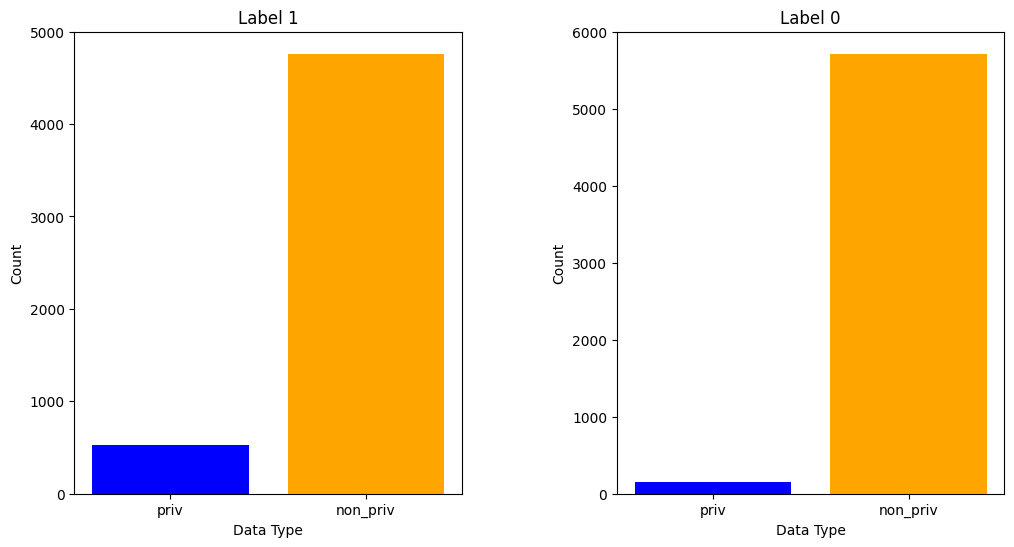

In [14]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

plt.savefig('plot_original_ratios.jpg')


# Show the plots
plt.show()

In [15]:
orig_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_cat
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,0,1
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,0,1
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,0,1
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,0,1


In [16]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [17]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 222]
 [149 784]] 
accuracy:  0.8211186113789778 precision:  0.7793240556660039 recall:  0.8403001071811361 fpr:  0.19456617002629273 tpr:  0.8403001071811361 fn+fp 371
conf matrix:
  [[ 22  12]
 [ 14 111]] 
accuracy:  0.83647798742

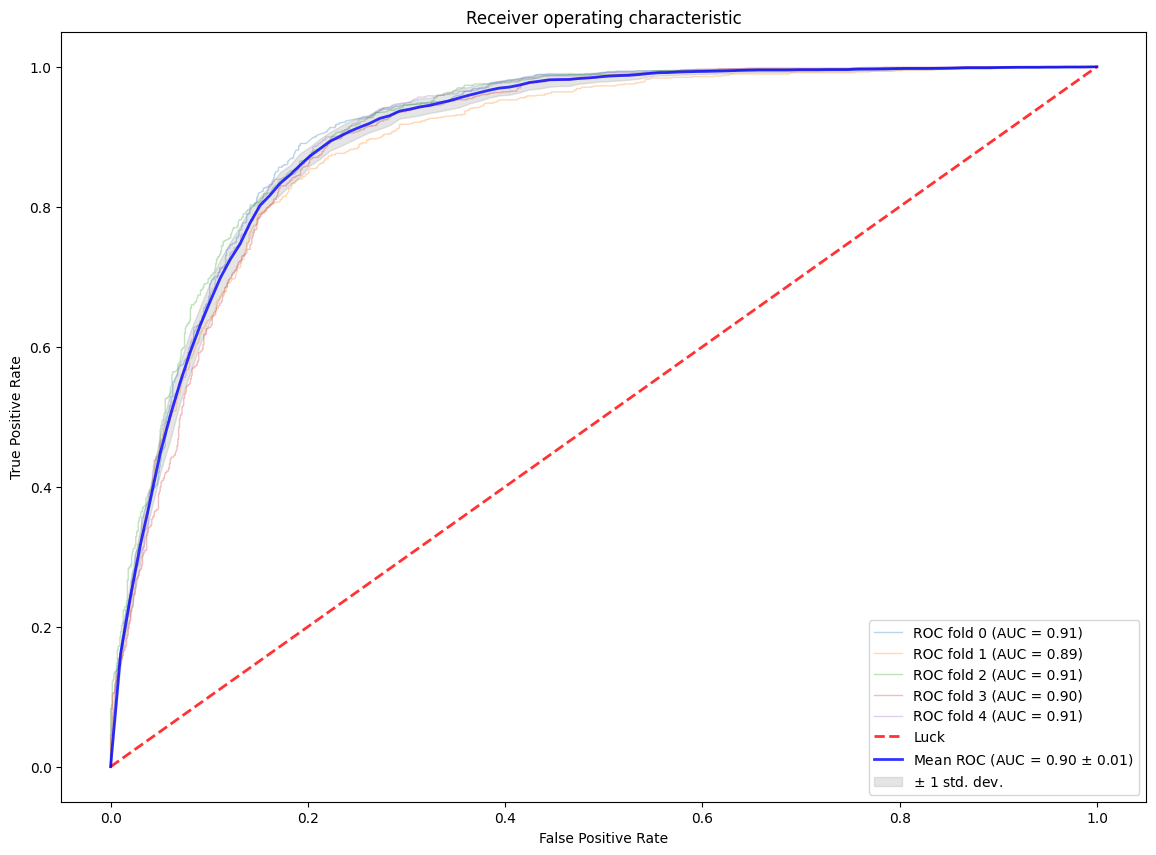

Accaracy list :  [0.8356471115091805, 0.8222122704881325, 0.8301971326164874, 0.828405017921147, 0.8324372759856631]
equal opportunity for tpr :  [0.1278422835026608, 0.04769989281886389, 0.07213010204081627, 0.021656271656271597, 0.10966381467430786]
equal opportunity for fpr :  [0.3689168391445099, 0.15837500644429553, 0.4236129723934602, 0.38288456743954125, 0.5297736220472441]
odds difference list :  [0.24837956132358535, 0.10303744963157971, 0.24787153721713823, 0.20227041954790642, 0.319718718360776]
The mean accuracy is  0.830 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.076 ± 0.039
The mean equal opportunity for fpr: (close to 0) 0.373 ± 0.121
The mean odds difference: (close to 0) 0.224 ± 0.071
The mean parity difference: (close to 0) 0.797 ± 0.018
The mean disperate impact: (close to 1) 1.000 ± 0.000


In [18]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

# CTGAN On Priv Target Group

In [19]:
orig_dataset[TARGET_COL] = orig_dataset[TARGET_COL].astype(int)

unprivileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
privileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
print(unprivileged_data_priv_target.shape[0])
print(privileged_data_priv_target.shape[0])

4762
527


In [20]:
unprivileged_data_priv_target

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,43,technician,divorced,unknown,no,4389,no,no,cellular,8,apr,618,1,-1,1,0,unknown,1
5283,45,admin.,divorced,secondary,no,0,no,no,cellular,29,oct,264,1,-1,1,0,unknown,1
5285,30,management,single,tertiary,no,398,no,no,cellular,27,oct,102,1,180,1,3,success,1
5287,48,entrepreneur,married,secondary,no,0,no,yes,cellular,28,jul,431,2,-1,1,0,unknown,1


In [21]:
from ctgan import CTGAN
if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)
else:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(privileged_data_priv_target , CATEGORICAL, epochs = 200)


# from ctgan import CTGAN

# if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
#     ctgan_priv_target = CTGAN(verbose=True)
#     # Fit the synthesizer to the unprivileged features
#     ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)


Gen. (0.36) | Discrim. (-0.06): 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


# CTGAN On Unpriv Target Group

In [22]:
unprivileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
privileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]

print(unprivileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0]-unprivileged_data_unpriv_target.shape[0])

5720
153
-5567


In [23]:
from ctgan import CTGAN
if unprivileged_data_unpriv_target.shape[0] <= privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(unprivileged_data_unpriv_target , CATEGORICAL, epochs = 200)

if unprivileged_data_unpriv_target.shape[0] > privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(privileged_data_unpriv_target , CATEGORICAL, epochs = 200)


Gen. (-0.11) | Discrim. (-0.03): 100%|██████████| 200/200 [00:21<00:00,  9.13it/s]


In [24]:
orig_dataset = pd.concat([orig_data_encoded, y_orig], axis=1)
orig_dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,age_cat,previous,poutcome,deposit
0,59,0.473013,0.433790,0.447407,0.476351,2343,0.366408,0.495259,0.225916,5,0.327550,1042,1,-1,1,0,0.406678,1
1,56,0.473013,0.433790,0.447407,0.476351,45,0.570311,0.495259,0.225916,5,0.327550,1467,1,-1,1,0,0.406678,1
2,41,0.460779,0.433790,0.447407,0.476351,1270,0.366408,0.495259,0.225916,5,0.327550,1389,1,-1,1,0,0.406678,1
3,55,0.399783,0.433790,0.447407,0.476351,2476,0.366408,0.495259,0.225916,5,0.327550,579,1,-1,1,0,0.406678,1
4,54,0.473013,0.433790,0.541068,0.476351,184,0.570311,0.495259,0.225916,5,0.327550,673,2,-1,1,0,0.406678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0.364198,0.543491,0.394000,0.476351,1,0.366408,0.495259,0.543273,20,0.625135,257,1,-1,1,0,0.406678,0
11158,39,0.399783,0.433790,0.447407,0.476351,733,0.570311,0.495259,0.225916,16,0.446809,83,4,-1,1,0,0.406678,0
11159,32,0.460779,0.543491,0.447407,0.476351,29,0.570311,0.495259,0.543273,19,0.452930,156,2,-1,1,0,0.406678,0
11160,43,0.460779,0.433790,0.447407,0.476351,0,0.570311,0.331507,0.543273,8,0.327550,9,2,172,1,5,0.503257,0


In [25]:
print(DATASET_NAME)

BANK_AGE


Optuna FairUS

In [26]:
def Upsampling_Dataset(lambda_0, lambda_1):
    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    #print(priv_target_samples)
    # print('number of samples i added(lambda_0)', len(priv_target_samples))
    y_priv = priv_target_samples[TARGET_COL]
    priv_target_samples = priv_target_samples.loc[:, feature_columns]

    priv_target_samples = encoder.transform(priv_target_samples)
    priv_target_samples = pd.concat([priv_target_samples, y_priv], axis=1)

    unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(lambda_1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    # print('number of samples i added(lambda_1)', len(unpriv_target_samples))
    y_unpriv = unpriv_target_samples[TARGET_COL]
    unpriv_target_samples = unpriv_target_samples.loc[:, feature_columns]

    unpriv_target_samples = encoder.transform(unpriv_target_samples)
    unpriv_target_samples = pd.concat([unpriv_target_samples, y_unpriv], axis=1)

    if len((priv_target_samples)>0) and (len(unpriv_target_samples)==0):
        df_list = [orig_dataset, priv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(unpriv_target_samples)>0) and (len(priv_target_samples)==0):
        df_list = [orig_dataset, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_debias = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)>0) and (len(unpriv_target_samples)>0):
        df_list = [orig_dataset, priv_target_samples, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)==0) and (len(unpriv_target_samples)==0):
        upsampled_df = orig_dataset
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    return upsampled_df


In [27]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [28]:
!pip install cmaes


In [29]:
import optuna


In [30]:
all_upsampled_acc = []
all_upsampled_od_diff = []

def FairUS_Finding_Optimal_Lambdas_Optuna(trial):

    # Initialize original Equalized odds and Accuracy Scores
    orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact = fairness_metrics_roc_auc_no_print(orig_data_encoded, y_orig)

    OrigFair_score = mean(orig_od_diff)
    OrigAcc_score = mean(orig_acc)

    # Initialize matrices to store Fairness and Accuracy results
    #Fairness_Matrix = np.zeros((num_steps, num_steps))
    #Accuracy_Matrix = np.zeros((num_steps, num_steps))

    lambda_0 =  trial.suggest_float("lambda_0", 0, 2)
    lambda_1 =  trial.suggest_float("lambda_1", 0, 2)

    upsampled_df = Upsampling_Dataset(lambda_0, lambda_1)
    y_debias = upsampled_df[TARGET_COL]
    upsampled_df_features = upsampled_df.loc[:, feature_columns]

    upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact = fairness_metrics_roc_auc_no_print(upsampled_df_features, y_debias)

    CurrFair_score = mean(upsampled_od_diff)
    CurrAcc_score = mean(upsampled_acc)
    # if ALPHA == 1:
    #   optimization_objective = CurrFair_score/mean(orig_od_diff)
    # else:
      # optimization_objective = (ALPHA*CurrFair_score/mean(orig_od_diff)) - ((1-ALPHA)*CurrAcc_score/mean(orig_acc))
    optimization_objective = (CurrFair_score/mean(orig_od_diff)) - (CurrAcc_score/mean(orig_acc))
    # optimization_objective = (CurrFair_score) - (CurrAcc_score)

    # Update fairness matrix with Equalized odds subtraction
    #Fairness_Matrix[i, j] = -(CurrFair_score - OrigFair_score)
    # Update accuracy matrix with Minos accuracy subtraction
    #Accuracy_Matrix[i, j] = (CurrAcc_score - OrigAcc_score)


    #fairness_delta = np.max(Fairness_Matrix)-np.min(Fairness_Matrix)
    #acc_delta = np.max(Accuracy_Matrix)-np.min(Accuracy_Matrix)
    #fairness_factor = acc_delta / fairness_delta
    #scaled_fairness_matrix = fairness_factor * Fairness_Matrix


    #Accuracy_Matrix = -(Accuracy_Matrix)
    #scaled_fairness_matrix= -(scaled_fairness_matrix)
    print ('lambda_0:',lambda_0)
    print ('lambda_1:',lambda_1)
    #print ('fairness matrix before scaling: ',Fairness_Matrix)
    #print ('fairness matrix after scaling: ',scaled_fairness_matrix)
    #print ('acc matrix is: ', Accuracy_Matrix)

    # Save upsampled_acc and upsampled_op_diff as trial attributes
    upsampled_acc = mean(upsampled_acc)
    upsampled_od_diff = mean(upsampled_od_diff)
    trial.set_user_attr('upsampled_acc', upsampled_acc)
    trial.set_user_attr('upsampled_op_diff', upsampled_od_diff)
    print('---------------------------------------trail upsampled_acc is : ', trial.user_attrs.get('upsampled_acc'))
    print('---------------------------------------trail upsampled_op_diff is : ', trial.user_attrs.get('upsampled_op_diff'))
    all_upsampled_acc.append(upsampled_acc)
    all_upsampled_od_diff.append(upsampled_od_diff)

    # Return optimal dataset upsampled with lambda_0, lambda_1 values
    # return optimization_objective #scaled_fairness_matrix
    return CurrFair_score, CurrAcc_score #for multi objective


In [31]:
# Record the start time
start_time = time.time()

In [32]:
CME_flag = False

if CME_flag:
  from optuna.samplers import CmaEsSampler

  # Create an instance of CmaEsSampler
  # Create an instance of CmaEsSampler with specified parameters
  cma_es_sampler = CmaEsSampler(
      sigma0=0.01,  # Initial standard deviation of the distribution.
      n_startup_trials=10,  # The number of trials before using CMA-ES.
      independent_sampler=optuna.samplers.RandomSampler(seed=0)  # Sampler used for the first `n_startup_trials`.
  )


  # Pass the instance of CmaEsSampler to create_study
  # study = optuna.create_study(sampler=cma_es_sampler, direction='minimize')
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=400)
else:
  from optuna.samplers import TPESampler

  # Create an instance of TPESampler with custom parameters
  # You can adjust parameters like n_startup_trials, n_ei_candidates, etc.
  tpe_sampler = TPESampler(n_startup_trials=20, n_ei_candidates=24, multivariate=True)

  # Pass the instance of TPESampler to create_study
  # study = optuna.create_study(sampler=tpe_sampler, direction='minimize') #directions=['minimize', 'maximize']
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=200)

/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-01 16:25:47,170] A new study created in memory with name: no-name-810ca795-bf26-4b0b-95f5-ac6eb4f8a1d0


conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 222]
 [149 784]] 
accuracy:  0.8211186113789778 precision:  0.7793240556660039 recall:  0.8403001071811361 fpr:  0.19456617002629273 tpr:  0.8403001071811361 fn+fp 371
conf matrix:
  [[ 22  12]
 [ 14 111]] 
accuracy:  0.83647798742

[I 2024-04-01 16:25:50,031] Trial 0 finished with values: [0.22478643271185164, 0.8587622293523196] and parameters: {'lambda_0': 0.4286647761906699, 'lambda_1': 1.900475181937632}. 


fpr:  0.1449525452976704 tpr:  0.7256728778467909 fn+fp 433
conf matrix:
  [[2116   16]
 [ 238  216]] 
accuracy:  0.9017788089713844 precision:  0.9310344827586207 recall:  0.47577092511013214 fpr:  0.0075046904315197 tpr:  0.47577092511013214 fn+fp 254
lambda_0: 0.4286647761906699
lambda_1: 1.900475181937632
---------------------------------------trail upsampled_acc is :  0.8587622293523196
---------------------------------------trail upsampled_op_diff is :  0.22478643271185164
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.51515151

[I 2024-04-01 16:25:51,809] Trial 1 finished with values: [0.21631423331604566, 0.8416087087995162] and parameters: {'lambda_0': 0.17567748514703752, 'lambda_1': 0.8318237267376261}. 


conf matrix:
  [[1887  214]
 [ 301  905]] 
accuracy:  0.8442697308739039 precision:  0.80875781948168 recall:  0.7504145936981758 fpr:  0.10185625892432175 tpr:  0.7504145936981758 fn+fp 515
conf matrix:
  [[949 196]
 [167 784]] 
accuracy:  0.8268129770992366 precision:  0.8 recall:  0.8243953732912723 fpr:  0.17117903930131004 tpr:  0.8243953732912723 fn+fp 363
conf matrix:
  [[938  18]
 [134 121]] 
accuracy:  0.8744838976052849 precision:  0.8705035971223022 recall:  0.4745098039215686 fpr:  0.01882845188284519 tpr:  0.4745098039215686 fn+fp 152
lambda_0: 0.17567748514703752
lambda_1: 0.8318237267376261
---------------------------------------trail upsampled_acc is :  0.8416087087995162
---------------------------------------trail upsampled_op_diff is :  0.21631423331604566
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]


[I 2024-04-01 16:25:55,283] Trial 2 finished with values: [0.3129097979862633, 0.8661815589171057] and parameters: {'lambda_0': 1.7259896134268085, 'lambda_1': 0.16008205745589432}. 


conf matrix:
  [[ 981  372]
 [ 158 2361]] 
accuracy:  0.8631198347107438 precision:  0.8638858397365532 recall:  0.9372766971020247 fpr:  0.2749445676274945 tpr:  0.9372766971020247 fn+fp 530
conf matrix:
  [[906 230]
 [153 837]] 
accuracy:  0.8198494825964252 precision:  0.7844423617619494 recall:  0.8454545454545455 fpr:  0.20246478873239437 tpr:  0.8454545454545455 fn+fp 383
conf matrix:
  [[  75  142]
 [   5 1524]] 
accuracy:  0.915807560137457 precision:  0.9147659063625451 recall:  0.9967298888162197 fpr:  0.6543778801843319 tpr:  0.9967298888162197 fn+fp 147
lambda_0: 1.7259896134268085
lambda_1: 0.16008205745589432
---------------------------------------trail upsampled_acc is :  0.8661815589171057
---------------------------------------trail upsampled_op_diff is :  0.3129097979862633
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:26:00,078] Trial 3 finished with values: [0.2827701575944784, 0.8603051826865608] and parameters: {'lambda_0': 1.5707551044882397, 'lambda_1': 0.18457721848655795}. 


conf matrix:
  [[ 983  397]
 [ 137 2251]] 
accuracy:  0.85828025477707 precision:  0.8500755287009063 recall:  0.9426298157453936 fpr:  0.2876811594202899 tpr:  0.9426298157453936 fn+fp 534
conf matrix:
  [[896 252]
 [130 844]] 
accuracy:  0.8199811498586239 precision:  0.7700729927007299 recall:  0.86652977412731 fpr:  0.21951219512195122 tpr:  0.86652977412731 fn+fp 382
conf matrix:
  [[  87  145]
 [   7 1407]] 
accuracy:  0.9076549210206561 precision:  0.9065721649484536 recall:  0.995049504950495 fpr:  0.625 tpr:  0.995049504950495 fn+fp 152
lambda_0: 1.5707551044882397
lambda_1: 0.18457721848655795
---------------------------------------trail upsampled_acc is :  0.8603051826865608
---------------------------------------trail upsampled_op_diff is :  0.2827701575944784
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [1

[I 2024-04-01 16:26:04,051] Trial 4 finished with values: [0.07652724800345198, 0.8435256060252154] and parameters: {'lambda_0': 1.5861080869078599, 'lambda_1': 0.8213951753111406}. 


conf matrix:
  [[1652  437]
 [ 294 2107]] 
accuracy:  0.8371937639198218 precision:  0.8282232704402516 recall:  0.8775510204081632 fpr:  0.20919100047869793 tpr:  0.8775510204081632 fn+fp 731
conf matrix:
  [[888 269]
 [176 798]] 
accuracy:  0.7911778507742844 precision:  0.7478912839737581 recall:  0.8193018480492813 fpr:  0.23249783923941228 tpr:  0.8193018480492813 fn+fp 445
conf matrix:
  [[ 764  168]
 [ 118 1309]] 
accuracy:  0.8787621873675286 precision:  0.8862559241706162 recall:  0.9173090399439383 fpr:  0.18025751072961374 tpr:  0.9173090399439383 fn+fp 286
lambda_0: 1.5861080869078599
lambda_1: 0.8213951753111406
---------------------------------------trail upsampled_acc is :  0.8435256060252154
---------------------------------------trail upsampled_op_diff is :  0.07652724800345198
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf m

[I 2024-04-01 16:26:09,325] Trial 5 finished with values: [0.09072733819589801, 0.8445451758600321] and parameters: {'lambda_0': 1.6289452941793308, 'lambda_1': 1.4796444168596374}. 


conf matrix:
  [[2461  361]
 [ 486 1951]] 
accuracy:  0.8389427647841795 precision:  0.8438581314878892 recall:  0.8005744768157571 fpr:  0.12792345854004253 tpr:  0.8005744768157571 fn+fp 847
conf matrix:
  [[941 194]
 [286 691]] 
accuracy:  0.7727272727272727 precision:  0.7807909604519774 recall:  0.7072671443193449 fpr:  0.17092511013215858 tpr:  0.7072671443193449 fn+fp 480
conf matrix:
  [[1520  167]
 [ 200 1260]] 
accuracy:  0.8833809977756594 precision:  0.8829712683952348 recall:  0.863013698630137 fpr:  0.0989922940130409 tpr:  0.863013698630137 fn+fp 367
lambda_0: 1.6289452941793308
lambda_1: 1.4796444168596374
---------------------------------------trail upsampled_acc is :  0.8445451758600321
---------------------------------------trail upsampled_op_diff is :  0.09072733819589801
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:26:14,902] Trial 6 finished with values: [0.056148612390929165, 0.8307640556701883] and parameters: {'lambda_0': 0.730552993448504, 'lambda_1': 1.0280742713335538}. 


conf matrix:
  [[1996  323]
 [ 348 1328]] 
accuracy:  0.8320400500625782 precision:  0.8043609933373713 recall:  0.7923627684964201 fpr:  0.13928417421302286 tpr:  0.7923627684964201 fn+fp 671
conf matrix:
  [[923 214]
 [182 748]] 
accuracy:  0.8084179970972424 precision:  0.7775467775467776 recall:  0.8043010752688172 fpr:  0.1882145998240985 tpr:  0.8043010752688172 fn+fp 396
conf matrix:
  [[1073  109]
 [ 166  580]] 
accuracy:  0.8573651452282157 precision:  0.841799709724238 recall:  0.7774798927613941 fpr:  0.0922165820642978 tpr:  0.7774798927613941 fn+fp 275
lambda_0: 0.730552993448504
lambda_1: 1.0280742713335538
---------------------------------------trail upsampled_acc is :  0.8307640556701883
---------------------------------------trail upsampled_op_diff is :  0.056148612390929165
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:26:18,605] Trial 7 finished with values: [0.4287613261104677, 0.8683048541104342] and parameters: {'lambda_0': 1.2633377186814747, 'lambda_1': 0.03883737313447955}. 


conf matrix:
  [[ 954  264]
 [ 161 1966]] 
accuracy:  0.8729446935724963 precision:  0.8816143497757848 recall:  0.924306535025858 fpr:  0.21674876847290642 tpr:  0.924306535025858 fn+fp 425
conf matrix:
  [[944 195]
 [160 791]] 
accuracy:  0.8301435406698564 precision:  0.8022312373225152 recall:  0.8317560462670873 fpr:  0.17120280948200176 tpr:  0.8317560462670873 fn+fp 355
conf matrix:
  [[  10   69]
 [   1 1175]] 
accuracy:  0.9442231075697212 precision:  0.9445337620578779 recall:  0.9991496598639455 fpr:  0.8734177215189873 tpr:  0.9991496598639455 fn+fp 70
lambda_0: 1.2633377186814747
lambda_1: 0.03883737313447955
---------------------------------------trail upsampled_acc is :  0.8683048541104342
---------------------------------------trail upsampled_op_diff is :  0.4287613261104677
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:26:24,292] Trial 8 finished with values: [0.0696488561597487, 0.8429941556808261] and parameters: {'lambda_0': 1.1233953931289002, 'lambda_1': 1.8107386428374008}. 


conf matrix:
  [[2886  304]
 [ 486 1523]] 
accuracy:  0.848047701481054 precision:  0.8336070060207992 recall:  0.7580886012941762 fpr:  0.09529780564263322 tpr:  0.7580886012941762 fn+fp 790
conf matrix:
  [[965 198]
 [236 712]] 
accuracy:  0.7944102321174799 precision:  0.7824175824175824 recall:  0.7510548523206751 fpr:  0.1702493551160791 tpr:  0.7510548523206751 fn+fp 434
conf matrix:
  [[1921  106]
 [ 250  811]] 
accuracy:  0.8847150259067358 precision:  0.8844056706652127 recall:  0.764373232799246 fpr:  0.05229403058707449 tpr:  0.764373232799246 fn+fp 356
lambda_0: 1.1233953931289002
lambda_1: 1.8107386428374008
---------------------------------------trail upsampled_acc is :  0.8429941556808261
---------------------------------------trail upsampled_op_diff is :  0.0696488561597487
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:26:29,417] Trial 9 finished with values: [0.07759996719316756, 0.8368110236220473] and parameters: {'lambda_0': 0.601756982990352, 'lambda_1': 1.1874303585181234}. 


conf matrix:
  [[2230  267]
 [ 412 1155]] 
accuracy:  0.8329232283464567 precision:  0.8122362869198312 recall:  0.7370772176132737 fpr:  0.10692831397677213 tpr:  0.7370772176132737 fn+fp 679
conf matrix:
  [[923 195]
 [240 719]] 
accuracy:  0.7905633124699085 precision:  0.7866520787746171 recall:  0.7497393117831074 fpr:  0.1744186046511628 tpr:  0.7497393117831074 fn+fp 435
conf matrix:
  [[1307   72]
 [ 172  436]] 
accuracy:  0.8772018117765475 precision:  0.8582677165354331 recall:  0.7171052631578947 fpr:  0.05221174764321972 tpr:  0.7171052631578947 fn+fp 244
lambda_0: 0.601756982990352
lambda_1: 1.1874303585181234
---------------------------------------trail upsampled_acc is :  0.8368110236220473
---------------------------------------trail upsampled_op_diff is :  0.07759996719316756
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:26:31,467] Trial 10 finished with values: [0.06039652386996231, 0.8289950576606261] and parameters: {'lambda_0': 0.9445894366562542, 'lambda_1': 0.5475691228251998}. 


conf matrix:
  [[1387  398]
 [ 238 1619]] 
accuracy:  0.8253706754530478 precision:  0.8026772434308379 recall:  0.871836295099623 fpr:  0.22296918767507004 tpr:  0.871836295099623 fn+fp 636
conf matrix:
  [[884 263]
 [159 745]] 
accuracy:  0.7942467089224768 precision:  0.7390873015873016 recall:  0.8241150442477876 fpr:  0.22929380993897122 tpr:  0.8241150442477876 fn+fp 422
conf matrix:
  [[503 135]
 [ 79 874]] 
accuracy:  0.8654934003771213 precision:  0.8662041625371655 recall:  0.9171038824763903 fpr:  0.2115987460815047 tpr:  0.9171038824763903 fn+fp 214
lambda_0: 0.9445894366562542
lambda_1: 0.5475691228251998
---------------------------------------trail upsampled_acc is :  0.8289950576606261
---------------------------------------trail upsampled_op_diff is :  0.06039652386996231
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:26:33,849] Trial 11 finished with values: [0.08891862061082954, 0.8402204829487342] and parameters: {'lambda_0': 1.681613635635986, 'lambda_1': 1.667036387395126}. 


conf matrix:
  [[2626  404]
 [ 425 2057]] 
accuracy:  0.849600870827286 precision:  0.8358390898008939 recall:  0.8287671232876712 fpr:  0.13333333333333333 tpr:  0.8287671232876712 fn+fp 829
conf matrix:
  [[951 219]
 [240 710]] 
accuracy:  0.7834905660377358 precision:  0.7642626480086114 recall:  0.7473684210526316 fpr:  0.18717948717948718 tpr:  0.7473684210526316 fn+fp 459
conf matrix:
  [[1675  185]
 [ 185 1347]] 
accuracy:  0.8909198113207547 precision:  0.8792428198433421 recall:  0.8792428198433421 fpr:  0.09946236559139784 tpr:  0.8792428198433421 fn+fp 370
lambda_0: 1.681613635635986
lambda_1: 1.667036387395126
---------------------------------------trail upsampled_acc is :  0.8402204829487342
---------------------------------------trail upsampled_op_diff is :  0.08891862061082954
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:26:36,043] Trial 12 finished with values: [0.06452685165712913, 0.8396306518182827] and parameters: {'lambda_0': 1.064378073207084, 'lambda_1': 1.5874665574707658}. 


conf matrix:
  [[977 183]
 [247 683]] 
accuracy:  0.7942583732057417 precision:  0.7886836027713626 recall:  0.7344086021505376 fpr:  0.15775862068965518 tpr:  0.7344086021505376 fn+fp 430
conf matrix:
  [[1661  121]
 [ 221  808]] 
accuracy:  0.8783351120597652 precision:  0.8697524219590959 recall:  0.7852283770651117 fpr:  0.06790123456790123 tpr:  0.7852283770651117 fn+fp 342
lambda_0: 1.064378073207084
lambda_1: 1.5874665574707658
---------------------------------------trail upsampled_acc is :  0.8396306518182827
---------------------------------------trail upsampled_op_diff is :  0.06452685165712913
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:

[I 2024-04-01 16:26:38,684] Trial 13 finished with values: [0.08186116263202689, 0.850970386284957] and parameters: {'lambda_0': 1.9996949183462194, 'lambda_1': 0.8432430424694222}. 


conf matrix:
  [[1708  405]
 [ 302 2449]] 
accuracy:  0.8546463815789473 precision:  0.858093903293623 recall:  0.8902217375499818 fpr:  0.19167061050638903 tpr:  0.8902217375499818 fn+fp 707
conf matrix:
  [[933 232]
 [190 770]] 
accuracy:  0.8014117647058824 precision:  0.7684630738522954 recall:  0.8020833333333334 fpr:  0.19914163090128756 tpr:  0.8020833333333334 fn+fp 422
conf matrix:
  [[ 775  173]
 [ 112 1679]] 
accuracy:  0.895947426067908 precision:  0.9065874730021598 recall:  0.937465103294249 fpr:  0.18248945147679324 tpr:  0.937465103294249 fn+fp 285
lambda_0: 1.9996949183462194
lambda_1: 0.8432430424694222
---------------------------------------trail upsampled_acc is :  0.850970386284957
---------------------------------------trail upsampled_op_diff is :  0.08186116263202689
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:26:41,048] Trial 14 finished with values: [0.0720793278353254, 0.830816338352313] and parameters: {'lambda_0': 1.0596819224080467, 'lambda_1': 0.9360434347419044}. 


conf matrix:
  [[1875  341]
 [ 373 1582]] 
accuracy:  0.8288180292495805 precision:  0.8226729069162767 recall:  0.8092071611253197 fpr:  0.15388086642599277 tpr:  0.8092071611253197 fn+fp 714
conf matrix:
  [[966 208]
 [236 696]] 
accuracy:  0.7891737891737892 precision:  0.7699115044247787 recall:  0.7467811158798283 fpr:  0.17717206132879046 tpr:  0.7467811158798283 fn+fp 444
conf matrix:
  [[909 133]
 [137 886]] 
accuracy:  0.8692493946731235 precision:  0.8694798822374877 recall:  0.8660801564027371 fpr:  0.1276391554702495 tpr:  0.8660801564027371 fn+fp 270
lambda_0: 1.0596819224080467
lambda_1: 0.9360434347419044
---------------------------------------trail upsampled_acc is :  0.830816338352313
---------------------------------------trail upsampled_op_diff is :  0.0720793278353254
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:26:43,189] Trial 15 finished with values: [0.2761278206761246, 0.8593422371788131] and parameters: {'lambda_0': 0.30115781482222914, 'lambda_1': 1.920299565693946}. 


conf matrix:
  [[2153   15]
 [ 205  125]] 
accuracy:  0.911929543634908 precision:  0.8928571428571429 recall:  0.3787878787878788 fpr:  0.006918819188191882 tpr:  0.3787878787878788 fn+fp 220
lambda_0: 0.30115781482222914
lambda_1: 1.920299565693946
---------------------------------------trail upsampled_acc is :  0.8593422371788131
---------------------------------------trail upsampled_op_diff is :  0.2761278206761246
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[9

[I 2024-04-01 16:26:45,060] Trial 16 finished with values: [0.12174040451251388, 0.832510273016561] and parameters: {'lambda_0': 0.3943288825444906, 'lambda_1': 0.9694644647167814}. 


conf matrix:
  [[2007  247]
 [ 368 1023]] 
accuracy:  0.831275720164609 precision:  0.805511811023622 recall:  0.7354421279654925 fpr:  0.1095829636202307 tpr:  0.7354421279654925 fn+fp 615
conf matrix:
  [[942 189]
 [212 743]] 
accuracy:  0.8077660594439118 precision:  0.7972103004291845 recall:  0.7780104712041885 fpr:  0.16710875331564987 tpr:  0.7780104712041885 fn+fp 401
conf matrix:
  [[1065   58]
 [ 156  280]] 
accuracy:  0.8627325208466966 precision:  0.8284023668639053 recall:  0.6422018348623854 fpr:  0.051647373107747106 tpr:  0.6422018348623854 fn+fp 214
lambda_0: 0.3943288825444906
lambda_1: 0.9694644647167814
---------------------------------------trail upsampled_acc is :  0.832510273016561
---------------------------------------trail upsampled_op_diff is :  0.12174040451251388
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:26:47,215] Trial 17 finished with values: [0.08390745398199954, 0.841406265955065] and parameters: {'lambda_0': 1.494132124578951, 'lambda_1': 1.0084883231754949}. 


conf matrix:
  [[1934  363]
 [ 301 2022]] 
accuracy:  0.8562770562770563 precision:  0.8477987421383648 recall:  0.8704261730520878 fpr:  0.15803221593382674 tpr:  0.8704261730520878 fn+fp 664
conf matrix:
  [[954 216]
 [194 773]] 
accuracy:  0.8081422554983622 precision:  0.78159757330637 recall:  0.7993795243019648 fpr:  0.18461538461538463 tpr:  0.7993795243019648 fn+fp 410
conf matrix:
  [[ 980  147]
 [ 107 1249]] 
accuracy:  0.8977043898509867 precision:  0.8946991404011462 recall:  0.9210914454277286 fpr:  0.13043478260869565 tpr:  0.9210914454277286 fn+fp 254
lambda_0: 1.494132124578951
lambda_1: 1.0084883231754949
---------------------------------------trail upsampled_acc is :  0.841406265955065
---------------------------------------trail upsampled_op_diff is :  0.08390745398199954
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:26:48,945] Trial 18 finished with values: [0.3421101687679091, 0.85123479750328] and parameters: {'lambda_0': 0.8384782137114692, 'lambda_1': 0.07175299044524164}. 


conf matrix:
  [[ 933  322]
 [ 104 1663]] 
accuracy:  0.8590337524818001 precision:  0.8377833753148615 recall:  0.9411431805319751 fpr:  0.25657370517928285 tpr:  0.9411431805319751 fn+fp 426
conf matrix:
  [[903 248]
 [ 99 840]] 
accuracy:  0.8339712918660287 precision:  0.7720588235294118 recall:  0.8945686900958466 fpr:  0.2154648132059079 tpr:  0.8945686900958466 fn+fp 347
conf matrix:
  [[ 30  74]
 [  5 823]] 
accuracy:  0.9152360515021459 precision:  0.9175027870680045 recall:  0.9939613526570048 fpr:  0.7115384615384616 tpr:  0.9939613526570048 fn+fp 79
lambda_0: 0.8384782137114692
lambda_1: 0.07175299044524164
---------------------------------------trail upsampled_acc is :  0.85123479750328
---------------------------------------trail upsampled_op_diff is :  0.3421101687679091
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  

[I 2024-04-01 16:26:51,180] Trial 19 finished with values: [0.41025429914339157, 0.8717453913936906] and parameters: {'lambda_0': 1.8662659543656872, 'lambda_1': 0.09509355094081151}. 


conf matrix:
  [[ 975  305]
 [ 279 2359]] 
accuracy:  0.850944359367024 precision:  0.8855105105105106 recall:  0.8942380591357089 fpr:  0.23828125 tpr:  0.8942380591357089 fn+fp 584
conf matrix:
  [[946 193]
 [278 664]] 
accuracy:  0.7736665064872658 precision:  0.7747957992998833 recall:  0.7048832271762208 fpr:  0.1694468832309043 tpr:  0.7048832271762208 fn+fp 471
conf matrix:
  [[  29  112]
 [   1 1695]] 
accuracy:  0.9384866630375612 precision:  0.9380188157166575 recall:  0.9994103773584906 fpr:  0.7943262411347518 tpr:  0.9994103773584906 fn+fp 113
lambda_0: 1.8662659543656872
lambda_1: 0.09509355094081151
---------------------------------------trail upsampled_acc is :  0.8717453913936906
---------------------------------------trail upsampled_op_diff is :  0.41025429914339157
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[

[I 2024-04-01 16:26:53,145] Trial 20 finished with values: [0.030715943394626043, 0.8226852620848648] and parameters: {'lambda_0': 0.056089090440863965, 'lambda_1': 0.13164141475572877}. 


conf matrix:
  [[1077  244]
 [ 195  910]] 
accuracy:  0.8190436933223413 precision:  0.7885615251299827 recall:  0.8235294117647058 fpr:  0.18470855412566237 tpr:  0.8235294117647058 fn+fp 439
conf matrix:
  [[937 209]
 [162 780]] 
accuracy:  0.8223180076628352 precision:  0.788675429726997 recall:  0.8280254777070064 fpr:  0.1823734729493892 tpr:  0.8280254777070064 fn+fp 371
conf matrix:
  [[140  35]
 [ 33 130]] 
accuracy:  0.7988165680473372 precision:  0.7878787878787878 recall:  0.7975460122699386 fpr:  0.2 tpr:  0.7975460122699386 fn+fp 68
lambda_0: 0.056089090440863965
lambda_1: 0.13164141475572877
---------------------------------------trail upsampled_acc is :  0.8226852620848648
---------------------------------------trail upsampled_op_diff is :  0.030715943394626043
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]

[I 2024-04-01 16:26:54,677] Trial 21 finished with values: [0.09963203394818118, 0.8228527607361964] and parameters: {'lambda_0': 0.2656701610543922, 'lambda_1': 0.13527210345978746}. 


conf matrix:
  [[1019  307]
 [ 165 1117]] 
accuracy:  0.8190184049079755 precision:  0.7844101123595506 recall:  0.8712948517940717 fpr:  0.23152337858220212 tpr:  0.8712948517940717 fn+fp 472
conf matrix:
  [[894 241]
 [142 822]] 
accuracy:  0.8175321581705574 precision:  0.7732831608654751 recall:  0.8526970954356846 fpr:  0.21233480176211453 tpr:  0.8526970954356846 fn+fp 383
conf matrix:
  [[125  66]
 [ 23 295]] 
accuracy:  0.825147347740668 precision:  0.817174515235457 recall:  0.9276729559748428 fpr:  0.34554973821989526 tpr:  0.9276729559748428 fn+fp 89
lambda_0: 0.2656701610543922
lambda_1: 0.13527210345978746
---------------------------------------trail upsampled_acc is :  0.8228527607361964
---------------------------------------trail upsampled_op_diff is :  0.09963203394818118
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:

[I 2024-04-01 16:26:56,816] Trial 22 finished with values: [0.06900077873555963, 0.8573126724686904] and parameters: {'lambda_0': 1.9169715730749564, 'lambda_1': 0.7680235877587193}. 


conf matrix:
  [[1602  428]
 [ 247 2434]] 
accuracy:  0.8567183188282742 precision:  0.8504542278127184 recall:  0.90787019768743 fpr:  0.21083743842364533 tpr:  0.90787019768743 fn+fp 675
conf matrix:
  [[917 244]
 [180 797]] 
accuracy:  0.8016838166510758 precision:  0.765609990393852 recall:  0.8157625383828045 fpr:  0.21016365202411713 tpr:  0.8157625383828045 fn+fp 424
conf matrix:
  [[ 685  184]
 [  67 1637]] 
accuracy:  0.9024485036921881 precision:  0.8989566172432729 recall:  0.9606807511737089 fpr:  0.21173762945914845 tpr:  0.9606807511737089 fn+fp 251
lambda_0: 1.9169715730749564
lambda_1: 0.7680235877587193
---------------------------------------trail upsampled_acc is :  0.8573126724686904
---------------------------------------trail upsampled_op_diff is :  0.06900077873555963
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:26:58,298] Trial 23 finished with values: [0.22097819671875235, 0.8284318080852954] and parameters: {'lambda_0': 0.018922475710281494, 'lambda_1': 0.0025018410270323255}. 


conf matrix:
  [[971 207]
 [155 918]] 
accuracy:  0.8391825855175478 precision:  0.816 recall:  0.8555452003727866 fpr:  0.17572156196943972 tpr:  0.8555452003727866 fn+fp 362
conf matrix:
  [[957 191]
 [150 818]] 
accuracy:  0.8388468809073724 precision:  0.8107036669970268 recall:  0.8450413223140496 fpr:  0.16637630662020905 tpr:  0.8450413223140496 fn+fp 341
conf matrix:
  [[ 14  16]
 [  5 100]] 
accuracy:  0.8444444444444444 precision:  0.8620689655172413 recall:  0.9523809523809523 fpr:  0.5333333333333333 tpr:  0.9523809523809523 fn+fp 21
lambda_0: 0.018922475710281494
lambda_1: 0.0025018410270323255
---------------------------------------trail upsampled_acc is :  0.8284318080852954
---------------------------------------trail upsampled_op_diff is :  0.22097819671875235
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167

[I 2024-04-01 16:27:00,456] Trial 24 finished with values: [0.07853301709375635, 0.8566164480722915] and parameters: {'lambda_0': 1.9824890471450278, 'lambda_1': 0.6788793272603215}. 


precision:  0.7542056074766356 recall:  0.838006230529595 fpr:  0.22869565217391305 tpr:  0.838006230529595 fn+fp 419
conf matrix:
  [[ 587  194]
 [  68 1705]] 
accuracy:  0.8974158183241974 precision:  0.8978409689310163 recall:  0.9616469261139312 fpr:  0.24839948783610755 tpr:  0.9616469261139312 fn+fp 262
lambda_0: 1.9824890471450278
lambda_1: 0.6788793272603215
---------------------------------------trail upsampled_acc is :  0.8566164480722915
---------------------------------------trail upsampled_op_diff is :  0.07853301709375635
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.852

[I 2024-04-01 16:27:02,714] Trial 25 finished with values: [0.07145990487258576, 0.8478621561985487] and parameters: {'lambda_0': 1.999249692824483, 'lambda_1': 1.0283496057913701}. 


conf matrix:
  [[1872  447]
 [ 312 2439]] 
accuracy:  0.8502958579881656 precision:  0.8451143451143451 recall:  0.8865866957470011 fpr:  0.1927554980595084 tpr:  0.8865866957470011 fn+fp 759
conf matrix:
  [[906 234]
 [177 801]] 
accuracy:  0.8059490084985835 precision:  0.7739130434782608 recall:  0.8190184049079755 fpr:  0.20526315789473684 tpr:  0.8190184049079755 fn+fp 411
conf matrix:
  [[ 966  213]
 [ 135 1638]] 
accuracy:  0.8821138211382114 precision:  0.8849270664505673 recall:  0.9238578680203046 fpr:  0.1806615776081425 tpr:  0.9238578680203046 fn+fp 348
lambda_0: 1.999249692824483
lambda_1: 1.0283496057913701
---------------------------------------trail upsampled_acc is :  0.8478621561985487
---------------------------------------trail upsampled_op_diff is :  0.07145990487258576
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:27:05,548] Trial 26 finished with values: [0.06894804232802902, 0.8432031088294177] and parameters: {'lambda_0': 1.5641334294469327, 'lambda_1': 0.6212949516358119}. 


conf matrix:
  [[1485  381]
 [ 256 2126]] 
accuracy:  0.8500470809792844 precision:  0.8480255285201436 recall:  0.892527287993283 fpr:  0.20418006430868169 tpr:  0.892527287993283 fn+fp 637
conf matrix:
  [[903 218]
 [176 799]] 
accuracy:  0.8120229007633588 precision:  0.7856440511307768 recall:  0.8194871794871795 fpr:  0.19446922390722568 tpr:  0.8194871794871795 fn+fp 394
conf matrix:
  [[ 582  163]
 [  80 1327]] 
accuracy:  0.8870817843866171 precision:  0.8906040268456376 recall:  0.9431414356787491 fpr:  0.21879194630872484 tpr:  0.9431414356787491 fn+fp 243
lambda_0: 1.5641334294469327
lambda_1: 0.6212949516358119
---------------------------------------trail upsampled_acc is :  0.8432031088294177
---------------------------------------trail upsampled_op_diff is :  0.06894804232802902
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:27:07,240] Trial 27 finished with values: [0.03174332605405174, 0.8189202638301455] and parameters: {'lambda_0': 0.3603060132321029, 'lambda_1': 0.41925682280293264}. 


conf matrix:
  [[1377  265]
 [ 241 1121]] 
accuracy:  0.8315579227696405 precision:  0.8088023088023089 recall:  0.8230543318649045 fpr:  0.16138855054811205 tpr:  0.8230543318649045 fn+fp 506
conf matrix:
  [[944 191]
 [162 820]] 
accuracy:  0.8332546055739254 precision:  0.811078140454995 recall:  0.835030549898167 fpr:  0.1682819383259912 tpr:  0.835030549898167 fn+fp 353
conf matrix:
  [[433  74]
 [ 79 301]] 
accuracy:  0.8275084554678692 precision:  0.8026666666666666 recall:  0.7921052631578948 fpr:  0.14595660749506903 tpr:  0.7921052631578948 fn+fp 153
lambda_0: 0.3603060132321029
lambda_1: 0.41925682280293264
---------------------------------------trail upsampled_acc is :  0.8189202638301455
---------------------------------------trail upsampled_op_diff is :  0.03174332605405174
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:27:08,876] Trial 28 finished with values: [0.28693242709622385, 0.8413725066162677] and parameters: {'lambda_0': 0.030275190057886037, 'lambda_1': 0.5935411877669654}. 


conf matrix:
  [[1611  224]
 [ 267  816]] 
accuracy:  0.8317340644276902 precision:  0.7846153846153846 recall:  0.7534626038781164 fpr:  0.1220708446866485 tpr:  0.7534626038781164 fn+fp 491
conf matrix:
  [[932 220]
 [186 774]] 
accuracy:  0.8077651515151515 precision:  0.778672032193159 recall:  0.80625 fpr:  0.1909722222222222 tpr:  0.80625 fn+fp 406
conf matrix:
  [[679   4]
 [ 81  42]] 
accuracy:  0.8945409429280397 precision:  0.9130434782608695 recall:  0.34146341463414637 fpr:  0.005856515373352855 tpr:  0.34146341463414637 fn+fp 85
lambda_0: 0.030275190057886037
lambda_1: 0.5935411877669654
---------------------------------------trail upsampled_acc is :  0.8413725066162677
---------------------------------------trail upsampled_op_diff is :  0.28693242709622385
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177

[I 2024-04-01 16:27:10,788] Trial 29 finished with values: [0.43681519047359146, 0.8721875613788285] and parameters: {'lambda_0': 0.003465421843173777, 'lambda_1': 1.3289799861503808}. 


conf matrix:
  [[2477  177]
 [ 254  806]] 
accuracy:  0.8839526117393646 precision:  0.8199389623601221 recall:  0.7603773584905661 fpr:  0.06669178598342125 tpr:  0.7603773584905661 fn+fp 431
conf matrix:
  [[958 177]
 [178 793]] 
accuracy:  0.8314339981006648 precision:  0.8175257731958763 recall:  0.8166838311019567 fpr:  0.15594713656387665 tpr:  0.8166838311019567 fn+fp 355
conf matrix:
  [[1519    0]
 [  76   13]] 
accuracy:  0.9527363184079602 precision:  1.0 recall:  0.14606741573033707 fpr:  0.0 tpr:  0.14606741573033707 fn+fp 76
lambda_0: 0.003465421843173777
lambda_1: 1.3289799861503808
---------------------------------------trail upsampled_acc is :  0.8721875613788285
---------------------------------------trail upsampled_op_diff is :  0.43681519047359146
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 77

[I 2024-04-01 16:27:12,845] Trial 30 finished with values: [0.16086170110012574, 0.8606019010992464] and parameters: {'lambda_0': 1.9209358715364164, 'lambda_1': 0.3390608159835019}. 


conf matrix:
  [[1106  446]
 [ 184 2500]] 
accuracy:  0.8512747875354107 precision:  0.8486082824168364 recall:  0.9314456035767511 fpr:  0.28737113402061853 tpr:  0.9314456035767511 fn+fp 630
conf matrix:
  [[861 265]
 [139 836]] 
accuracy:  0.8077106139933365 precision:  0.7593097184377838 recall:  0.8574358974358974 fpr:  0.2353463587921847 tpr:  0.8574358974358974 fn+fp 404
conf matrix:
  [[ 245  181]
 [  45 1664]] 
accuracy:  0.8941451990632319 precision:  0.9018970189701897 recall:  0.9736688121708601 fpr:  0.42488262910798125 tpr:  0.9736688121708601 fn+fp 226
lambda_0: 1.9209358715364164
lambda_1: 0.3390608159835019
---------------------------------------trail upsampled_acc is :  0.8606019010992464
---------------------------------------trail upsampled_op_diff is :  0.16086170110012574
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:27:14,352] Trial 31 finished with values: [0.04631610938638025, 0.8287143875695584] and parameters: {'lambda_0': 0.053252281662023664, 'lambda_1': 0.18422922753661553}. 


conf matrix:
  [[1151  229]
 [ 180  922]] 
accuracy:  0.8352135374697824 precision:  0.8010425716768028 recall:  0.8366606170598911 fpr:  0.16594202898550725 tpr:  0.8366606170598911 fn+fp 409
conf matrix:
  [[951 188]
 [154 792]] 
accuracy:  0.8359712230215828 precision:  0.8081632653061225 recall:  0.8372093023255814 fpr:  0.16505706760316066 tpr:  0.8372093023255814 fn+fp 342
conf matrix:
  [[200  41]
 [ 26 130]] 
accuracy:  0.8312342569269522 precision:  0.7602339181286549 recall:  0.8333333333333334 fpr:  0.17012448132780084 tpr:  0.8333333333333334 fn+fp 67
lambda_0: 0.053252281662023664
lambda_1: 0.18422922753661553
---------------------------------------trail upsampled_acc is :  0.8287143875695584
---------------------------------------trail upsampled_op_diff is :  0.04631610938638025
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:27:16,750] Trial 32 finished with values: [0.14200503893945646, 0.8590772899446737] and parameters: {'lambda_0': 1.8460767841006622, 'lambda_1': 0.39811421831289795}. 


conf matrix:
  [[1244  374]
 [ 214 2407]] 
accuracy:  0.8612880396319886 precision:  0.8655160014383315 recall:  0.9183517741320106 fpr:  0.2311495673671199 tpr:  0.9183517741320106 fn+fp 588
conf matrix:
  [[923 207]
 [173 794]] 
accuracy:  0.8187887458273725 precision:  0.7932067932067932 recall:  0.8210961737331954 fpr:  0.1831858407079646 tpr:  0.8210961737331954 fn+fp 380
conf matrix:
  [[ 321  167]
 [  41 1613]] 
accuracy:  0.9028944911297853 precision:  0.9061797752808989 recall:  0.975211608222491 fpr:  0.3422131147540984 tpr:  0.975211608222491 fn+fp 208
lambda_0: 1.8460767841006622
lambda_1: 0.39811421831289795
---------------------------------------trail upsampled_acc is :  0.8590772899446737
---------------------------------------trail upsampled_op_diff is :  0.14200503893945646
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:27:18,785] Trial 33 finished with values: [0.33751718715795476, 0.8435825841362441] and parameters: {'lambda_0': 0.48630578471146824, 'lambda_1': 0.03803255693434371}. 


conf matrix:
  [[ 963  254]
 [ 164 1305]] 
accuracy:  0.8443782576321668 precision:  0.8370750481077613 recall:  0.8883594281824371 fpr:  0.20870994248151192 tpr:  0.8883594281824371 fn+fp 418
conf matrix:
  [[937 213]
 [160 814]] 
accuracy:  0.8243879472693032 precision:  0.7925998052580331 recall:  0.8357289527720739 fpr:  0.18521739130434783 tpr:  0.8357289527720739 fn+fp 373
conf matrix:
  [[ 26  41]
 [  4 491]] 
accuracy:  0.9199288256227758 precision:  0.9229323308270677 recall:  0.9919191919191919 fpr:  0.6119402985074627 tpr:  0.9919191919191919 fn+fp 45
lambda_0: 0.48630578471146824
lambda_1: 0.03803255693434371
---------------------------------------trail upsampled_acc is :  0.8435825841362441
---------------------------------------trail upsampled_op_diff is :  0.33751718715795476
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:27:20,292] Trial 34 finished with values: [0.10307733102546837, 0.8308275928318878] and parameters: {'lambda_0': 0.01906801226582336, 'lambda_1': 0.2625204743699247}. 


conf matrix:
  [[1231  236]
 [ 223  850]] 
accuracy:  0.8192913385826772 precision:  0.7826887661141805 recall:  0.7921714818266542 fpr:  0.1608725289706885 tpr:  0.7921714818266542 fn+fp 459
conf matrix:
  [[929 213]
 [202 766]] 
accuracy:  0.8033175355450237 precision:  0.7824310520939735 recall:  0.7913223140495868 fpr:  0.18651488616462347 tpr:  0.7913223140495868 fn+fp 415
conf matrix:
  [[302  23]
 [ 21  84]] 
accuracy:  0.8976744186046511 precision:  0.7850467289719626 recall:  0.8 fpr:  0.07076923076923076 tpr:  0.8 fn+fp 44
lambda_0: 0.01906801226582336
lambda_1: 0.2625204743699247
---------------------------------------trail upsampled_acc is :  0.8308275928318878
---------------------------------------trail upsampled_op_diff is :  0.10307733102546837
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
ac

[I 2024-04-01 16:27:22,364] Trial 35 finished with values: [0.11410524677631827, 0.8503802719520627] and parameters: {'lambda_0': 1.8098530526620826, 'lambda_1': 0.5155229369558278}. 


precision:  0.7807276302851525 recall:  0.831413612565445 fpr:  0.1976950354609929 tpr:  0.831413612565445 fn+fp 384
conf matrix:
  [[ 412  209]
 [  68 1567]] 
accuracy:  0.8772163120567376 precision:  0.8823198198198198 recall:  0.9584097859327217 fpr:  0.3365539452495974 tpr:  0.9584097859327217 fn+fp 277
lambda_0: 1.8098530526620826
lambda_1: 0.5155229369558278
---------------------------------------trail upsampled_acc is :  0.8503802719520627
---------------------------------------trail upsampled_op_diff is :  0.11410524677631827
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.85217

[I 2024-04-01 16:27:24,473] Trial 36 finished with values: [0.06440607565128359, 0.8483788064167637] and parameters: {'lambda_0': 1.6702092851103538, 'lambda_1': 0.8414896863865489}. 


lambda_0: 1.6702092851103538
lambda_1: 0.8414896863865489
---------------------------------------trail upsampled_acc is :  0.8483788064167637
---------------------------------------trail upsampled_op_diff is :  0.06440607565128359
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 

[I 2024-04-01 16:27:26,126] Trial 37 finished with values: [0.03421698771669049, 0.8237051576270642] and parameters: {'lambda_0': 0.41740351416069843, 'lambda_1': 0.37683818010569303}. 


conf matrix:
  [[1332  262]
 [ 234 1177]] 
accuracy:  0.8349417637271215 precision:  0.8179291174426685 recall:  0.8341601700921333 fpr:  0.164366373902133 tpr:  0.8341601700921333 fn+fp 496
conf matrix:
  [[975 172]
 [180 799]] 
accuracy:  0.8344308560677328 precision:  0.8228630278063852 recall:  0.8161389172625128 fpr:  0.14995640802092414 tpr:  0.8161389172625128 fn+fp 352
conf matrix:
  [[357  90]
 [ 54 378]] 
accuracy:  0.8361774744027304 precision:  0.8076923076923077 recall:  0.875 fpr:  0.20134228187919462 tpr:  0.875 fn+fp 144
lambda_0: 0.41740351416069843
lambda_1: 0.37683818010569303
---------------------------------------trail upsampled_acc is :  0.8237051576270642
---------------------------------------trail upsampled_op_diff is :  0.03421698771669049
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]

[I 2024-04-01 16:27:28,077] Trial 38 finished with values: [0.1091027352076674, 0.8414445828144458] and parameters: {'lambda_0': 1.4232494903120299, 'lambda_1': 0.5185859547663472}. 


conf matrix:
  [[1285  467]
 [ 182 2081]] 
accuracy:  0.8383561643835616 precision:  0.8167189952904239 recall:  0.9195757843570481 fpr:  0.2665525114155251 tpr:  0.9195757843570481 fn+fp 649
conf matrix:
  [[902 257]
 [139 834]] 
accuracy:  0.8142589118198874 precision:  0.7644362969752521 recall:  0.8571428571428571 fpr:  0.22174288179465057 tpr:  0.8571428571428571 fn+fp 396
conf matrix:
  [[ 383  210]
 [  43 1247]] 
accuracy:  0.8656399362719065 precision:  0.8558682223747426 recall:  0.9666666666666667 fpr:  0.35413153456998314 tpr:  0.9666666666666667 fn+fp 253
lambda_0: 1.4232494903120299
lambda_1: 0.5185859547663472
---------------------------------------trail upsampled_acc is :  0.8414445828144458
---------------------------------------trail upsampled_op_diff is :  0.1091027352076674
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:27:31,057] Trial 39 finished with values: [0.07039565472089336, 0.8516626358863492] and parameters: {'lambda_0': 1.8241467273059058, 'lambda_1': 0.9486389315531834}. 


precision:  0.7749003984063745 recall:  0.8028895768833849 fpr:  0.19772528433945757 tpr:  0.8028895768833849 fn+fp 417
conf matrix:
  [[ 880  208]
 [ 129 1504]] 
accuracy:  0.8761484748254318 precision:  0.8785046728971962 recall:  0.9210042865890998 fpr:  0.19117647058823528 tpr:  0.9210042865890998 fn+fp 337
lambda_0: 1.8241467273059058
lambda_1: 0.9486389315531834
---------------------------------------trail upsampled_acc is :  0.8516626358863492
---------------------------------------trail upsampled_op_diff is :  0.07039565472089336
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8

[I 2024-04-01 16:27:32,657] Trial 40 finished with values: [0.1362420722525611, 0.8341370297557159] and parameters: {'lambda_0': 0.011522339318200146, 'lambda_1': 0.2953201177971201}. 


conf matrix:
  [[1263  240]
 [ 193  874]] 
accuracy:  0.8315175097276265 precision:  0.7845601436265709 recall:  0.8191190253045924 fpr:  0.1596806387225549 tpr:  0.8191190253045924 fn+fp 433
conf matrix:
  [[937 222]
 [157 788]] 
accuracy:  0.8198669201520913 precision:  0.7801980198019802 recall:  0.8338624338624339 fpr:  0.1915444348576359 tpr:  0.8338624338624339 fn+fp 379
conf matrix:
  [[326  18]
 [ 36  86]] 
accuracy:  0.8841201716738197 precision:  0.8269230769230769 recall:  0.7049180327868853 fpr:  0.05232558139534884 tpr:  0.7049180327868853 fn+fp 54
lambda_0: 0.011522339318200146
lambda_1: 0.2953201177971201
---------------------------------------trail upsampled_acc is :  0.8341370297557159
---------------------------------------trail upsampled_op_diff is :  0.1362420722525611
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:

[I 2024-04-01 16:27:34,586] Trial 41 finished with values: [0.4338652886478505, 0.8829359319671398] and parameters: {'lambda_0': 1.8201760763956045, 'lambda_1': 0.05374263259866702}. 


conf matrix:
  [[ 898  336]
 [ 117 2482]] 
accuracy:  0.8818158100704409 precision:  0.8807665010645848 recall:  0.9549826856483262 fpr:  0.27228525121555913 tpr:  0.9549826856483262 fn+fp 453
conf matrix:
  [[884 266]
 [117 855]] 
accuracy:  0.8195098963242224 precision:  0.7627118644067796 recall:  0.8796296296296297 fpr:  0.23130434782608697 tpr:  0.8796296296296297 fn+fp 383
conf matrix:
  [[  14   70]
 [   0 1627]] 
accuracy:  0.9590882524839275 precision:  0.9587507365939893 recall:  1.0 fpr:  0.8333333333333334 tpr:  1.0 fn+fp 70
lambda_0: 1.8201760763956045
lambda_1: 0.05374263259866702
---------------------------------------trail upsampled_acc is :  0.8829359319671398
---------------------------------------trail upsampled_op_diff is :  0.4338652886478505
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 

[I 2024-04-01 16:27:36,415] Trial 42 finished with values: [0.29698348526592605, 0.8633222060465214] and parameters: {'lambda_0': 1.6327815122920222, 'lambda_1': 0.15837522058749715}. 


conf matrix:
  [[1037  314]
 [ 224 2216]] 
accuracy:  0.8580849380110789 precision:  0.8758893280632412 recall:  0.9081967213114754 fpr:  0.23242042931162102 tpr:  0.9081967213114754 fn+fp 538
conf matrix:
  [[964 180]
 [218 746]] 
accuracy:  0.8111954459203036 precision:  0.8056155507559395 recall:  0.7738589211618258 fpr:  0.15734265734265734 tpr:  0.7738589211618258 fn+fp 398
conf matrix:
  [[  73  134]
 [   6 1470]] 
accuracy:  0.916815210932858 precision:  0.9164588528678305 recall:  0.9959349593495935 fpr:  0.6473429951690821 tpr:  0.9959349593495935 fn+fp 140
lambda_0: 1.6327815122920222
lambda_1: 0.15837522058749715
---------------------------------------trail upsampled_acc is :  0.8633222060465214
---------------------------------------trail upsampled_op_diff is :  0.29698348526592605
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:27:38,310] Trial 43 finished with values: [0.4543140813831189, 0.8856201463026983] and parameters: {'lambda_0': 1.90419542617031, 'lambda_1': 0.039270193858481205}. 


conf matrix:
  [[ 938  280]
 [ 172 2498]] 
accuracy:  0.8837448559670782 precision:  0.8992080633549316 recall:  0.9355805243445693 fpr:  0.22988505747126436 tpr:  0.9355805243445693 fn+fp 452
conf matrix:
  [[935 207]
 [172 820]] 
accuracy:  0.8223992502343018 precision:  0.7984420642648491 recall:  0.8266129032258065 fpr:  0.18126094570928197 tpr:  0.8266129032258065 fn+fp 379
conf matrix:
  [[   3   73]
 [   0 1678]] 
accuracy:  0.9583808437856328 precision:  0.9583095374071959 recall:  1.0 fpr:  0.9605263157894737 tpr:  1.0 fn+fp 73
lambda_0: 1.90419542617031
lambda_1: 0.039270193858481205
---------------------------------------trail upsampled_acc is :  0.8856201463026983
---------------------------------------trail upsampled_op_diff is :  0.4543140813831189
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 


[I 2024-04-01 16:27:40,314] Trial 44 finished with values: [0.10136185585493415, 0.8573558941248605] and parameters: {'lambda_0': 1.8873142309854745, 'lambda_1': 0.537581653014562}. 


lambda_0: 1.8873142309854745
lambda_1: 0.537581653014562
---------------------------------------trail upsampled_acc is :  0.8573558941248605
---------------------------------------trail upsampled_op_diff is :  0.10136185585493415
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 2

[I 2024-04-01 16:27:43,471] Trial 45 finished with values: [0.0901327741176332, 0.8454648143371815] and parameters: {'lambda_0': 1.9579409068323081, 'lambda_1': 1.2611752270369625}. 


conf matrix:
  [[2066  512]
 [ 357 2359]] 
accuracy:  0.8358519078201738 precision:  0.821664925113201 recall:  0.8685567010309279 fpr:  0.19860356865787432 tpr:  0.8685567010309279 fn+fp 869
conf matrix:
  [[886 255]
 [198 771]] 
accuracy:  0.7853080568720379 precision:  0.7514619883040936 recall:  0.7956656346749226 fpr:  0.22348816827344434 tpr:  0.7956656346749226 fn+fp 453
conf matrix:
  [[1180  257]
 [ 159 1588]] 
accuracy:  0.8693467336683417 precision:  0.8607046070460704 recall:  0.9089868345735547 fpr:  0.17884481558803061 tpr:  0.9089868345735547 fn+fp 416
lambda_0: 1.9579409068323081
lambda_1: 1.2611752270369625
---------------------------------------trail upsampled_acc is :  0.8454648143371815
---------------------------------------trail upsampled_op_diff is :  0.0901327741176332
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:27:45,515] Trial 46 finished with values: [0.23608373591183962, 0.8614640397114869] and parameters: {'lambda_0': 1.960119786169206, 'lambda_1': 0.28621189465906466}. 


199
lambda_0: 1.960119786169206
lambda_1: 0.28621189465906466
---------------------------------------trail upsampled_acc is :  0.8614640397114869
---------------------------------------trail upsampled_op_diff is :  0.23608373591183962
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[

[I 2024-04-01 16:27:47,307] Trial 47 finished with values: [0.4504095574821781, 0.8773836497802951] and parameters: {'lambda_0': 1.3377008597666231, 'lambda_1': 0.009971541793162328}. 


conf matrix:
  [[ 911  275]
 [ 130 2060]] 
accuracy:  0.8800355450236966 precision:  0.8822269807280514 recall:  0.9406392694063926 fpr:  0.2318718381112985 tpr:  0.9406392694063926 fn+fp 405
conf matrix:
  [[910 237]
 [130 817]] 
accuracy:  0.8247373447946514 precision:  0.7751423149905123 recall:  0.8627243928194298 fpr:  0.2066259808195292 tpr:  0.8627243928194298 fn+fp 367
conf matrix:
  [[   1   38]
 [   0 1243]] 
accuracy:  0.9703588143525741 precision:  0.970335675253708 recall:  1.0 fpr:  0.9743589743589743 tpr:  1.0 fn+fp 38
lambda_0: 1.3377008597666231
lambda_1: 0.009971541793162328
---------------------------------------trail upsampled_acc is :  0.8773836497802951
---------------------------------------trail upsampled_op_diff is :  0.4504095574821781
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
a

[I 2024-04-01 16:27:48,797] Trial 48 finished with values: [0.03463697719093042, 0.8271304270777955] and parameters: {'lambda_0': 0.015942061977297015, 'lambda_1': 0.1163571354881455}. 


conf matrix:
  [[1072  232]
 [ 177  894]] 
accuracy:  0.8277894736842105 precision:  0.7939609236234458 recall:  0.834733893557423 fpr:  0.17791411042944785 tpr:  0.834733893557423 fn+fp 409
conf matrix:
  [[949 200]
 [159 801]] 
accuracy:  0.8297771455666193 precision:  0.8001998001998002 recall:  0.834375 fpr:  0.17406440382941687 tpr:  0.834375 fn+fp 359
conf matrix:
  [[123  32]
 [ 18  93]] 
accuracy:  0.8120300751879699 precision:  0.744 recall:  0.8378378378378378 fpr:  0.2064516129032258 tpr:  0.8378378378378378 fn+fp 50
lambda_0: 0.015942061977297015
lambda_1: 0.1163571354881455
---------------------------------------trail upsampled_acc is :  0.8271304270777955
---------------------------------------trail upsampled_op_diff is :  0.03463697719093042
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accura

[I 2024-04-01 16:27:51,241] Trial 49 finished with values: [0.09407716989875604, 0.8448720418878389] and parameters: {'lambda_0': 1.8186309083270877, 'lambda_1': 1.9614476703613297}. 


conf matrix:
  [[2992  366]
 [ 571 2027]] 
accuracy:  0.8426796507723304 precision:  0.8470539072294191 recall:  0.7802155504234026 fpr:  0.10899344848123883 tpr:  0.7802155504234026 fn+fp 937
conf matrix:
  [[943 193]
 [258 714]] 
accuracy:  0.7860531309297912 precision:  0.7872105843439912 recall:  0.7345679012345679 fpr:  0.1698943661971831 tpr:  0.7345679012345679 fn+fp 451
conf matrix:
  [[2049  173]
 [ 313 1313]] 
accuracy:  0.8737006237006237 precision:  0.8835800807537012 recall:  0.8075030750307504 fpr:  0.07785778577857785 tpr:  0.8075030750307504 fn+fp 486
lambda_0: 1.8186309083270877
lambda_1: 1.9614476703613297
---------------------------------------trail upsampled_acc is :  0.8448720418878389
---------------------------------------trail upsampled_op_diff is :  0.09407716989875604
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:27:53,298] Trial 50 finished with values: [0.12262861884961708, 0.8487987657042099] and parameters: {'lambda_0': 0.659568395229702, 'lambda_1': 1.5682882709179278}. 


 [[911 209]
 [209 745]] 
accuracy:  0.7984570877531341 precision:  0.7809224318658281 recall:  0.7809224318658281 fpr:  0.18660714285714286 tpr:  0.7809224318658281 fn+fp 418
conf matrix:
  [[1735   66]
 [ 219  443]] 
accuracy:  0.8842874543239951 precision:  0.8703339882121808 recall:  0.6691842900302115 fpr:  0.036646307606885066 tpr:  0.6691842900302115 fn+fp 285
lambda_0: 0.659568395229702
lambda_1: 1.5682882709179278
---------------------------------------trail upsampled_acc is :  0.8487987657042099
---------------------------------------trail upsampled_op_diff is :  0.12262861884961708
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 

[I 2024-04-01 16:27:56,237] Trial 51 finished with values: [0.12477576120394161, 0.8528090999335782] and parameters: {'lambda_0': 1.9821484521005448, 'lambda_1': 0.5133674878343983}. 


conf matrix:
  [[1302  444]
 [ 159 2577]] 
accuracy:  0.8654618473895582 precision:  0.8530287984111221 recall:  0.9418859649122807 fpr:  0.2542955326460481 tpr:  0.9418859649122807 fn+fp 603
conf matrix:
  [[879 268]
 [124 826]] 
accuracy:  0.8130662851692895 precision:  0.7550274223034735 recall:  0.8694736842105263 fpr:  0.23365300784655624 tpr:  0.8694736842105263 fn+fp 392
conf matrix:
  [[ 423  176]
 [  35 1751]] 
accuracy:  0.9115303983228511 precision:  0.9086663207057603 recall:  0.9804031354983203 fpr:  0.2938230383973289 tpr:  0.9804031354983203 fn+fp 211
lambda_0: 1.9821484521005448
lambda_1: 0.5133674878343983
---------------------------------------trail upsampled_acc is :  0.8528090999335782
---------------------------------------trail upsampled_op_diff is :  0.12477576120394161
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:27:58,365] Trial 52 finished with values: [0.07506232169200573, 0.8471850506258743] and parameters: {'lambda_0': 1.665131173655099, 'lambda_1': 0.7616284921411477}. 


 677
conf matrix:
  [[897 253]
 [140 810]] 
accuracy:  0.8128571428571428 precision:  0.761994355597366 recall:  0.8526315789473684 fpr:  0.22 tpr:  0.8526315789473684 fn+fp 393
conf matrix:
  [[ 674  198]
 [  86 1432]] 
accuracy:  0.8811715481171548 precision:  0.8785276073619632 recall:  0.9433465085638999 fpr:  0.22706422018348624 tpr:  0.9433465085638999 fn+fp 284
lambda_0: 1.665131173655099
lambda_1: 0.7616284921411477
---------------------------------------trail upsampled_acc is :  0.8471850506258743
---------------------------------------trail upsampled_op_diff is :  0.07506232169200573
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]

[I 2024-04-01 16:28:00,553] Trial 53 finished with values: [0.07964319816584516, 0.8438893032661635] and parameters: {'lambda_0': 1.273165168285682, 'lambda_1': 1.3887696284353503}. 


conf matrix:
  [[911 228]
 [190 767]] 
accuracy:  0.8005725190839694 precision:  0.770854271356784 recall:  0.8014629049111808 fpr:  0.20017559262510976 tpr:  0.8014629049111808 fn+fp 418
conf matrix:
  [[1424  157]
 [ 145 1034]] 
accuracy:  0.8905797101449275 precision:  0.8681780016792612 recall:  0.8770144189991518 fpr:  0.09930423782416192 tpr:  0.8770144189991518 fn+fp 302
lambda_0: 1.273165168285682
lambda_1: 1.3887696284353503
---------------------------------------trail upsampled_acc is :  0.8438893032661635
---------------------------------------trail upsampled_op_diff is :  0.07964319816584516
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:


[I 2024-04-01 16:28:02,396] Trial 54 finished with values: [0.4105289752868207, 0.8751238367845101] and parameters: {'lambda_0': 1.5848856413043546, 'lambda_1': 0.06342517764574238}. 


conf matrix:
  [[ 959  286]
 [ 153 2247]] 
accuracy:  0.8795610425240055 precision:  0.8870904066324516 recall:  0.93625 fpr:  0.22971887550200804 tpr:  0.93625 fn+fp 439
conf matrix:
  [[944 209]
 [152 797]] 
accuracy:  0.8282588011417698 precision:  0.7922465208747514 recall:  0.839831401475237 fpr:  0.18126626192541198 tpr:  0.839831401475237 fn+fp 361
conf matrix:
  [[  15   77]
 [   1 1450]] 
accuracy:  0.949449125081011 precision:  0.9495743287491814 recall:  0.9993108201240524 fpr:  0.8369565217391305 tpr:  0.9993108201240524 fn+fp 78
lambda_0: 1.5848856413043546
lambda_1: 0.06342517764574238
---------------------------------------trail upsampled_acc is :  0.8751238367845101
---------------------------------------trail upsampled_op_diff is :  0.4105289752868207
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 7

[I 2024-04-01 16:28:03,944] Trial 55 finished with values: [0.11859674194997515, 0.8259039882618621] and parameters: {'lambda_0': 0.3570643849791142, 'lambda_1': 0.153394466173999}. 


conf matrix:
  [[1061  284]
 [ 191 1169]] 
accuracy:  0.8243992606284658 precision:  0.8045423262216105 recall:  0.8595588235294118 fpr:  0.21115241635687731 tpr:  0.8595588235294118 fn+fp 475
conf matrix:
  [[934 204]
 [164 806]] 
accuracy:  0.825426944971537 precision:  0.7980198019801981 recall:  0.8309278350515464 fpr:  0.17926186291739896 tpr:  0.8309278350515464 fn+fp 368
conf matrix:
  [[127  80]
 [ 27 363]] 
accuracy:  0.8207705192629816 precision:  0.8194130925507901 recall:  0.9307692307692308 fpr:  0.3864734299516908 tpr:  0.9307692307692308 fn+fp 107
lambda_0: 0.3570643849791142
lambda_1: 0.153394466173999
---------------------------------------trail upsampled_acc is :  0.8259039882618621
---------------------------------------trail upsampled_op_diff is :  0.11859674194997515
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:28:06,087] Trial 56 finished with values: [0.07174697985907585, 0.8461406717671194] and parameters: {'lambda_0': 1.8394068300594135, 'lambda_1': 0.7568296123261077}. 


conf matrix:
  [[1611  406]
 [ 295 2320]] 
accuracy:  0.8486614853195165 precision:  0.851063829787234 recall:  0.887189292543021 fpr:  0.20128904313336637 tpr:  0.887189292543021 fn+fp 701
conf matrix:
  [[932 220]
 [199 763]] 
accuracy:  0.8017975402081362 precision:  0.7761953204476093 recall:  0.7931392931392931 fpr:  0.1909722222222222 tpr:  0.7931392931392931 fn+fp 419
conf matrix:
  [[ 679  186]
 [  96 1557]] 
accuracy:  0.8880063542494043 precision:  0.8932874354561101 recall:  0.941923774954628 fpr:  0.21502890173410405 tpr:  0.941923774954628 fn+fp 282
lambda_0: 1.8394068300594135
lambda_1: 0.7568296123261077
---------------------------------------trail upsampled_acc is :  0.8461406717671194
---------------------------------------trail upsampled_op_diff is :  0.07174697985907585
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[3156  204]
 [ 341  735]] 
accuracy:  0.877141568981064 precision:  0.7827476038338658 recall:  0.6830855018587361 fpr:  0.060714285714285714 tpr:  0.6830855018587361 fn+fp 545
conf matrix:
  [[951 203]
 [220 735]] 
accuracy:  0.7994310099573257 precision:  0.7835820895522388 recall:  0.7696335078534031 fpr:  0.17590987868284227 tpr:  0.7696335078534031 fn+fp 423
conf matrix:
  [[2205    1]
 [ 121    0]] 
accuracy:  0.9475719810915342 precision:  0.0 recall:  0.0 fpr:  0.00045330915684496827 tpr:  0.0 fn+fp 122


[I 2024-04-01 16:28:09,916] Trial 57 finished with values: [0.44455726326867523, 0.8829677604487065] and parameters: {'lambda_0': 0.02154851735467922, 'lambda_1': 1.963354296088488}. 


conf matrix:
  [[3177  183]
 [ 338  738]] 
accuracy:  0.8825518485121732 precision:  0.8013029315960912 recall:  0.6858736059479554 fpr:  0.054464285714285715 tpr:  0.6858736059479554 fn+fp 521
conf matrix:
  [[935 183]
 [218 736]] 
accuracy:  0.8064671814671814 precision:  0.8008705114254625 recall:  0.7714884696016772 fpr:  0.16368515205724507 tpr:  0.7714884696016772 fn+fp 401
conf matrix:
  [[2242    0]
 [ 120    2]] 
accuracy:  0.949238578680203 precision:  1.0 recall:  0.01639344262295082 fpr:  0.0 tpr:  0.01639344262295082 fn+fp 120
lambda_0: 0.02154851735467922
lambda_1: 1.963354296088488
---------------------------------------trail upsampled_acc is :  0.8829677604487065
---------------------------------------trail upsampled_op_diff is :  0.44455726326867523
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777

[I 2024-04-01 16:28:11,485] Trial 58 finished with values: [0.16455292415240952, 0.8321199874976338] and parameters: {'lambda_0': 0.32840231288686234, 'lambda_1': 0.0896507367176099}. 


conf matrix:
  [[ 989  286]
 [ 198 1137]] 
accuracy:  0.8145593869731801 precision:  0.7990161630358398 recall:  0.851685393258427 fpr:  0.22431372549019607 tpr:  0.851685393258427 fn+fp 484
conf matrix:
  [[910 236]
 [175 788]] 
accuracy:  0.8051209103840683 precision:  0.76953125 recall:  0.818276220145379 fpr:  0.20593368237347295 tpr:  0.818276220145379 fn+fp 411
conf matrix:
  [[ 79  50]
 [ 23 349]] 
accuracy:  0.8542914171656687 precision:  0.87468671679198 recall:  0.9381720430107527 fpr:  0.3875968992248062 tpr:  0.9381720430107527 fn+fp 73
lambda_0: 0.32840231288686234
lambda_1: 0.0896507367176099
---------------------------------------trail upsampled_acc is :  0.8321199874976338
---------------------------------------trail upsampled_op_diff is :  0.16455292415240952
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]

[I 2024-04-01 16:28:13,818] Trial 59 finished with values: [0.0780848080018827, 0.8473118811694821] and parameters: {'lambda_0': 1.1260842785685423, 'lambda_1': 1.9937657163364029}. 


conf matrix:
  [[3077  317]
 [ 547 1464]] 
accuracy:  0.8401480111008326 precision:  0.8220101066816395 recall:  0.7279960218796618 fpr:  0.09340011785503831 tpr:  0.7279960218796618 fn+fp 864
conf matrix:
  [[934 204]
 [247 700]] 
accuracy:  0.7836930455635491 precision:  0.7743362831858407 recall:  0.7391763463569165 fpr:  0.17926186291739896 tpr:  0.7391763463569165 fn+fp 451
conf matrix:
  [[2143  113]
 [ 300  764]] 
accuracy:  0.8756024096385542 precision:  0.87115165336374 recall:  0.7180451127819549 fpr:  0.050088652482269506 tpr:  0.7180451127819549 fn+fp 413
lambda_0: 1.1260842785685423
lambda_1: 1.9937657163364029
---------------------------------------trail upsampled_acc is :  0.8473118811694821
---------------------------------------trail upsampled_op_diff is :  0.0780848080018827
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:28:15,992] Trial 60 finished with values: [0.07525925985046115, 0.848511663921965] and parameters: {'lambda_0': 1.9167393798663344, 'lambda_1': 0.9848139996716123}. 


conf matrix:
  [[1806  465]
 [ 299 2382]] 
accuracy:  0.845718901453958 precision:  0.8366701791359326 recall:  0.8884744498321522 fpr:  0.2047556142668428 tpr:  0.8884744498321522 fn+fp 764
conf matrix:
  [[915 246]
 [191 805]] 
accuracy:  0.7974038015762633 precision:  0.7659372026641293 recall:  0.8082329317269076 fpr:  0.21188630490956073 tpr:  0.8082329317269076 fn+fp 437
conf matrix:
  [[ 891  219]
 [ 108 1577]] 
accuracy:  0.8830053667262969 precision:  0.8780623608017817 recall:  0.9359050445103858 fpr:  0.1972972972972973 tpr:  0.9359050445103858 fn+fp 327
lambda_0: 1.9167393798663344
lambda_1: 0.9848139996716123
---------------------------------------trail upsampled_acc is :  0.848511663921965
---------------------------------------trail upsampled_op_diff is :  0.07525925985046115
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:28:17,861] Trial 61 finished with values: [0.05885981063781085, 0.8304776739356179] and parameters: {'lambda_0': 0.7568802903750906, 'lambda_1': 0.8790039541169482}. 


conf matrix:
  [[1859  295]
 [ 303 1395]] 
accuracy:  0.8447559709241952 precision:  0.8254437869822485 recall:  0.8215547703180212 fpr:  0.13695450324976788 tpr:  0.8215547703180212 fn+fp 598
conf matrix:
  [[940 194]
 [181 746]] 
accuracy:  0.8180494905385735 precision:  0.7936170212765957 recall:  0.8047464940668824 fpr:  0.1710758377425044 tpr:  0.8047464940668824 fn+fp 375
conf matrix:
  [[919 101]
 [122 649]] 
accuracy:  0.8754885538805137 precision:  0.8653333333333333 recall:  0.8417639429312581 fpr:  0.09901960784313725 tpr:  0.8417639429312581 fn+fp 223
lambda_0: 0.7568802903750906
lambda_1: 0.8790039541169482
---------------------------------------trail upsampled_acc is :  0.8304776739356179
---------------------------------------trail upsampled_op_diff is :  0.05885981063781085
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:28:20,074] Trial 62 finished with values: [0.3752140757960404, 0.8720768820074747] and parameters: {'lambda_0': 1.6569046951127082, 'lambda_1': 0.0993294103443231}. 


conf matrix:
  [[ 963  322]
 [ 157 2304]] 
accuracy:  0.8721302722904432 precision:  0.8773800456968773 recall:  0.9362047947988622 fpr:  0.25058365758754864 tpr:  0.9362047947988622 fn+fp 479
conf matrix:
  [[920 212]
 [156 810]] 
accuracy:  0.8245948522402288 precision:  0.7925636007827789 recall:  0.8385093167701864 fpr:  0.1872791519434629 tpr:  0.8385093167701864 fn+fp 368
conf matrix:
  [[  43  110]
 [   1 1494]] 
accuracy:  0.9326456310679612 precision:  0.9314214463840399 recall:  0.9993311036789297 fpr:  0.7189542483660131 tpr:  0.9993311036789297 fn+fp 111
lambda_0: 1.6569046951127082
lambda_1: 0.0993294103443231
---------------------------------------trail upsampled_acc is :  0.8720768820074747
---------------------------------------trail upsampled_op_diff is :  0.3752140757960404
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:28:22,739] Trial 63 finished with values: [0.08583845610894597, 0.8305832077761492] and parameters: {'lambda_0': 1.5587631624631486, 'lambda_1': 1.1532321276682915}. 


conf matrix:
  [[1112  189]
 [ 192 1226]] 
accuracy:  0.8598749540272159 precision:  0.8664310954063604 recall:  0.8645980253878702 fpr:  0.1452728670253651 tpr:  0.8645980253878702 fn+fp 381
conf matrix:
  [[2048  410]
 [ 407 1971]] 
accuracy:  0.8310587262200165 precision:  0.8278034439311214 recall:  0.828847771236333 fpr:  0.16680227827502034 tpr:  0.828847771236333 fn+fp 817
conf matrix:
  [[922 220]
 [216 743]] 
accuracy:  0.7924797715373632 precision:  0.7715472481827622 recall:  0.7747653806047967 fpr:  0.19264448336252188 tpr:  0.7747653806047967 fn+fp 436
conf matrix:
  [[1126  190]
 [ 191 1228]] 
accuracy:  0.8606946983546618 precision:  0.8660084626234132 recall:  0.8653981677237491 fpr:  0.14437689969604864 tpr:  0.8653981677237491 fn+fp 381
lambda_0: 1.5587631624631486
lambda_1: 1.1532321276682915
---------------------------------------trail upsampled_acc is :  0.8305832077761492
---------------------------------------trail upsampled_op_diff is :  0.08583845610894597
conf

[I 2024-04-01 16:28:24,872] Trial 64 finished with values: [0.07533230608539038, 0.8503596311986228] and parameters: {'lambda_0': 1.9699987077527723, 'lambda_1': 0.6919625629758644}. 


conf matrix:
  [[ 594  198]
 [  87 1662]] 
accuracy:  0.8878394332939787 precision:  0.8935483870967742 recall:  0.9502572898799314 fpr:  0.25 tpr:  0.9502572898799314 fn+fp 285
lambda_0: 1.9699987077527723
lambda_1: 0.6919625629758644
---------------------------------------trail upsampled_acc is :  0.8503596311986228
---------------------------------------trail upsampled_op_diff is :  0.07533230608539038
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 

[I 2024-04-01 16:28:26,716] Trial 65 finished with values: [0.09686095846652201, 0.8383213386126878] and parameters: {'lambda_0': 1.0941929360382385, 'lambda_1': 0.3859205757556794}. 


conf matrix:
  [[1191  413]
 [ 187 1797]] 
accuracy:  0.8327759197324415 precision:  0.8131221719457014 recall:  0.9057459677419355 fpr:  0.2574812967581047 tpr:  0.9057459677419355 fn+fp 600
conf matrix:
  [[883 265]
 [136 794]] 
accuracy:  0.8070259865255053 precision:  0.7497639282341831 recall:  0.853763440860215 fpr:  0.2308362369337979 tpr:  0.853763440860215 fn+fp 401
conf matrix:
  [[ 308  148]
 [  51 1003]] 
accuracy:  0.8682119205298013 precision:  0.8714161598609904 recall:  0.9516129032258065 fpr:  0.32456140350877194 tpr:  0.9516129032258065 fn+fp 199
lambda_0: 1.0941929360382385
lambda_1: 0.3859205757556794
---------------------------------------trail upsampled_acc is :  0.8383213386126878
---------------------------------------trail upsampled_op_diff is :  0.09686095846652201
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:28:28,600] Trial 66 finished with values: [0.1383056899007575, 0.848511664961287] and parameters: {'lambda_0': 1.4236539638548584, 'lambda_1': 0.3400515285512167}. 


conf matrix:
  [[1182  371]
 [ 220 2043]] 
accuracy:  0.845125786163522 precision:  0.8463131731565866 recall:  0.9027839151568714 fpr:  0.23889246619446233 tpr:  0.9027839151568714 fn+fp 591
conf matrix:
  [[919 253]
 [184 779]] 
accuracy:  0.7953161592505855 precision:  0.7548449612403101 recall:  0.8089304257528557 fpr:  0.2158703071672355 tpr:  0.8089304257528557 fn+fp 437
conf matrix:
  [[ 263  118]
 [  36 1264]] 
accuracy:  0.9083878643664486 precision:  0.914616497829233 recall:  0.9723076923076923 fpr:  0.30971128608923887 tpr:  0.9723076923076923 fn+fp 154
lambda_0: 1.4236539638548584
lambda_1: 0.3400515285512167
---------------------------------------trail upsampled_acc is :  0.848511664961287
---------------------------------------trail upsampled_op_diff is :  0.1383056899007575
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:28:30,793] Trial 67 finished with values: [0.07125718339482875, 0.8504088188443455] and parameters: {'lambda_0': 1.9414283115501165, 'lambda_1': 0.8279450921645882}. 


lambda_0: 1.9414283115501165
lambda_1: 0.8279450921645882
---------------------------------------trail upsampled_acc is :  0.8504088188443455
---------------------------------------trail upsampled_op_diff is :  0.07125718339482875
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 

[I 2024-04-01 16:28:33,236] Trial 68 finished with values: [0.13365224965315625, 0.8495698773108938] and parameters: {'lambda_0': 1.665869675541127, 'lambda_1': 0.46542446496262035}. 


conf matrix:
  [[1284  409]
 [ 206 2262]] 
accuracy:  0.852198990627253 precision:  0.8468738300262074 recall:  0.9165316045380876 fpr:  0.24158298877731837 tpr:  0.9165316045380876 fn+fp 615
conf matrix:
  [[920 227]
 [155 789]] 
accuracy:  0.8173122907699665 precision:  0.7765748031496063 recall:  0.8358050847457628 fpr:  0.1979075850043592 tpr:  0.8358050847457628 fn+fp 382
conf matrix:
  [[ 364  182]
 [  51 1473]] 
accuracy:  0.8874396135265701 precision:  0.8900302114803625 recall:  0.9665354330708661 fpr:  0.3333333333333333 tpr:  0.9665354330708661 fn+fp 233
lambda_0: 1.665869675541127
lambda_1: 0.46542446496262035
---------------------------------------trail upsampled_acc is :  0.8495698773108938
---------------------------------------trail upsampled_op_diff is :  0.13365224965315625
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:28:35,500] Trial 69 finished with values: [0.4355815292492575, 0.8802249890719864] and parameters: {'lambda_0': 1.837001429889336, 'lambda_1': 0.048576729943212216}. 


conf matrix:
  [[ 946  283]
 [ 174 2439]] 
accuracy:  0.8810515356585112 precision:  0.8960323291697282 recall:  0.9334098737083811 fpr:  0.23026851098454026 tpr:  0.9334098737083811 fn+fp 457
conf matrix:
  [[934 203]
 [174 806]] 
accuracy:  0.821917808219178 precision:  0.798810703666997 recall:  0.8224489795918367 fpr:  0.1785400175901495 tpr:  0.8224489795918367 fn+fp 377
conf matrix:
  [[  12   80]
 [   0 1633]] 
accuracy:  0.9536231884057971 precision:  0.9532983070636311 recall:  1.0 fpr:  0.8695652173913043 tpr:  1.0 fn+fp 80
lambda_0: 1.837001429889336
lambda_1: 0.048576729943212216
---------------------------------------trail upsampled_acc is :  0.8802249890719864
---------------------------------------trail upsampled_op_diff is :  0.4355815292492575
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
ac

[I 2024-04-01 16:28:37,559] Trial 70 finished with values: [0.07132569618711386, 0.8372915004048536] and parameters: {'lambda_0': 1.4844936703450828, 'lambda_1': 0.7684663701204915}. 


lambda_0: 1.4844936703450828
lambda_1: 0.7684663701204915
---------------------------------------trail upsampled_acc is :  0.8372915004048536
---------------------------------------trail upsampled_op_diff is :  0.07132569618711386
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 

[I 2024-04-01 16:28:39,513] Trial 71 finished with values: [0.30962405882291455, 0.8718875790549285] and parameters: {'lambda_0': 1.9891812829210551, 'lambda_1': 0.18903845948672449}. 


conf matrix:
  [[1032  353]
 [ 154 2588]] 
accuracy:  0.8771504724981827 precision:  0.8799727983679021 recall:  0.9438366156090445 fpr:  0.2548736462093863 tpr:  0.9438366156090445 fn+fp 507
conf matrix:
  [[933 224]
 [143 804]] 
accuracy:  0.8255703422053232 precision:  0.7821011673151751 recall:  0.8489968321013728 fpr:  0.19360414866032843 tpr:  0.8489968321013728 fn+fp 367
conf matrix:
  [[  99  129]
 [  11 1784]] 
accuracy:  0.9307958477508651 precision:  0.9325666492420283 recall:  0.9938718662952646 fpr:  0.5657894736842105 tpr:  0.9938718662952646 fn+fp 140
lambda_0: 1.9891812829210551
lambda_1: 0.18903845948672449
---------------------------------------trail upsampled_acc is :  0.8718875790549285
---------------------------------------trail upsampled_op_diff is :  0.30962405882291455
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:28:41,455] Trial 72 finished with values: [0.2840269766079952, 0.8706910272967162] and parameters: {'lambda_0': 1.9084278000258652, 'lambda_1': 0.20655092066979655}. 


conf matrix:
  [[1041  363]
 [ 182 2492]] 
accuracy:  0.8663560568906327 precision:  0.8728546409807355 recall:  0.9319371727748691 fpr:  0.25854700854700857 tpr:  0.9319371727748691 fn+fp 545
conf matrix:
  [[911 232]
 [168 801]] 
accuracy:  0.8106060606060606 precision:  0.7754114230396902 recall:  0.826625386996904 fpr:  0.20297462817147857 tpr:  0.826625386996904 fn+fp 400
conf matrix:
  [[ 130  131]
 [  14 1691]] 
accuracy:  0.9262461851475077 precision:  0.9281009879253568 recall:  0.9917888563049854 fpr:  0.5019157088122606 tpr:  0.9917888563049854 fn+fp 145
lambda_0: 1.9084278000258652
lambda_1: 0.20655092066979655
---------------------------------------trail upsampled_acc is :  0.8706910272967162
---------------------------------------trail upsampled_op_diff is :  0.2840269766079952
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:28:44,931] Trial 73 finished with values: [0.08191369428956422, 0.8475085567960345] and parameters: {'lambda_0': 1.9881132587393908, 'lambda_1': 0.7764225188639091}. 


conf matrix:
  [[1545  494]
 [ 253 2488]] 
accuracy:  0.843723849372385 precision:  0.8343393695506371 recall:  0.9076979204669828 fpr:  0.2422756253065228 tpr:  0.9076979204669828 fn+fp 747
conf matrix:
  [[876 283]
 [170 801]] 
accuracy:  0.7873239436619718 precision:  0.738929889298893 recall:  0.8249227600411947 fpr:  0.2441760138050043 tpr:  0.8249227600411947 fn+fp 453
conf matrix:
  [[ 669  211]
 [  83 1687]] 
accuracy:  0.8890566037735849 precision:  0.8888303477344573 recall:  0.9531073446327684 fpr:  0.23977272727272728 tpr:  0.9531073446327684 fn+fp 294
lambda_0: 1.9881132587393908
lambda_1: 0.7764225188639091
---------------------------------------trail upsampled_acc is :  0.8475085567960345
---------------------------------------trail upsampled_op_diff is :  0.08191369428956422
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:28:47,676] Trial 74 finished with values: [0.14448917012124426, 0.8588629208412171] and parameters: {'lambda_0': 1.9496063742916636, 'lambda_1': 0.4510734486089258}. 


conf matrix:
  [[910 226]
 [170 825]] 
accuracy:  0.8141717503519474 precision:  0.7849666983824929 recall:  0.8291457286432161 fpr:  0.198943661971831 tpr:  0.8291457286432161 fn+fp 396
conf matrix:
  [[ 355  186]
 [  37 1677]] 
accuracy:  0.9011086474501109 precision:  0.9001610305958132 recall:  0.9784130688448075 fpr:  0.3438077634011091 tpr:  0.9784130688448075 fn+fp 223
conf matrix:
  [[1262  414]
 [ 183 2526]] 
accuracy:  0.8638540478905359 precision:  0.8591836734693877 recall:  0.9324473975636767 fpr:  0.24701670644391407 tpr:  0.9324473975636767 fn+fp 597
conf matrix:
  [[915 202]
 [160 806]] 
accuracy:  0.8262121939510322 precision:  0.7996031746031746 recall:  0.8343685300207039 fpr:  0.18084153983885407 tpr:  0.8343685300207039 fn+fp 362
conf matrix:
  [[ 347  212]
 [  23 1720]] 
accuracy:  0.8979148566463945 precision:  0.8902691511387164 recall:  0.9868043602983362 fpr:  0.37924865831842575 tpr:  0.9868043602983362 fn+fp 235
lambda_0: 1.9496063742916636
lambda_1: 0.45107

[I 2024-04-01 16:28:49,650] Trial 75 finished with values: [0.353705374582991, 0.8737009979103094] and parameters: {'lambda_0': 1.999953084051529, 'lambda_1': 0.15455357923985358}. 


conf matrix:
  [[ 941  406]
 [ 138 2613]] 
accuracy:  0.867252318204002 precision:  0.8655183835707188 recall:  0.9498364231188658 fpr:  0.3014105419450631 tpr:  0.9498364231188658 fn+fp 544
conf matrix:
  [[892 269]
 [136 816]] 
accuracy:  0.808329389493611 precision:  0.752073732718894 recall:  0.8571428571428571 fpr:  0.23169681309216192 tpr:  0.8571428571428571 fn+fp 405
conf matrix:
  [[  49  137]
 [   2 1797]] 
accuracy:  0.9299748110831234 precision:  0.9291623578076526 recall:  0.9988882712618121 fpr:  0.7365591397849462 tpr:  0.9988882712618121 fn+fp 139
lambda_0: 1.999953084051529
lambda_1: 0.15455357923985358
---------------------------------------trail upsampled_acc is :  0.8737009979103094
---------------------------------------trail upsampled_op_diff is :  0.353705374582991
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:28:51,443] Trial 76 finished with values: [0.18225711740592804, 0.8406936416184971] and parameters: {'lambda_0': 0.26577723289236355, 'lambda_1': 0.9005173635484619}. 


conf matrix:
  [[1960  218]
 [ 353  929]] 
accuracy:  0.834971098265896 precision:  0.8099389712292938 recall:  0.7246489859594384 fpr:  0.10009182736455463 tpr:  0.7246489859594384 fn+fp 571
conf matrix:
  [[940 186]
 [214 750]] 
accuracy:  0.8086124401913876 precision:  0.8012820512820513 recall:  0.7780082987551867 fpr:  0.16518650088809947 tpr:  0.7780082987551867 fn+fp 400
conf matrix:
  [[1020   32]
 [ 139  179]] 
accuracy:  0.8751824817518248 precision:  0.8483412322274881 recall:  0.5628930817610063 fpr:  0.030418250950570342 tpr:  0.5628930817610063 fn+fp 171
lambda_0: 0.26577723289236355
lambda_1: 0.9005173635484619
---------------------------------------trail upsampled_acc is :  0.8406936416184971
---------------------------------------trail upsampled_op_diff is :  0.18225711740592804
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf 

[I 2024-04-01 16:28:53,518] Trial 77 finished with values: [0.08252559886706588, 0.8306474149976711] and parameters: {'lambda_0': 1.1403461240490835, 'lambda_1': 0.9842028365902071}. 


conf matrix:
  [[1915  356]
 [ 406 1617]] 
accuracy:  0.8225430833721472 precision:  0.8195641155600608 recall:  0.7993079584775087 fpr:  0.1567591369440775 tpr:  0.7993079584775087 fn+fp 762
conf matrix:
  [[973 185]
 [242 695]] 
accuracy:  0.7961813842482101 precision:  0.7897727272727273 recall:  0.7417289220917823 fpr:  0.15975820379965458 tpr:  0.7417289220917823 fn+fp 427
conf matrix:
  [[942 171]
 [164 922]] 
accuracy:  0.8476580263756253 precision:  0.8435498627630376 recall:  0.848987108655617 fpr:  0.15363881401617252 tpr:  0.848987108655617 fn+fp 335
lambda_0: 1.1403461240490835
lambda_1: 0.9842028365902071
---------------------------------------trail upsampled_acc is :  0.8306474149976711
---------------------------------------trail upsampled_op_diff is :  0.08252559886706588
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:28:55,548] Trial 78 finished with values: [0.21059787487329207, 0.8497252441788931] and parameters: {'lambda_0': 0.35811709761398913, 'lambda_1': 1.5071710535604972}. 


conf matrix:
  [[2653  199]
 [ 426  935]] 
accuracy:  0.8516496558272015 precision:  0.8245149911816578 recall:  0.6869948567229978 fpr:  0.06977559607293128 tpr:  0.6869948567229978 fn+fp 625
conf matrix:
  [[936 169]
 [218 744]] 
accuracy:  0.8127721335268505 precision:  0.8148959474260679 recall:  0.7733887733887734 fpr:  0.15294117647058825 tpr:  0.7733887733887734 fn+fp 387
conf matrix:
  [[1717   30]
 [ 208  191]] 
accuracy:  0.8890959925442684 precision:  0.8642533936651584 recall:  0.47869674185463656 fpr:  0.017172295363480253 tpr:  0.47869674185463656 fn+fp 238
lambda_0: 0.35811709761398913
lambda_1: 1.5071710535604972
---------------------------------------trail upsampled_acc is :  0.8497252441788931
---------------------------------------trail upsampled_op_diff is :  0.21059787487329207
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
co

[I 2024-04-01 16:28:57,676] Trial 79 finished with values: [0.26290189542367054, 0.8735203623935173] and parameters: {'lambda_0': 1.9642550282935352, 'lambda_1': 0.203506714431677}. 


conf matrix:
  [[1046  355]
 [ 136 2585]] 
accuracy:  0.8808830664725861 precision:  0.8792517006802721 recall:  0.9500183755972069 fpr:  0.2533904354032834 tpr:  0.9500183755972069 fn+fp 491
conf matrix:
  [[929 222]
 [127 814]] 
accuracy:  0.8331739961759083 precision:  0.7857142857142857 recall:  0.8650371944739639 fpr:  0.19287576020851432 tpr:  0.8650371944739639 fn+fp 349
conf matrix:
  [[ 117  133]
 [   9 1771]] 
accuracy:  0.9300492610837439 precision:  0.9301470588235294 recall:  0.994943820224719 fpr:  0.532 tpr:  0.994943820224719 fn+fp 142
lambda_0: 1.9642550282935352
lambda_1: 0.203506714431677
---------------------------------------trail upsampled_acc is :  0.8735203623935173
---------------------------------------trail upsampled_op_diff is :  0.26290189542367054
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167

[I 2024-04-01 16:29:00,286] Trial 80 finished with values: [0.3766385346446597, 0.8779528280283948] and parameters: {'lambda_0': 1.9110197015338273, 'lambda_1': 0.10758077292711782}. 


conf matrix:
  [[ 956  338]
 [ 157 2519]] 
accuracy:  0.8753148614609572 precision:  0.8816940847042352 recall:  0.9413303437967115 fpr:  0.26120556414219476 tpr:  0.9413303437967115 fn+fp 495
conf matrix:
  [[912 217]
 [154 804]] 
accuracy:  0.8222328701485385 precision:  0.7874632713026445 recall:  0.8392484342379958 fpr:  0.19220549158547387 tpr:  0.8392484342379958 fn+fp 371
conf matrix:
  [[  44  121]
 [   3 1715]] 
accuracy:  0.9341476367498672 precision:  0.9340958605664488 recall:  0.9982537834691502 fpr:  0.7333333333333333 tpr:  0.9982537834691502 fn+fp 124
lambda_0: 1.9110197015338273
lambda_1: 0.10758077292711782
---------------------------------------trail upsampled_acc is :  0.8779528280283948
---------------------------------------trail upsampled_op_diff is :  0.3766385346446597
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:29:02,233] Trial 81 finished with values: [0.297933321723615, 0.8687017460027704] and parameters: {'lambda_0': 1.9118326731041966, 'lambda_1': 0.1771822925306888}. 


conf matrix:
  [[ 978  393]
 [ 146 2531]] 
accuracy:  0.8668478260869565 precision:  0.865595075239398 recall:  0.9454613373178932 fpr:  0.28665207877461707 tpr:  0.9454613373178932 fn+fp 539
conf matrix:
  [[879 265]
 [140 789]] 
accuracy:  0.804630969609262 precision:  0.7485768500948766 recall:  0.8493003229278795 fpr:  0.23164335664335664 tpr:  0.8493003229278795 fn+fp 405
conf matrix:
  [[  99  128]
 [   6 1742]] 
accuracy:  0.9321518987341773 precision:  0.9315508021390374 recall:  0.9965675057208238 fpr:  0.5638766519823789 tpr:  0.9965675057208238 fn+fp 134
lambda_0: 1.9118326731041966
lambda_1: 0.1771822925306888
---------------------------------------trail upsampled_acc is :  0.8687017460027704
---------------------------------------trail upsampled_op_diff is :  0.297933321723615
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:29:04,280] Trial 82 finished with values: [0.16966675024519898, 0.8549922075922396] and parameters: {'lambda_0': 1.9974233805724846, 'lambda_1': 0.4136462100058338}. 


conf matrix:
  [[1213  422]
 [ 210 2539]] 
accuracy:  0.8558394160583942 precision:  0.8574805808848363 recall:  0.9236085849399782 fpr:  0.2581039755351682 tpr:  0.9236085849399782 fn+fp 632
conf matrix:
  [[909 214]
 [172 790]] 
accuracy:  0.8148681055155875 precision:  0.7868525896414342 recall:  0.8212058212058212 fpr:  0.19056099732858414 tpr:  0.8212058212058212 fn+fp 386
conf matrix:
  [[ 304  208]
 [  38 1749]] 
accuracy:  0.8929969551979121 precision:  0.8937148696985181 recall:  0.978735310576385 fpr:  0.40625 tpr:  0.978735310576385 fn+fp 246
lambda_0: 1.9974233805724846
lambda_1: 0.4136462100058338
---------------------------------------trail upsampled_acc is :  0.8549922075922396
---------------------------------------trail upsampled_op_diff is :  0.16966675024519898
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 

[I 2024-04-01 16:29:06,190] Trial 83 finished with values: [0.4889293929206846, 0.8914997932283111] and parameters: {'lambda_0': 1.7334548821785114, 'lambda_1': 0.0007383709611138295}. 


conf matrix:
  [[ 943  232]
 [ 157 2369]] 
accuracy:  0.8948932720886247 precision:  0.910803537101115 recall:  0.93784639746635 fpr:  0.1974468085106383 tpr:  0.93784639746635 fn+fp 389
conf matrix:
  [[942 203]
 [157 769]] 
accuracy:  0.8261709319169483 precision:  0.7911522633744856 recall:  0.8304535637149028 fpr:  0.17729257641921398 tpr:  0.8304535637149028 fn+fp 360
conf matrix:
  [[   1   29]
 [   0 1600]] 
accuracy:  0.9822085889570552 precision:  0.9821976672805403 recall:  1.0 fpr:  0.9666666666666667 tpr:  1.0 fn+fp 29
lambda_0: 1.7334548821785114
lambda_1: 0.0007383709611138295
---------------------------------------trail upsampled_acc is :  0.8914997932283111
---------------------------------------trail upsampled_op_diff is :  0.4889293929206846
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
acc

[I 2024-04-01 16:29:08,093] Trial 84 finished with values: [0.47494120530875933, 0.8860679483803002] and parameters: {'lambda_0': 1.8248068260190575, 'lambda_1': 0.01707818716204082}. 


conf matrix:
  [[ 943  251]
 [ 139 2464]] 
accuracy:  0.8972873321042929 precision:  0.9075506445672191 recall:  0.9466000768344218 fpr:  0.2102177554438861 tpr:  0.9466000768344218 fn+fp 390
conf matrix:
  [[935 210]
 [139 793]] 
accuracy:  0.8319691863264324 precision:  0.7906281156530409 recall:  0.8508583690987125 fpr:  0.18340611353711792 tpr:  0.8508583690987125 fn+fp 349
conf matrix:
  [[   8   41]
 [   0 1671]] 
accuracy:  0.9761627906976744 precision:  0.9760514018691588 recall:  1.0 fpr:  0.8367346938775511 tpr:  1.0 fn+fp 41
lambda_0: 1.8248068260190575
lambda_1: 0.01707818716204082
---------------------------------------trail upsampled_acc is :  0.8860679483803002
---------------------------------------trail upsampled_op_diff is :  0.47494120530875933
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 

[I 2024-04-01 16:29:10,252] Trial 85 finished with values: [0.09213687769553562, 0.8431933548684818] and parameters: {'lambda_0': 1.6708566139671546, 'lambda_1': 0.6166233693880261}. 


conf matrix:
  [[1427  434]
 [ 235 2238]] 
accuracy:  0.8456391324411628 precision:  0.8375748502994012 recall:  0.9049737161342499 fpr:  0.23320795271359485 tpr:  0.9049737161342499 fn+fp 669
conf matrix:
  [[894 237]
 [165 784]] 
accuracy:  0.8067307692307693 precision:  0.7678746327130265 recall:  0.8261327713382508 fpr:  0.20954907161803712 tpr:  0.8261327713382508 fn+fp 402
conf matrix:
  [[ 533  197]
 [  70 1454]] 
accuracy:  0.8815439219165927 precision:  0.8806783767413688 recall:  0.9540682414698163 fpr:  0.26986301369863014 tpr:  0.9540682414698163 fn+fp 267
lambda_0: 1.6708566139671546
lambda_1: 0.6166233693880261
---------------------------------------trail upsampled_acc is :  0.8431933548684818
---------------------------------------trail upsampled_op_diff is :  0.09213687769553562
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf m

[I 2024-04-01 16:29:13,102] Trial 86 finished with values: [0.06891087025974232, 0.8474672644520382] and parameters: {'lambda_0': 1.6597240665558144, 'lambda_1': 0.9203059531009274}. 


precision:  0.776519052523172 recall:  0.7928496319663512 fpr:  0.18755401901469318 tpr:  0.7928496319663512 fn+fp 414
conf matrix:
  [[ 846  196]
 [ 112 1400]] 
accuracy:  0.8794048551292091 precision:  0.8771929824561403 recall:  0.9259259259259259 fpr:  0.18809980806142035 tpr:  0.9259259259259259 fn+fp 308
conf matrix:
  [[1780  419]
 [ 261 2202]] 
accuracy:  0.8541398541398542 precision:  0.8401373521556658 recall:  0.8940316686967114 fpr:  0.19054115507048658 tpr:  0.8940316686967114 fn+fp 680
conf matrix:
  [[943 235]
 [162 814]] 
accuracy:  0.8156917363045497 precision:  0.7759771210676835 recall:  0.8340163934426229 fpr:  0.199490662139219 tpr:  0.8340163934426229 fn+fp 397
conf matrix:
  [[ 837  184]
 [  99 1388]] 
accuracy:  0.8871610845295056 precision:  0.8829516539440203 recall:  0.933422999327505 fpr:  0.1802154750244858 tpr:  0.933422999327505 fn+fp 283
lambda_0: 1.6597240665558144
lambda_1: 0.9203059531009274
---------------------------------------trail upsampled_acc i

[I 2024-04-01 16:29:15,397] Trial 87 finished with values: [0.15537593025024238, 0.8540775432038141] and parameters: {'lambda_0': 0.7762164242861884, 'lambda_1': 1.9334898642783522}. 


conf matrix:
  [[3050  277]
 [ 490 1225]] 
accuracy:  0.8478778262594209 precision:  0.8155792276964048 recall:  0.7142857142857143 fpr:  0.08325819056206793 tpr:  0.7142857142857143 fn+fp 767
conf matrix:
  [[943 216]
 [204 724]] 
accuracy:  0.798754192620987 precision:  0.7702127659574468 recall:  0.7801724137931034 fpr:  0.18636755823986195 tpr:  0.7801724137931034 fn+fp 420
conf matrix:
  [[2107   61]
 [ 286  501]] 
accuracy:  0.8825719120135364 precision:  0.891459074733096 recall:  0.636594663278272 fpr:  0.028136531365313654 tpr:  0.636594663278272 fn+fp 347
lambda_0: 0.7762164242861884
lambda_1: 1.9334898642783522
---------------------------------------trail upsampled_acc is :  0.8540775432038141
---------------------------------------trail upsampled_op_diff is :  0.15537593025024238
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:29:17,922] Trial 88 finished with values: [0.09444608345131833, 0.8447063089195069] and parameters: {'lambda_0': 1.9827006388497102, 'lambda_1': 1.4411023930996203}. 


conf matrix:
  [[2308  471]
 [ 390 2347]] 
accuracy:  0.8439086294416244 precision:  0.8328601845280341 recall:  0.8575082206795762 fpr:  0.16948542641237854 tpr:  0.8575082206795762 fn+fp 861
conf matrix:
  [[935 221]
 [230 733]] 
accuracy:  0.7871637564889099 precision:  0.7683438155136268 recall:  0.7611630321910696 fpr:  0.19117647058823528 tpr:  0.7611630321910696 fn+fp 451
conf matrix:
  [[1373  250]
 [ 160 1614]] 
accuracy:  0.8793052693553135 precision:  0.8658798283261803 recall:  0.9098083427282976 fpr:  0.15403573629081946 tpr:  0.9098083427282976 fn+fp 410
lambda_0: 1.9827006388497102
lambda_1: 1.4411023930996203
---------------------------------------trail upsampled_acc is :  0.8447063089195069
---------------------------------------trail upsampled_op_diff is :  0.09444608345131833
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf m

[I 2024-04-01 16:29:20,118] Trial 89 finished with values: [0.08206466007026283, 0.8492850486912575] and parameters: {'lambda_0': 1.9041251497730622, 'lambda_1': 0.7431953902614467}. 


conf matrix:
  [[1609  393]
 [ 301 2369]] 
accuracy:  0.8514554794520548 precision:  0.8577118030412745 recall:  0.8872659176029962 fpr:  0.1963036963036963 tpr:  0.8872659176029962 fn+fp 694
conf matrix:
  [[934 221]
 [182 798]] 
accuracy:  0.8112412177985948 precision:  0.7831207065750736 recall:  0.8142857142857143 fpr:  0.19134199134199134 tpr:  0.8142857142857143 fn+fp 403
conf matrix:
  [[ 675  172]
 [ 119 1571]] 
accuracy:  0.885297595585337 precision:  0.9013195639701663 recall:  0.929585798816568 fpr:  0.20306965761511217 tpr:  0.929585798816568 fn+fp 291
lambda_0: 1.9041251497730622
lambda_1: 0.7431953902614467
---------------------------------------trail upsampled_acc is :  0.8492850486912575
---------------------------------------trail upsampled_op_diff is :  0.08206466007026283
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:29:22,047] Trial 90 finished with values: [0.43948229288502183, 0.8873281453659214] and parameters: {'lambda_0': 1.9631381432260009, 'lambda_1': 0.044221277157339534}. 


conf matrix:
  [[ 993  231]
 [ 185 2535]] 
accuracy:  0.8945233265720081 precision:  0.9164859002169198 recall:  0.9319852941176471 fpr:  0.18872549019607843 tpr:  0.9319852941176471 fn+fp 416
conf matrix:
  [[984 162]
 [185 795]] 
accuracy:  0.8367826904985889 precision:  0.8307210031347962 recall:  0.8112244897959183 fpr:  0.14136125654450263 tpr:  0.8112244897959183 fn+fp 347
conf matrix:
  [[   9   69]
 [   0 1740]] 
accuracy:  0.9620462046204621 precision:  0.9618573797678275 recall:  1.0 fpr:  0.8846153846153846 tpr:  1.0 fn+fp 69
lambda_0: 1.9631381432260009
lambda_1: 0.044221277157339534
---------------------------------------trail upsampled_acc is :  0.8873281453659214
---------------------------------------trail upsampled_op_diff is :  0.43948229288502183
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]

[I 2024-04-01 16:29:25,482] Trial 91 finished with values: [0.3880294723660716, 0.8842580969118755] and parameters: {'lambda_0': 1.9653552646237027, 'lambda_1': 0.07733770288222026}. 


conf matrix:
  [[ 918  343]
 [ 137 2585]] 
accuracy:  0.8794878232488075 precision:  0.8828551912568307 recall:  0.949669360764144 fpr:  0.2720063441712926 tpr:  0.949669360764144 fn+fp 480
conf matrix:
  [[900 247]
 [135 820]] 
accuracy:  0.8182683158896289 precision:  0.7685098406747891 recall:  0.8586387434554974 fpr:  0.2153443766346992 tpr:  0.8586387434554974 fn+fp 382
conf matrix:
  [[  18   96]
 [   2 1765]] 
accuracy:  0.947900053163211 precision:  0.9484148307361634 recall:  0.9988681380871534 fpr:  0.8421052631578947 tpr:  0.9988681380871534 fn+fp 98
lambda_0: 1.9653552646237027
lambda_1: 0.07733770288222026
---------------------------------------trail upsampled_acc is :  0.8842580969118755
---------------------------------------trail upsampled_op_diff is :  0.3880294723660716
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:29:27,842] Trial 92 finished with values: [0.48255642626867, 0.8874134343564797] and parameters: {'lambda_0': 1.9558533611266495, 'lambda_1': 0.023549395883709936}. 


conf matrix:
  [[ 936  265]
 [ 218 2496]] 
accuracy:  0.8766283524904215 precision:  0.9040202825063383 recall:  0.9196757553426677 fpr:  0.2206494587843464 tpr:  0.9196757553426677 fn+fp 483
conf matrix:
  [[935 217]
 [217 763]] 
accuracy:  0.7964352720450282 precision:  0.7785714285714286 recall:  0.7785714285714286 fpr:  0.18836805555555555 tpr:  0.7785714285714286 fn+fp 434
conf matrix:
  [[   1   48]
 [   1 1733]] 
accuracy:  0.9725182277061133 precision:  0.9730488489612578 recall:  0.9994232987312572 fpr:  0.9795918367346939 tpr:  0.9994232987312572 fn+fp 49
lambda_0: 1.9558533611266495
lambda_1: 0.023549395883709936
---------------------------------------trail upsampled_acc is :  0.8874134343564797
---------------------------------------trail upsampled_op_diff is :  0.48255642626867
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:29:29,989] Trial 93 finished with values: [0.15731679376390204, 0.8555068333857921] and parameters: {'lambda_0': 1.983946099399468, 'lambda_1': 0.422885147196516}. 


conf matrix:
  [[892 217]
 [168 801]] 
accuracy:  0.814725697786333 precision:  0.7868369351669942 recall:  0.826625386996904 fpr:  0.1956717763751127 tpr:  0.826625386996904 fn+fp 385
conf matrix:
  [[ 328  208]
 [  47 1722]] 
accuracy:  0.8893709327548807 precision:  0.8922279792746114 recall:  0.9734313171283211 fpr:  0.3880597014925373 tpr:  0.9734313171283211 fn+fp 255
lambda_0: 1.983946099399468
lambda_1: 0.422885147196516
---------------------------------------trail upsampled_acc is :  0.8555068333857921
---------------------------------------trail upsampled_op_diff is :  0.15731679376390204
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[1

[I 2024-04-01 16:29:31,942] Trial 94 finished with values: [0.18651728227189987, 0.8527987897125567] and parameters: {'lambda_0': 1.649079627966791, 'lambda_1': 0.3027169293818008}. 


conf matrix:
  [[1118  394]
 [ 166 2288]] 
accuracy:  0.8587997982854261 precision:  0.8530947054436987 recall:  0.9323553382233088 fpr:  0.2605820105820106 tpr:  0.9323553382233088 fn+fp 560
conf matrix:
  [[894 224]
 [141 842]] 
accuracy:  0.8262732032365541 precision:  0.7898686679174484 recall:  0.8565615462868769 fpr:  0.2003577817531306 tpr:  0.8565615462868769 fn+fp 365
conf matrix:
  [[ 224  170]
 [  25 1446]] 
accuracy:  0.8954423592493298 precision:  0.8948019801980198 recall:  0.9830047586675731 fpr:  0.43147208121827413 tpr:  0.9830047586675731 fn+fp 195
lambda_0: 1.649079627966791
lambda_1: 0.3027169293818008
---------------------------------------trail upsampled_acc is :  0.8527987897125567
---------------------------------------trail upsampled_op_diff is :  0.18651728227189987
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:29:33,899] Trial 95 finished with values: [0.29527689642857324, 0.8729768286315486] and parameters: {'lambda_0': 1.9533407238096927, 'lambda_1': 0.19452150706546736}. 


conf matrix:
  [[1014  377]
 [ 146 2566]] 
accuracy:  0.8725322934438215 precision:  0.871899422358138 recall:  0.946165191740413 fpr:  0.27102803738317754 tpr:  0.946165191740413 fn+fp 523
conf matrix:
  [[914 242]
 [139 828]] 
accuracy:  0.8205369759773905 precision:  0.7738317757009345 recall:  0.8562564632885212 fpr:  0.2093425605536332 tpr:  0.8562564632885212 fn+fp 381
conf matrix:
  [[ 100  135]
 [   7 1738]] 
accuracy:  0.9282828282828283 precision:  0.9279231179925254 recall:  0.9959885386819485 fpr:  0.574468085106383 tpr:  0.9959885386819485 fn+fp 142
lambda_0: 1.9533407238096927
lambda_1: 0.19452150706546736
---------------------------------------trail upsampled_acc is :  0.8729768286315486
---------------------------------------trail upsampled_op_diff is :  0.29527689642857324
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:29:36,273] Trial 96 finished with values: [0.15168402183607102, 0.8623739688359303] and parameters: {'lambda_0': 1.9987514617641915, 'lambda_1': 0.3941344789797483}. 


conf matrix:
  [[1162  452]
 [ 159 2591]] 
accuracy:  0.8599908340971586 precision:  0.8514623726585606 recall:  0.9421818181818182 fpr:  0.28004956629491945 tpr:  0.9421818181818182 fn+fp 611
conf matrix:
  [[868 257]
 [121 857]] 
accuracy:  0.8202567760342369 precision:  0.7692998204667864 recall:  0.876278118609407 fpr:  0.22844444444444445 tpr:  0.876278118609407 fn+fp 378
conf matrix:
  [[ 294  195]
 [  38 1734]] 
accuracy:  0.8969482529854047 precision:  0.8989113530326595 recall:  0.9785553047404063 fpr:  0.3987730061349693 tpr:  0.9785553047404063 fn+fp 233
lambda_0: 1.9987514617641915
lambda_1: 0.3941344789797483
---------------------------------------trail upsampled_acc is :  0.8623739688359303
---------------------------------------trail upsampled_op_diff is :  0.15168402183607102
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:29:38,931] Trial 97 finished with values: [0.15246939074314775, 0.8571563538200543] and parameters: {'lambda_0': 1.9800409371011967, 'lambda_1': 0.4136051397018365}. 


lambda_0: 1.9800409371011967
lambda_1: 0.4136051397018365
---------------------------------------trail upsampled_acc is :  0.8571563538200543
---------------------------------------trail upsampled_op_diff is :  0.15246939074314775
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 

[I 2024-04-01 16:29:40,506] Trial 98 finished with values: [0.09340557725748194, 0.8253854452293169] and parameters: {'lambda_0': 0.13660869562952496, 'lambda_1': 0.09472136483239998}. 


conf matrix:
  [[1013  267]
 [ 171 1002]] 
accuracy:  0.8214431308601712 precision:  0.789598108747045 recall:  0.8542199488491049 fpr:  0.20859375 tpr:  0.8542199488491049 fn+fp 438
conf matrix:
  [[926 216]
 [141 802]] 
accuracy:  0.8287769784172662 precision:  0.787819253438114 recall:  0.8504772004241782 fpr:  0.18914185639229422 tpr:  0.8504772004241782 fn+fp 357
conf matrix:
  [[ 87  51]
 [ 30 200]] 
accuracy:  0.779891304347826 precision:  0.796812749003984 recall:  0.8695652173913043 fpr:  0.3695652173913043 tpr:  0.8695652173913043 fn+fp 81
lambda_0: 0.13660869562952496
lambda_1: 0.09472136483239998
---------------------------------------trail upsampled_acc is :  0.8253854452293169
---------------------------------------trail upsampled_op_diff is :  0.09340557725748194
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 16

[I 2024-04-01 16:29:42,470] Trial 99 finished with values: [0.34825368884828467, 0.8733382389011528] and parameters: {'lambda_0': 1.9809734450737368, 'lambda_1': 0.14991677658479846}. 


conf matrix:
  [[1017  325]
 [ 178 2557]] 
accuracy:  0.8766249693402012 precision:  0.8872310895211658 recall:  0.9349177330895795 fpr:  0.2421758569299553 tpr:  0.9349177330895795 fn+fp 503
conf matrix:
  [[950 193]
 [178 786]] 
accuracy:  0.8239202657807309 precision:  0.8028600612870276 recall:  0.8153526970954357 fpr:  0.16885389326334208 tpr:  0.8153526970954357 fn+fp 371
conf matrix:
  [[  67  132]
 [   0 1771]] 
accuracy:  0.932994923857868 precision:  0.930635838150289 recall:  1.0 fpr:  0.6633165829145728 tpr:  1.0 fn+fp 132
lambda_0: 1.9809734450737368
lambda_1: 0.14991677658479846
---------------------------------------trail upsampled_acc is :  0.8733382389011528
---------------------------------------trail upsampled_op_diff is :  0.34825368884828467
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 


[I 2024-04-01 16:29:44,415] Trial 100 finished with values: [0.14904123175648404, 0.8518629219113583] and parameters: {'lambda_0': 1.6566438744810041, 'lambda_1': 0.3411408791440038}. 


conf matrix:
  [[1094  461]
 [ 156 2304]] 
accuracy:  0.8463262764632627 precision:  0.8332730560578662 recall:  0.9365853658536586 fpr:  0.2964630225080386 tpr:  0.9365853658536586 fn+fp 617
conf matrix:
  [[858 264]
 [127 843]] 
accuracy:  0.8130975143403442 precision:  0.7615176151761518 recall:  0.8690721649484536 fpr:  0.23529411764705882 tpr:  0.8690721649484536 fn+fp 391
conf matrix:
  [[ 236  197]
 [  29 1461]] 
accuracy:  0.8824752990119604 precision:  0.8811821471652593 recall:  0.9805369127516779 fpr:  0.45496535796766746 tpr:  0.9805369127516779 fn+fp 226
lambda_0: 1.6566438744810041
lambda_1: 0.3411408791440038
---------------------------------------trail upsampled_acc is :  0.8518629219113583
---------------------------------------trail upsampled_op_diff is :  0.14904123175648404
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:29:46,368] Trial 101 finished with values: [0.43773536253100404, 0.8876352017336736] and parameters: {'lambda_0': 1.986701796350745, 'lambda_1': 0.03447464547286555}. 


conf matrix:
  [[ 936  277]
 [ 132 2608]] 
accuracy:  0.8965342777637237 precision:  0.9039861351819758 recall:  0.9518248175182482 fpr:  0.22835943940643033 tpr:  0.9518248175182482 fn+fp 409
conf matrix:
  [[928 218]
 [132 804]] 
accuracy:  0.8318924111431316 precision:  0.786692759295499 recall:  0.8589743589743589 fpr:  0.19022687609075042 tpr:  0.8589743589743589 fn+fp 350
conf matrix:
  [[   8   59]
 [   0 1804]] 
accuracy:  0.968466060929984 precision:  0.9683306494900698 recall:  1.0 fpr:  0.8805970149253731 tpr:  1.0 fn+fp 59
lambda_0: 1.986701796350745
lambda_1: 0.03447464547286555
---------------------------------------trail upsampled_acc is :  0.8876352017336736
---------------------------------------trail upsampled_op_diff is :  0.43773536253100404
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
a

[I 2024-04-01 16:29:48,522] Trial 102 finished with values: [0.12620020794692763, 0.8565268592580039] and parameters: {'lambda_0': 1.6535325294460501, 'lambda_1': 0.36177799979363057}. 


conf matrix:
  [[1164  413]
 [ 167 2291]] 
accuracy:  0.8562577447335812 precision:  0.8472633136094675 recall:  0.9320585842148088 fpr:  0.2618896639188332 tpr:  0.9320585842148088 fn+fp 580
conf matrix:
  [[888 245]
 [134 825]] 
accuracy:  0.8188336520076482 precision:  0.7710280373831776 recall:  0.8602711157455682 fpr:  0.21624007060900266 tpr:  0.8602711157455682 fn+fp 379
conf matrix:
  [[ 276  168]
 [  33 1466]] 
accuracy:  0.896551724137931 precision:  0.8971848225214198 recall:  0.9779853235490327 fpr:  0.3783783783783784 tpr:  0.9779853235490327 fn+fp 201
lambda_0: 1.6535325294460501
lambda_1: 0.36177799979363057
---------------------------------------trail upsampled_acc is :  0.8565268592580039
---------------------------------------trail upsampled_op_diff is :  0.12620020794692763
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:29:51,196] Trial 103 finished with values: [0.24153108875938514, 0.8670283152486425] and parameters: {'lambda_0': 1.977668969595828, 'lambda_1': 0.26778072032161415}. 


 fn+fp 170
conf matrix:
  [[1054  419]
 [ 141 2591]] 
accuracy:  0.8668252080856124 precision:  0.860797342192691 recall:  0.948389458272328 fpr:  0.28445349626612354 tpr:  0.948389458272328 fn+fp 560
conf matrix:
  [[902 229]
 [135 813]] 
accuracy:  0.8249158249158249 precision:  0.7802303262955854 recall:  0.8575949367088608 fpr:  0.20247568523430592 tpr:  0.8575949367088608 fn+fp 364
conf matrix:
  [[ 152  190]
 [   6 1778]] 
accuracy:  0.9078080903104422 precision:  0.9034552845528455 recall:  0.9966367713004485 fpr:  0.5555555555555556 tpr:  0.9966367713004485 fn+fp 196
lambda_0: 1.977668969595828
lambda_1: 0.26778072032161415
---------------------------------------trail upsampled_acc is :  0.8670283152486425
---------------------------------------trail upsampled_op_diff is :  0.24153108875938514
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367

[I 2024-04-01 16:29:52,829] Trial 104 finished with values: [0.13641332483326832, 0.8212987769163319] and parameters: {'lambda_0': 0.04641754395870525, 'lambda_1': 0.323035632946005}. 


conf matrix:
  [[1297  237]
 [ 220  877]] 
accuracy:  0.8263017863930064 precision:  0.7872531418312387 recall:  0.7994530537830447 fpr:  0.1544980443285528 tpr:  0.7994530537830447 fn+fp 457
conf matrix:
  [[929 206]
 [179 792]] 
accuracy:  0.8171889838556505 precision:  0.7935871743486974 recall:  0.815653964984552 fpr:  0.1814977973568282 tpr:  0.815653964984552 fn+fp 385
conf matrix:
  [[368  31]
 [ 41  85]] 
accuracy:  0.8628571428571429 precision:  0.7327586206896551 recall:  0.6746031746031746 fpr:  0.07769423558897243 tpr:  0.6746031746031746 fn+fp 72
lambda_0: 0.04641754395870525
lambda_1: 0.323035632946005
---------------------------------------trail upsampled_acc is :  0.8212987769163319
---------------------------------------trail upsampled_op_diff is :  0.13641332483326832
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  

[I 2024-04-01 16:29:54,940] Trial 105 finished with values: [0.11162274915584056, 0.856421585335303] and parameters: {'lambda_0': 1.981167097913499, 'lambda_1': 0.5764464410704555}. 


 0.7511394712853237 recall:  0.8391038696537678 fpr:  0.2373913043478261 tpr:  0.8391038696537678 fn+fp 431
conf matrix:
  [[ 481  186]
 [  42 1711]] 
accuracy:  0.9057851239669421 precision:  0.9019504480759093 recall:  0.9760410724472333 fpr:  0.27886056971514245 tpr:  0.9760410724472333 fn+fp 228
lambda_0: 1.981167097913499
lambda_1: 0.5764464410704555
---------------------------------------trail upsampled_acc is :  0.856421585335303
---------------------------------------trail upsampled_op_diff is :  0.11162274915584056
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.852173913043478

[I 2024-04-01 16:29:56,860] Trial 106 finished with values: [0.49264641391703995, 0.8953036307051185] and parameters: {'lambda_0': 1.9412887772239038, 'lambda_1': 0.002940522181390015}. 


conf matrix:
  [[ 929  248]
 [ 177 2525]] 
accuracy:  0.8904356792987883 precision:  0.9105661738189686 recall:  0.9344929681717247 fpr:  0.2107051826677995 tpr:  0.9344929681717247 fn+fp 425
conf matrix:
  [[929 221]
 [177 799]] 
accuracy:  0.812793979303857 precision:  0.7833333333333333 recall:  0.8186475409836066 fpr:  0.19217391304347825 tpr:  0.8186475409836066 fn+fp 398
conf matrix:
  [[   0   27]
 [   0 1726]] 
accuracy:  0.9845978322875071 precision:  0.9845978322875071 recall:  1.0 fpr:  1.0 tpr:  1.0 fn+fp 27
lambda_0: 1.9412887772239038
lambda_1: 0.002940522181390015
---------------------------------------trail upsampled_acc is :  0.8953036307051185
---------------------------------------trail upsampled_op_diff is :  0.49264641391703995
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8

[I 2024-04-01 16:29:58,800] Trial 107 finished with values: [0.40539574913626814, 0.8742440802128623] and parameters: {'lambda_0': 1.9928279282108818, 'lambda_1': 0.10307337423836077}. 


conf matrix:
  [[ 942  347]
 [ 160 2585]] 
accuracy:  0.8743182944967773 precision:  0.8816507503410641 recall:  0.941712204007286 fpr:  0.2692009309542281 tpr:  0.941712204007286 fn+fp 507
conf matrix:
  [[913 240]
 [158 802]] 
accuracy:  0.8116422148603881 precision:  0.7696737044145874 recall:  0.8354166666666667 fpr:  0.20815264527320035 tpr:  0.8354166666666667 fn+fp 398
conf matrix:
  [[  29  107]
 [   2 1783]] 
accuracy:  0.9432587194169704 precision:  0.9433862433862434 recall:  0.9988795518207283 fpr:  0.7867647058823529 tpr:  0.9988795518207283 fn+fp 109
lambda_0: 1.9928279282108818
lambda_1: 0.10307337423836077
---------------------------------------trail upsampled_acc is :  0.8742440802128623
---------------------------------------trail upsampled_op_diff is :  0.40539574913626814
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:30:00,786] Trial 108 finished with values: [0.31504037075534025, 0.8746557571170689] and parameters: {'lambda_0': 1.9469119949098899, 'lambda_1': 0.16988139114128545}. 


conf matrix:
  [[1018  346]
 [ 173 2533]] 
accuracy:  0.8724815724815724 precision:  0.8798193817297673 recall:  0.9360679970436068 fpr:  0.2536656891495601 tpr:  0.9360679970436068 fn+fp 519
conf matrix:
  [[935 212]
 [166 792]] 
accuracy:  0.8204275534441805 precision:  0.7888446215139442 recall:  0.826722338204593 fpr:  0.18482999128160418 tpr:  0.826722338204593 fn+fp 378
conf matrix:
  [[  83  134]
 [   7 1741]] 
accuracy:  0.9282442748091603 precision:  0.9285333333333333 recall:  0.9959954233409611 fpr:  0.6175115207373272 tpr:  0.9959954233409611 fn+fp 141
lambda_0: 1.9469119949098899
lambda_1: 0.16988139114128545
---------------------------------------trail upsampled_acc is :  0.8746557571170689
---------------------------------------trail upsampled_op_diff is :  0.31504037075534025
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:30:03,704] Trial 109 finished with values: [0.17780087957856153, 0.8567991897359426] and parameters: {'lambda_0': 1.9971590711733138, 'lambda_1': 0.3608115718208663}. 


conf matrix:
  [[ 248  204]
 [  41 1756]] 
accuracy:  0.8910626945309026 precision:  0.8959183673469387 recall:  0.9771841958820257 fpr:  0.45132743362831856 tpr:  0.9771841958820257 fn+fp 245
lambda_0: 1.9971590711733138
lambda_1: 0.3608115718208663
---------------------------------------trail upsampled_acc is :  0.8567991897359426
---------------------------------------trail upsampled_op_diff is :  0.17780087957856153
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[

[I 2024-04-01 16:30:05,224] Trial 110 finished with values: [0.09798707260998822, 0.8339062801957358] and parameters: {'lambda_0': 0.0386141941038225, 'lambda_1': 0.05526484800122011}. 


conf matrix:
  [[1015  221]
 [ 149  941]] 
accuracy:  0.8409286328460877 precision:  0.8098106712564543 recall:  0.863302752293578 fpr:  0.17880258899676377 tpr:  0.863302752293578 fn+fp 370
conf matrix:
  [[951 186]
 [136 826]] 
accuracy:  0.8465936160076227 precision:  0.8162055335968379 recall:  0.8586278586278586 fpr:  0.16358839050131926 tpr:  0.8586278586278586 fn+fp 322
conf matrix:
  [[ 64  35]
 [ 13 115]] 
accuracy:  0.788546255506608 precision:  0.7666666666666667 recall:  0.8984375 fpr:  0.35353535353535354 tpr:  0.8984375 fn+fp 48
lambda_0: 0.0386141941038225
lambda_1: 0.05526484800122011
---------------------------------------trail upsampled_acc is :  0.8339062801957358
---------------------------------------trail upsampled_op_diff is :  0.09798707260998822
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177

[I 2024-04-01 16:30:07,182] Trial 111 finished with values: [0.4833510361298109, 0.8971573938356883] and parameters: {'lambda_0': 1.9854791404669934, 'lambda_1': 0.004303107126613131}. 


conf matrix:
  [[ 962  217]
 [ 187 2552]] 
accuracy:  0.8968861664114344 precision:  0.9216323582520766 recall:  0.9317269076305221 fpr:  0.18405428329092452 tpr:  0.9317269076305221 fn+fp 404
conf matrix:
  [[962 181]
 [187 779]] 
accuracy:  0.8255097202465623 precision:  0.8114583333333333 recall:  0.8064182194616977 fpr:  0.15835520559930008 tpr:  0.8064182194616977 fn+fp 368
conf matrix:
  [[   0   36]
 [   0 1773]] 
accuracy:  0.9800995024875622 precision:  0.9800995024875622 recall:  1.0 fpr:  1.0 tpr:  1.0 fn+fp 36
lambda_0: 1.9854791404669934
lambda_1: 0.004303107126613131
---------------------------------------trail upsampled_acc is :  0.8971573938356883
---------------------------------------trail upsampled_op_diff is :  0.4833510361298109
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.

[I 2024-04-01 16:30:09,356] Trial 112 finished with values: [0.07883206440913659, 0.8495075283473026] and parameters: {'lambda_0': 1.6682200576424797, 'lambda_1': 0.9574334488152805}. 


conf matrix:
  [[1876  365]
 [ 360 2110]] 
accuracy:  0.846104860963702 precision:  0.8525252525252526 recall:  0.854251012145749 fpr:  0.16287371709058457 tpr:  0.854251012145749 fn+fp 725
conf matrix:
  [[1001  181]
 [ 224  733]] 
accuracy:  0.8106591865357644 precision:  0.8019693654266958 recall:  0.7659352142110762 fpr:  0.15313028764805414 tpr:  0.7659352142110762 fn+fp 405
conf matrix:
  [[ 875  184]
 [ 136 1377]] 
accuracy:  0.8755832037325039 precision:  0.8821268417680974 recall:  0.9101123595505618 fpr:  0.17374881964117092 tpr:  0.9101123595505618 fn+fp 320
lambda_0: 1.6682200576424797
lambda_1: 0.9574334488152805
---------------------------------------trail upsampled_acc is :  0.8495075283473026
---------------------------------------trail upsampled_op_diff is :  0.07883206440913659
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf 

[I 2024-04-01 16:30:11,433] Trial 113 finished with values: [0.22080758152818564, 0.8658257243645231] and parameters: {'lambda_0': 1.9925441010345832, 'lambda_1': 0.2948181948541464}. 


conf matrix:
  [[ 181  191]
 [  10 1787]] 
accuracy:  0.9073305670816044 precision:  0.903437815975733 recall:  0.9944351697273233 fpr:  0.5134408602150538 tpr:  0.9944351697273233 fn+fp 201
lambda_0: 1.9925441010345832
lambda_1: 0.2948181948541464
---------------------------------------trail upsampled_acc is :  0.8658257243645231
---------------------------------------trail upsampled_op_diff is :  0.22080758152818564
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[94

[I 2024-04-01 16:30:13,394] Trial 114 finished with values: [0.3932124601149957, 0.8843819370801745] and parameters: {'lambda_0': 1.998280858081164, 'lambda_1': 0.07947311558114772}. 


conf matrix:
  [[ 984  279]
 [ 135 2615]] 
accuracy:  0.8968352853227012 precision:  0.9035936420179682 recall:  0.9509090909090909 fpr:  0.2209026128266033 tpr:  0.9509090909090909 fn+fp 414
conf matrix:
  [[957 201]
 [135 830]] 
accuracy:  0.8417333961375412 precision:  0.8050436469447139 recall:  0.8601036269430051 fpr:  0.17357512953367876 tpr:  0.8601036269430051 fn+fp 336
conf matrix:
  [[  27   78]
 [   0 1785]] 
accuracy:  0.9587301587301588 precision:  0.9581320450885669 recall:  1.0 fpr:  0.7428571428571429 tpr:  1.0 fn+fp 78
lambda_0: 1.998280858081164
lambda_1: 0.07947311558114772
---------------------------------------trail upsampled_acc is :  0.8843819370801745
---------------------------------------trail upsampled_op_diff is :  0.3932124601149957
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
a

[I 2024-04-01 16:30:16,492] Trial 115 finished with values: [0.08142468842223627, 0.8553968884658579] and parameters: {'lambda_0': 1.9983652641750644, 'lambda_1': 1.074726451415133}. 


0.8568638937707479 precision:  0.83785594639866 recall:  0.9094545454545454 fpr:  0.20413327709827078 tpr:  0.9094545454545454 fn+fp 733
conf matrix:
  [[888 257]
 [148 830]] 
accuracy:  0.8092322185586435 precision:  0.7635694572217111 recall:  0.8486707566462167 fpr:  0.2244541484716157 tpr:  0.8486707566462167 fn+fp 405
conf matrix:
  [[ 999  227]
 [ 101 1671]] 
accuracy:  0.8905937291527685 precision:  0.8804004214963119 recall:  0.9430022573363431 fpr:  0.18515497553017946 tpr:  0.9430022573363431 fn+fp 328
lambda_0: 1.9983652641750644
lambda_1: 1.074726451415133
---------------------------------------trail upsampled_acc is :  0.8553968884658579
---------------------------------------trail upsampled_op_diff is :  0.08142468842223627
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.835877862595

[I 2024-04-01 16:30:18,151] Trial 116 finished with values: [0.19829623569381294, 0.836809579448242] and parameters: {'lambda_0': 0.06977625447324187, 'lambda_1': 0.49137097913667405}. 


conf matrix:
  [[1519  203]
 [ 267  849]] 
accuracy:  0.8343904157857647 precision:  0.8070342205323194 recall:  0.760752688172043 fpr:  0.11788617886178862 tpr:  0.760752688172043 fn+fp 470
conf matrix:
  [[958 183]
 [194 769]] 
accuracy:  0.8208174904942965 precision:  0.8077731092436975 recall:  0.7985462097611631 fpr:  0.16038562664329536 tpr:  0.7985462097611631 fn+fp 377
conf matrix:
  [[561  20]
 [ 73  80]] 
accuracy:  0.8732970027247956 precision:  0.8 recall:  0.5228758169934641 fpr:  0.03442340791738382 tpr:  0.5228758169934641 fn+fp 93
lambda_0: 0.06977625447324187
lambda_1: 0.49137097913667405
---------------------------------------trail upsampled_acc is :  0.836809579448242
---------------------------------------trail upsampled_op_diff is :  0.19829623569381294
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 

[I 2024-04-01 16:30:20,049] Trial 117 finished with values: [0.3442987813667108, 0.8685483870967742] and parameters: {'lambda_0': 1.6150048146649936, 'lambda_1': 0.10774440977705277}. 


conf matrix:
  [[ 917  378]
 [ 114 2311]] 
accuracy:  0.867741935483871 precision:  0.8594272963927111 recall:  0.9529896907216495 fpr:  0.2918918918918919 tpr:  0.9529896907216495 fn+fp 492
conf matrix:
  [[874 275]
 [110 832]] 
accuracy:  0.8158775705404113 precision:  0.7515808491418248 recall:  0.8832271762208068 fpr:  0.23933855526544823 tpr:  0.8832271762208068 fn+fp 385
conf matrix:
  [[  43  103]
 [   4 1479]] 
accuracy:  0.9343155310006138 precision:  0.9348925410872313 recall:  0.9973027646662171 fpr:  0.7054794520547946 tpr:  0.9973027646662171 fn+fp 107
lambda_0: 1.6150048146649936
lambda_1: 0.10774440977705277
---------------------------------------trail upsampled_acc is :  0.8685483870967742
---------------------------------------trail upsampled_op_diff is :  0.3442987813667108
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:30:22,117] Trial 118 finished with values: [0.1024680855667004, 0.8515140482752991] and parameters: {'lambda_0': 1.7804823622267905, 'lambda_1': 0.5796528766317384}. 


precision:  0.8905275099262621 recall:  0.9643734643734644 fpr:  0.27650429799426934 tpr:  0.9643734643734644 fn+fp 251
lambda_0: 1.7804823622267905
lambda_1: 0.5796528766317384
---------------------------------------trail upsampled_acc is :  0.8515140482752991
---------------------------------------trail upsampled_op_diff is :  0.1024680855667004
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.79273693

[I 2024-04-01 16:30:24,213] Trial 119 finished with values: [0.06917050872348343, 0.831523202621532] and parameters: {'lambda_0': 0.8353475948987368, 'lambda_1': 1.2939329044580326}. 


conf matrix:
  [[2326  289]
 [ 330 1435]] 
accuracy:  0.858675799086758 precision:  0.8323665893271461 recall:  0.8130311614730878 fpr:  0.11051625239005736 tpr:  0.8130311614730878 fn+fp 619
conf matrix:
  [[951 185]
 [162 795]] 
accuracy:  0.8342092689918776 precision:  0.8112244897959183 recall:  0.8307210031347962 fpr:  0.16285211267605634 tpr:  0.8307210031347962 fn+fp 347
conf matrix:
  [[1375  104]
 [ 168  640]] 
accuracy:  0.8810668998688238 precision:  0.8602150537634409 recall:  0.7920792079207921 fpr:  0.07031778228532792 tpr:  0.7920792079207921 fn+fp 272
lambda_0: 0.8353475948987368
lambda_1: 1.2939329044580326
---------------------------------------trail upsampled_acc is :  0.831523202621532
---------------------------------------trail upsampled_op_diff is :  0.06917050872348343
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:30:25,719] Trial 120 finished with values: [0.2909319593153006, 0.8309127600476164] and parameters: {'lambda_0': 0.08005054015274755, 'lambda_1': 0.0004292883614884224}. 


conf matrix:
  [[927 248]
 [148 977]] 
accuracy:  0.8278260869565217 precision:  0.7975510204081633 recall:  0.8684444444444445 fpr:  0.21106382978723404 tpr:  0.8684444444444445 fn+fp 396
conf matrix:
  [[915 226]
 [142 813]] 
accuracy:  0.8244274809160306 precision:  0.782483156881617 recall:  0.8513089005235602 fpr:  0.19807186678352323 tpr:  0.8513089005235602 fn+fp 368
conf matrix:
  [[ 12  22]
 [  6 164]] 
accuracy:  0.8627450980392157 precision:  0.8817204301075269 recall:  0.9647058823529412 fpr:  0.6470588235294118 tpr:  0.9647058823529412 fn+fp 28
lambda_0: 0.08005054015274755
lambda_1: 0.0004292883614884224
---------------------------------------trail upsampled_acc is :  0.8309127600476164
---------------------------------------trail upsampled_op_diff is :  0.2909319593153006
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
 

[I 2024-04-01 16:30:28,715] Trial 121 finished with values: [0.0728850585460261, 0.8552178533475027] and parameters: {'lambda_0': 1.9986063656034696, 'lambda_1': 0.7005157702569473}. 


conf matrix:
  [[1547  408]
 [ 206 2544]] 
accuracy:  0.869500531349628 precision:  0.8617886178861789 recall:  0.9250909090909091 fpr:  0.20869565217391303 tpr:  0.9250909090909091 fn+fp 614
conf matrix:
  [[920 228]
 [136 842]] 
accuracy:  0.8287864534336783 precision:  0.7869158878504673 recall:  0.8609406952965235 fpr:  0.1986062717770035 tpr:  0.8609406952965235 fn+fp 364
conf matrix:
  [[ 627  180]
 [  70 1702]] 
accuracy:  0.9030632027917798 precision:  0.9043570669500531 recall:  0.9604966139954854 fpr:  0.22304832713754646 tpr:  0.9604966139954854 fn+fp 250
lambda_0: 1.9986063656034696
lambda_1: 0.7005157702569473
---------------------------------------trail upsampled_acc is :  0.8552178533475027
---------------------------------------trail upsampled_op_diff is :  0.0728850585460261
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:30:30,674] Trial 122 finished with values: [0.4835772883624244, 0.8933808553971486] and parameters: {'lambda_0': 1.9945323178933587, 'lambda_1': 0.0058075422192659576}. 


conf matrix:
  [[ 936  245]
 [ 186 2561]] 
accuracy:  0.890274949083503 precision:  0.9126870990734142 recall:  0.9322897706589006 fpr:  0.20745131244707873 tpr:  0.9322897706589006 fn+fp 431
conf matrix:
  [[935 204]
 [186 769]] 
accuracy:  0.8137535816618912 precision:  0.7903391572456321 recall:  0.8052356020942408 fpr:  0.1791044776119403 tpr:  0.8052356020942408 fn+fp 390
conf matrix:
  [[   1   41]
 [   0 1792]] 
accuracy:  0.9776444929116684 precision:  0.977632296781233 recall:  1.0 fpr:  0.9761904761904762 tpr:  1.0 fn+fp 41
lambda_0: 1.9945323178933587
lambda_1: 0.0058075422192659576
---------------------------------------trail upsampled_acc is :  0.8933808553971486
---------------------------------------trail upsampled_op_diff is :  0.4835772883624244
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 


[I 2024-04-01 16:30:32,694] Trial 123 finished with values: [0.13570741135235354, 0.8510234023263054] and parameters: {'lambda_0': 1.7560880453234708, 'lambda_1': 0.42464994213522683}. 


conf matrix:
  [[ 322  191]
 [  51 1531]] 
accuracy:  0.8844868735083532 precision:  0.889082462253194 recall:  0.9677623261694058 fpr:  0.3723196881091618 tpr:  0.9677623261694058 fn+fp 242
lambda_0: 1.7560880453234708
lambda_1: 0.42464994213522683
---------------------------------------trail upsampled_acc is :  0.8510234023263054
---------------------------------------trail upsampled_op_diff is :  0.13570741135235354
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[9

[I 2024-04-01 16:30:35,008] Trial 124 finished with values: [0.08489536564834807, 0.84137607564701] and parameters: {'lambda_0': 1.388884726591492, 'lambda_1': 1.6698589784323385}. 


0.797224709042077 fpr:  0.11836465545664358 tpr:  0.797224709042077 fn+fp 812
conf matrix:
  [[927 217]
 [234 727]] 
accuracy:  0.7857482185273159 precision:  0.7701271186440678 recall:  0.7565036420395421 fpr:  0.1896853146853147 tpr:  0.7565036420395421 fn+fp 451
conf matrix:
  [[1747  142]
 [ 219 1054]] 
accuracy:  0.885831752055661 precision:  0.8812709030100334 recall:  0.8279654359780048 fpr:  0.07517204870301747 tpr:  0.8279654359780048 fn+fp 361
lambda_0: 1.388884726591492
lambda_1: 1.6698589784323385
---------------------------------------trail upsampled_acc is :  0.84137607564701
---------------------------------------trail upsampled_op_diff is :  0.08489536564834807
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315

[I 2024-04-01 16:30:36,726] Trial 125 finished with values: [0.16896995268638756, 0.8439654390728387] and parameters: {'lambda_0': 0.7766943822094131, 'lambda_1': 0.1638093926930002}. 


conf matrix:
  [[1057  300]
 [ 156 1559]] 
accuracy:  0.8515625 precision:  0.8386229155459924 recall:  0.9090379008746355 fpr:  0.2210759027266028 tpr:  0.9090379008746355 fn+fp 456
conf matrix:
  [[934 214]
 [147 779]] 
accuracy:  0.8259402121504339 precision:  0.7844914400805639 recall:  0.8412526997840173 fpr:  0.18641114982578397 tpr:  0.8412526997840173 fn+fp 361
conf matrix:
  [[123  86]
 [  9 780]] 
accuracy:  0.9048096192384769 precision:  0.9006928406466512 recall:  0.9885931558935361 fpr:  0.41148325358851673 tpr:  0.9885931558935361 fn+fp 95
lambda_0: 0.7766943822094131
lambda_1: 0.1638093926930002
---------------------------------------trail upsampled_acc is :  0.8439654390728387
---------------------------------------trail upsampled_op_diff is :  0.16896995268638756
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 

[I 2024-04-01 16:30:38,871] Trial 126 finished with values: [0.255383591868337, 0.864120460304417] and parameters: {'lambda_0': 1.9964282810485352, 'lambda_1': 0.29029564229067534}. 


conf matrix:
  [[1110  388]
 [ 160 2588]] 
accuracy:  0.8709373528026377 precision:  0.8696236559139785 recall:  0.9417758369723436 fpr:  0.2590120160213618 tpr:  0.9417758369723436 fn+fp 548
conf matrix:
  [[929 199]
 [153 812]] 
accuracy:  0.831820353559484 precision:  0.8031651829871415 recall:  0.8414507772020725 fpr:  0.17641843971631205 tpr:  0.8414507772020725 fn+fp 352
conf matrix:
  [[ 181  189]
 [   7 1776]] 
accuracy:  0.9089642359498374 precision:  0.9038167938931297 recall:  0.9960740325294447 fpr:  0.5108108108108108 tpr:  0.9960740325294447 fn+fp 196
lambda_0: 1.9964282810485352
lambda_1: 0.29029564229067534
---------------------------------------trail upsampled_acc is :  0.864120460304417
---------------------------------------trail upsampled_op_diff is :  0.255383591868337
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:30:41,516] Trial 127 finished with values: [0.06597222632839232, 0.8313690478799968] and parameters: {'lambda_0': 0.7817085589253843, 'lambda_1': 0.7228353489462304}. 


conf matrix:
  [[1655  324]
 [ 311 1409]] 
accuracy:  0.8283319816166531 precision:  0.8130409694171956 recall:  0.8191860465116279 fpr:  0.1637190500252653 tpr:  0.8191860465116279 fn+fp 635
conf matrix:
  [[927 238]
 [203 750]] 
accuracy:  0.7917847025495751 precision:  0.7591093117408907 recall:  0.7869884575026233 fpr:  0.20429184549356222 tpr:  0.7869884575026233 fn+fp 441
conf matrix:
  [[728  86]
 [108 659]] 
accuracy:  0.877292852624921 precision:  0.8845637583892617 recall:  0.8591916558018253 fpr:  0.10565110565110565 tpr:  0.8591916558018253 fn+fp 194
conf matrix:
  [[1673  307]
 [ 293 1426]] 
accuracy:  0.83779399837794 precision:  0.8228505481823427 recall:  0.8295520651541594 fpr:  0.15505050505050505 tpr:  0.8295520651541594 fn+fp 600
conf matrix:
  [[956 205]
 [211 734]] 
accuracy:  0.8024691358024691 precision:  0.7816826411075612 recall:  0.7767195767195767 fpr:  0.17657192075796727 tpr:  0.7767195767195767 fn+fp 416
conf matrix:
  [[717 102]
 [ 82 692]] 
accuracy:  0

[I 2024-04-01 16:30:43,456] Trial 128 finished with values: [0.47483578316337954, 0.8939715266262253] and parameters: {'lambda_0': 1.9595123318452339, 'lambda_1': 0.011420962141498348}. 


conf matrix:
  [[ 903  284]
 [ 126 2591]] 
accuracy:  0.8949795081967213 precision:  0.9012173913043479 recall:  0.9536253220463746 fpr:  0.2392586352148273 tpr:  0.9536253220463746 fn+fp 410
conf matrix:
  [[901 235]
 [126 841]] 
accuracy:  0.828340466000951 precision:  0.7815985130111525 recall:  0.8697001034126164 fpr:  0.2068661971830986 tpr:  0.8697001034126164 fn+fp 361
conf matrix:
  [[   2   49]
 [   0 1750]] 
accuracy:  0.9727928928373126 precision:  0.9727626459143969 recall:  1.0 fpr:  0.9607843137254902 tpr:  1.0 fn+fp 49
lambda_0: 1.9595123318452339
lambda_1: 0.011420962141498348
---------------------------------------trail upsampled_acc is :  0.8939715266262253
---------------------------------------trail upsampled_op_diff is :  0.47483578316337954
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 


[I 2024-04-01 16:30:45,546] Trial 129 finished with values: [0.07198034893761032, 0.84858786480577] and parameters: {'lambda_0': 1.7082760615201193, 'lambda_1': 0.6462501609251671}. 


lambda_0: 1.7082760615201193
lambda_1: 0.6462501609251671
---------------------------------------trail upsampled_acc is :  0.84858786480577
---------------------------------------trail upsampled_op_diff is :  0.07198034893761032
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 22

[I 2024-04-01 16:30:47,252] Trial 130 finished with values: [0.03326934152353558, 0.8283555301846539] and parameters: {'lambda_0': 0.34368279770593924, 'lambda_1': 0.380373165039317}. 


conf matrix:
  [[1317  281]
 [ 253 1095]] 
accuracy:  0.8187372708757638 precision:  0.7957848837209303 recall:  0.8123145400593472 fpr:  0.17584480600750937 tpr:  0.8123145400593472 fn+fp 534
conf matrix:
  [[930 213]
 [196 755]] 
accuracy:  0.8046800382043935 precision:  0.7799586776859504 recall:  0.7939011566771819 fpr:  0.18635170603674542 tpr:  0.7939011566771819 fn+fp 409
conf matrix:
  [[387  68]
 [ 57 340]] 
accuracy:  0.8532863849765259 precision:  0.8333333333333334 recall:  0.8564231738035264 fpr:  0.14945054945054945 tpr:  0.8564231738035264 fn+fp 125
lambda_0: 0.34368279770593924
lambda_1: 0.380373165039317
---------------------------------------trail upsampled_acc is :  0.8283555301846539
---------------------------------------trail upsampled_op_diff is :  0.03326934152353558
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:30:48,996] Trial 131 finished with values: [0.03758721171053703, 0.8227904637555007] and parameters: {'lambda_0': 0.4541759633228205, 'lambda_1': 0.38948476179918246}. 


conf matrix:
  [[1324  284]
 [ 221 1221]] 
accuracy:  0.8344262295081967 precision:  0.8112956810631229 recall:  0.8467406380027739 fpr:  0.17661691542288557 tpr:  0.8467406380027739 fn+fp 505
conf matrix:
  [[941 190]
 [155 804]] 
accuracy:  0.8349282296650717 precision:  0.8088531187122736 recall:  0.8383733055265902 fpr:  0.16799292661361626 tpr:  0.8383733055265902 fn+fp 345
conf matrix:
  [[383  94]
 [ 66 417]] 
accuracy:  0.8333333333333334 precision:  0.8160469667318982 recall:  0.8633540372670807 fpr:  0.1970649895178197 tpr:  0.8633540372670807 fn+fp 160
lambda_0: 0.4541759633228205
lambda_1: 0.38948476179918246
---------------------------------------trail upsampled_acc is :  0.8227904637555007
---------------------------------------trail upsampled_op_diff is :  0.03758721171053703
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:30:50,830] Trial 132 finished with values: [0.06203190195226923, 0.830140795377555] and parameters: {'lambda_0': 0.4269188722637103, 'lambda_1': 0.7466450159593784}. 


conf matrix:
  [[1666  340]
 [ 269 1150]] 
accuracy:  0.8221897810218978 precision:  0.7718120805369127 recall:  0.8104298801973221 fpr:  0.1694915254237288 tpr:  0.8104298801973221 fn+fp 609
conf matrix:
  [[877 252]
 [162 788]] 
accuracy:  0.8008658008658008 precision:  0.7576923076923077 recall:  0.8294736842105264 fpr:  0.22320637732506643 tpr:  0.8294736842105264 fn+fp 414
conf matrix:
  [[789  88]
 [107 362]] 
accuracy:  0.8551263001485884 precision:  0.8044444444444444 recall:  0.7718550106609808 fpr:  0.10034207525655645 tpr:  0.7718550106609808 fn+fp 195
lambda_0: 0.4269188722637103
lambda_1: 0.7466450159593784
---------------------------------------trail upsampled_acc is :  0.830140795377555
---------------------------------------trail upsampled_op_diff is :  0.06203190195226923
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:

[I 2024-04-01 16:30:53,761] Trial 133 finished with values: [0.07817788095813274, 0.8471324797349591] and parameters: {'lambda_0': 1.669962001128738, 'lambda_1': 0.9467205175782635}. 


conf matrix:
  [[1781  447]
 [ 263 2209]] 
accuracy:  0.8489361702127659 precision:  0.8317018072289156 recall:  0.8936084142394822 fpr:  0.20062836624775585 tpr:  0.8936084142394822 fn+fp 710
conf matrix:
  [[917 245]
 [178 785]] 
accuracy:  0.8009411764705883 precision:  0.7621359223300971 recall:  0.8151609553478713 fpr:  0.21084337349397592 tpr:  0.8151609553478713 fn+fp 423
conf matrix:
  [[ 864  202]
 [  85 1424]] 
accuracy:  0.8885436893203883 precision:  0.8757687576875769 recall:  0.9436713055003313 fpr:  0.1894934333958724 tpr:  0.9436713055003313 fn+fp 287
lambda_0: 1.669962001128738
lambda_1: 0.9467205175782635
---------------------------------------trail upsampled_acc is :  0.8471324797349591
---------------------------------------trail upsampled_op_diff is :  0.07817788095813274
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:30:56,117] Trial 134 finished with values: [0.06723820478710939, 0.8478627973052661] and parameters: {'lambda_0': 1.985878672862679, 'lambda_1': 0.7124927610702604}. 


conf matrix:
  [[1521  447]
 [ 301 2438]] 
accuracy:  0.8410877416613555 precision:  0.8450606585788561 recall:  0.8901058780576853 fpr:  0.22713414634146342 tpr:  0.8901058780576853 fn+fp 748
conf matrix:
  [[894 253]
 [183 765]] 
accuracy:  0.7918854415274463 precision:  0.7514734774066798 recall:  0.8069620253164557 fpr:  0.22057541412380122 tpr:  0.8069620253164557 fn+fp 436
conf matrix:
  [[ 627  194]
 [ 118 1673]] 
accuracy:  0.8805513016845329 precision:  0.8960899839314408 recall:  0.9341150195421553 fpr:  0.23629719853836784 tpr:  0.9341150195421553 fn+fp 312
lambda_0: 1.985878672862679
lambda_1: 0.7124927610702604
---------------------------------------trail upsampled_acc is :  0.8478627973052661
---------------------------------------trail upsampled_op_diff is :  0.06723820478710939
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:30:59,494] Trial 135 finished with values: [0.07251936627435544, 0.8480521963729396] and parameters: {'lambda_0': 1.9954898787282365, 'lambda_1': 0.9233131419470584}. 


conf matrix:
  [[1756  447]
 [ 263 2484]] 
accuracy:  0.8565656565656565 precision:  0.8474923234390993 recall:  0.9042591918456498 fpr:  0.2029051293690422 tpr:  0.9042591918456498 fn+fp 710
conf matrix:
  [[903 254]
 [150 803]] 
accuracy:  0.8085308056872038 precision:  0.759697256385998 recall:  0.8426023084994754 fpr:  0.219533275713051 tpr:  0.8426023084994754 fn+fp 404
conf matrix:
  [[ 853  193]
 [ 113 1681]] 
accuracy:  0.8922535211267606 precision:  0.8970117395944504 recall:  0.9370122630992196 fpr:  0.18451242829827916 tpr:  0.9370122630992196 fn+fp 306
lambda_0: 1.9954898787282365
lambda_1: 0.9233131419470584
---------------------------------------trail upsampled_acc is :  0.8480521963729396
---------------------------------------trail upsampled_op_diff is :  0.07251936627435544
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:31:01,811] Trial 136 finished with values: [0.14968910698396068, 0.8524585611064567] and parameters: {'lambda_0': 1.9754678821845033, 'lambda_1': 0.45280709732771446}. 


conf matrix:
  [[1236  442]
 [ 204 2527]] 
accuracy:  0.8534815150827852 precision:  0.8511283260357022 recall:  0.925302087147565 fpr:  0.2634088200238379 tpr:  0.925302087147565 fn+fp 646
conf matrix:
  [[904 239]
 [155 799]] 
accuracy:  0.8121125417262757 precision:  0.7697495183044316 recall:  0.8375262054507338 fpr:  0.20909886264216973 tpr:  0.8375262054507338 fn+fp 394
conf matrix:
  [[ 332  203]
 [  49 1728]] 
accuracy:  0.8910034602076125 precision:  0.8948731227343345 recall:  0.9724254361283061 fpr:  0.3794392523364486 tpr:  0.9724254361283061 fn+fp 252
lambda_0: 1.9754678821845033
lambda_1: 0.45280709732771446
---------------------------------------trail upsampled_acc is :  0.8524585611064567
---------------------------------------trail upsampled_op_diff is :  0.14968910698396068
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:31:03,753] Trial 137 finished with values: [0.19123032707545595, 0.8541864533866533] and parameters: {'lambda_0': 1.7045486014347748, 'lambda_1': 0.29195874148562706}. 


conf matrix:
  [[1066  434]
 [ 191 2310]] 
accuracy:  0.8437890527368158 precision:  0.8418367346938775 recall:  0.9236305477808876 fpr:  0.28933333333333333 tpr:  0.9236305477808876 fn+fp 625
conf matrix:
  [[857 275]
 [158 800]] 
accuracy:  0.792822966507177 precision:  0.7441860465116279 recall:  0.8350730688935282 fpr:  0.24293286219081273 tpr:  0.8350730688935282 fn+fp 433
conf matrix:
  [[ 209  159]
 [  33 1510]] 
accuracy:  0.8995290423861853 precision:  0.9047333732774117 recall:  0.9786130913804277 fpr:  0.4320652173913043 tpr:  0.9786130913804277 fn+fp 192
lambda_0: 1.7045486014347748
lambda_1: 0.29195874148562706
---------------------------------------trail upsampled_acc is :  0.8541864533866533
---------------------------------------trail upsampled_op_diff is :  0.19123032707545595
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:31:06,597] Trial 138 finished with values: [0.07208037688154, 0.8451771768238391] and parameters: {'lambda_0': 1.4412840635635518, 'lambda_1': 0.6753827191237436}. 


conf matrix:
  [[1581  345]
 [ 285 1993]] 
accuracy:  0.8501427212178877 precision:  0.8524379811804962 recall:  0.8748902546093064 fpr:  0.1791277258566978 tpr:  0.8748902546093064 fn+fp 630
conf matrix:
  [[913 207]
 [195 777]] 
accuracy:  0.8078393881453155 precision:  0.7896341463414634 recall:  0.7993827160493827 fpr:  0.18482142857142858 tpr:  0.7993827160493827 fn+fp 402
conf matrix:
  [[ 668  138]
 [  90 1216]] 
accuracy:  0.8920454545454546 precision:  0.8980797636632201 recall:  0.9310872894333844 fpr:  0.17121588089330025 tpr:  0.9310872894333844 fn+fp 228
lambda_0: 1.4412840635635518
lambda_1: 0.6753827191237436
---------------------------------------trail upsampled_acc is :  0.8451771768238391
---------------------------------------trail upsampled_op_diff is :  0.07208037688154
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:31:08,469] Trial 139 finished with values: [0.0437569742366987, 0.8247848933990043] and parameters: {'lambda_0': 0.5204705028986164, 'lambda_1': 0.5096247844937072}. 


conf matrix:
  [[1409  333]
 [ 231 1267]] 
accuracy:  0.825925925925926 precision:  0.791875 recall:  0.8457943925233645 fpr:  0.19115958668197475 tpr:  0.8457943925233645 fn+fp 564
conf matrix:
  [[923 231]
 [153 791]] 
accuracy:  0.8169685414680649 precision:  0.773972602739726 recall:  0.8379237288135594 fpr:  0.2001733102253033 tpr:  0.8379237288135594 fn+fp 384
conf matrix:
  [[486 102]
 [ 78 476]] 
accuracy:  0.8423817863397548 precision:  0.8235294117647058 recall:  0.8592057761732852 fpr:  0.17346938775510204 tpr:  0.8592057761732852 fn+fp 180
lambda_0: 0.5204705028986164
lambda_1: 0.5096247844937072
---------------------------------------trail upsampled_acc is :  0.8247848933990043
---------------------------------------trail upsampled_op_diff is :  0.0437569742366987
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167

[I 2024-04-01 16:31:10,620] Trial 140 finished with values: [0.13203927959307268, 0.8574091141991441] and parameters: {'lambda_0': 1.9706450887266265, 'lambda_1': 0.4515939976564654}. 


conf matrix:
  [[884 239]
 [135 826]] 
accuracy:  0.8205374280230326 precision:  0.7755868544600939 recall:  0.8595213319458896 fpr:  0.21282279608192342 tpr:  0.8595213319458896 fn+fp 374
conf matrix:
  [[ 380  175]
 [  44 1721]] 
accuracy:  0.905603448275862 precision:  0.9077004219409283 recall:  0.975070821529745 fpr:  0.3153153153153153 tpr:  0.975070821529745 fn+fp 219
lambda_0: 1.9706450887266265
lambda_1: 0.4515939976564654
---------------------------------------trail upsampled_acc is :  0.8574091141991441
---------------------------------------trail upsampled_op_diff is :  0.13203927959307268
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  

[I 2024-04-01 16:31:12,534] Trial 141 finished with values: [0.3019232220745797, 0.8520357565179472] and parameters: {'lambda_0': 0.15636980664335032, 'lambda_1': 1.2825755104431193}. 


conf matrix:
  [[2423  179]
 [ 359  831]] 
accuracy:  0.8581223628691983 precision:  0.8227722772277227 recall:  0.6983193277310924 fpr:  0.06879323597232898 tpr:  0.6983193277310924 fn+fp 538
conf matrix:
  [[938 173]
 [213 741]] 
accuracy:  0.8130750605326876 precision:  0.8107221006564551 recall:  0.7767295597484277 fpr:  0.1557155715571557 tpr:  0.7767295597484277 fn+fp 386
conf matrix:
  [[1485    6]
 [ 146   90]] 
accuracy:  0.9119861030689056 precision:  0.9375 recall:  0.3813559322033898 fpr:  0.004024144869215292 tpr:  0.3813559322033898 fn+fp 152
lambda_0: 0.15636980664335032
lambda_1: 1.2825755104431193
---------------------------------------trail upsampled_acc is :  0.8520357565179472
---------------------------------------trail upsampled_op_diff is :  0.3019232220745797
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[9

[I 2024-04-01 16:31:14,455] Trial 142 finished with values: [0.45044751511409764, 0.8895531071643265] and parameters: {'lambda_0': 1.8209831589918855, 'lambda_1': 0.002646431087284698}. 


conf matrix:
  [[ 947  230]
 [ 211 2389]] 
accuracy:  0.8832406671961874 precision:  0.912180221458572 recall:  0.9188461538461539 fpr:  0.19541206457094307 tpr:  0.9188461538461539 fn+fp 441
conf matrix:
  [[943 201]
 [211 771]] 
accuracy:  0.80620884289746 precision:  0.7932098765432098 recall:  0.785132382892057 fpr:  0.1756993006993007 tpr:  0.785132382892057 fn+fp 412
conf matrix:
  [[   4   29]
 [   0 1618]] 
accuracy:  0.982434887946699 precision:  0.9823922282938676 recall:  1.0 fpr:  0.8787878787878788 tpr:  1.0 fn+fp 29
lambda_0: 1.8209831589918855
lambda_1: 0.002646431087284698
---------------------------------------trail upsampled_acc is :  0.8895531071643265
---------------------------------------trail upsampled_op_diff is :  0.45044751511409764
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accu

[I 2024-04-01 16:31:16,572] Trial 143 finished with values: [0.08635581983024897, 0.8498643001104885] and parameters: {'lambda_0': 1.7440820306776985, 'lambda_1': 0.7684952594020398}. 



---------------------------------------trail upsampled_op_diff is :  0.08635581983024897
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 222]
 [149 784]] 
accuracy:  0.8211186113789778 precision:  0.7793240556660039 recall:  0.8403001071811361 fpr:  0.19456617002629273 tpr:  0.

[I 2024-04-01 16:31:19,652] Trial 144 finished with values: [0.21617247951930404, 0.8566962399662019] and parameters: {'lambda_0': 0.4302145510969566, 'lambda_1': 1.9198622013626159}. 


conf matrix:
  [[3108  204]
 [ 474  948]] 
accuracy:  0.8567807351077313 precision:  0.8229166666666666 recall:  0.6666666666666666 fpr:  0.06159420289855073 tpr:  0.6666666666666666 fn+fp 678
conf matrix:
  [[953 178]
 [236 721]] 
accuracy:  0.8017241379310345 precision:  0.8020022246941045 recall:  0.7533960292580982 fpr:  0.15738284703801944 tpr:  0.7533960292580982 fn+fp 414
conf matrix:
  [[2155   26]
 [ 238  227]] 
accuracy:  0.9002267573696145 precision:  0.8972332015810277 recall:  0.4881720430107527 fpr:  0.01192113709307657 tpr:  0.4881720430107527 fn+fp 264
lambda_0: 0.4302145510969566
lambda_1: 1.9198622013626159
---------------------------------------trail upsampled_acc is :  0.8566962399662019
---------------------------------------trail upsampled_op_diff is :  0.21617247951930404
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf m

[I 2024-04-01 16:31:21,583] Trial 145 finished with values: [0.3729884909782096, 0.8738284740150409] and parameters: {'lambda_0': 1.696670190403583, 'lambda_1': 0.09565731903264285}. 


conf matrix:
  [[ 984  297]
 [ 150 2344]] 
accuracy:  0.8815894039735099 precision:  0.8875425975009467 recall:  0.9398556535685646 fpr:  0.23185011709601874 tpr:  0.9398556535685646 fn+fp 447
conf matrix:
  [[950 187]
 [149 810]] 
accuracy:  0.8396946564885496 precision:  0.8124373119358074 recall:  0.8446298227320125 fpr:  0.1644678979771328 tpr:  0.8446298227320125 fn+fp 336
conf matrix:
  [[  34  110]
 [   1 1534]] 
accuracy:  0.9338892197736748 precision:  0.9330900243309003 recall:  0.9993485342019544 fpr:  0.7638888888888888 tpr:  0.9993485342019544 fn+fp 111
lambda_0: 1.696670190403583
lambda_1: 0.09565731903264285
---------------------------------------trail upsampled_acc is :  0.8738284740150409
---------------------------------------trail upsampled_op_diff is :  0.3729884909782096
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:31:23,616] Trial 146 finished with values: [0.18658161937958592, 0.8517925545467236] and parameters: {'lambda_0': 1.7504714622903348, 'lambda_1': 0.29955562712858663}. 


conf matrix:
  [[1109  399]
 [ 310 2230]] 
accuracy:  0.8248517786561265 precision:  0.8482312666413084 recall:  0.8779527559055118 fpr:  0.2645888594164456 tpr:  0.8779527559055118 fn+fp 709
conf matrix:
  [[904 228]
 [295 680]] 
accuracy:  0.751779781680114 precision:  0.748898678414097 recall:  0.6974358974358974 fpr:  0.20141342756183744 tpr:  0.6974358974358974 fn+fp 523
conf matrix:
  [[ 205  171]
 [  15 1550]] 
accuracy:  0.9041731066460588 precision:  0.9006391632771644 recall:  0.9904153354632588 fpr:  0.45478723404255317 tpr:  0.9904153354632588 fn+fp 186
lambda_0: 1.7504714622903348
lambda_1: 0.29955562712858663
---------------------------------------trail upsampled_acc is :  0.8517925545467236
---------------------------------------trail upsampled_op_diff is :  0.18658161937958592
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:31:25,697] Trial 147 finished with values: [0.22076655873135156, 0.861173050904025] and parameters: {'lambda_0': 1.9950840597225827, 'lambda_1': 0.3228456504700243}. 


0.8899449724862432 recall:  0.9966386554621849 fpr:  0.5352798053527981 tpr:  0.9966386554621849 fn+fp 226
lambda_0: 1.9950840597225827
lambda_1: 0.3228456504700243
---------------------------------------trail upsampled_acc is :  0.861173050904025
---------------------------------------trail upsampled_op_diff is :  0.22076655873135156
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 reca

[I 2024-04-01 16:31:27,914] Trial 148 finished with values: [0.07835690548805015, 0.8373310035621364] and parameters: {'lambda_0': 1.4197989075439787, 'lambda_1': 1.296908168786336}. 


lambda_0: 1.4197989075439787
lambda_1: 1.296908168786336
---------------------------------------trail upsampled_acc is :  0.8373310035621364
---------------------------------------trail upsampled_op_diff is :  0.07835690548805015
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 2

[I 2024-04-01 16:31:30,203] Trial 149 finished with values: [0.24159224586238126, 0.8613094258008486] and parameters: {'lambda_0': 1.998203059135629, 'lambda_1': 0.2815058348002026}. 


conf matrix:
  [[1074  414]
 [ 175 2575]] 
accuracy:  0.8610193487494101 precision:  0.861492137838742 recall:  0.9363636363636364 fpr:  0.2782258064516129 tpr:  0.9363636363636364 fn+fp 589
conf matrix:
  [[910 234]
 [165 800]] 
accuracy:  0.8108108108108109 precision:  0.7736943907156673 recall:  0.8290155440414507 fpr:  0.20454545454545456 tpr:  0.8290155440414507 fn+fp 399
conf matrix:
  [[ 164  180]
 [  10 1775]] 
accuracy:  0.9107562235791451 precision:  0.907928388746803 recall:  0.9943977591036415 fpr:  0.5232558139534884 tpr:  0.9943977591036415 fn+fp 190
lambda_0: 1.998203059135629
lambda_1: 0.2815058348002026
---------------------------------------trail upsampled_acc is :  0.8613094258008486
---------------------------------------trail upsampled_op_diff is :  0.24159224586238126
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:31:32,990] Trial 150 finished with values: [0.07322261025040941, 0.8408419505185437] and parameters: {'lambda_0': 1.75181871612546, 'lambda_1': 0.7932674598067099}. 


conf matrix:
  [[ 718  199]
 [ 120 1438]] 
accuracy:  0.8711111111111111 precision:  0.8784361637141112 recall:  0.9229781771501926 fpr:  0.21701199563794984 tpr:  0.9229781771501926 fn+fp 319
conf matrix:
  [[1612  446]
 [ 282 2259]] 
accuracy:  0.8417047184170472 precision:  0.8351201478743069 recall:  0.8890200708382526 fpr:  0.21671525753158405 tpr:  0.8890200708382526 fn+fp 728
conf matrix:
  [[935 244]
 [185 770]] 
accuracy:  0.7989690721649485 precision:  0.7593688362919132 recall:  0.806282722513089 fpr:  0.20695504664970313 tpr:  0.806282722513089 fn+fp 429
conf matrix:
  [[ 677  202]
 [  97 1489]] 
accuracy:  0.8787018255578093 precision:  0.8805440567711413 recall:  0.9388398486759143 fpr:  0.229806598407281 tpr:  0.9388398486759143 fn+fp 299
lambda_0: 1.75181871612546
lambda_1: 0.7932674598067099
---------------------------------------trail upsampled_acc is :  0.8408419505185437
---------------------------------------trail upsampled_op_diff is :  0.07322261025040941
conf ma

[I 2024-04-01 16:31:34,899] Trial 151 finished with values: [0.47022614529753815, 0.8825232419712712] and parameters: {'lambda_0': 1.6527058825982222, 'lambda_1': 0.023860555917363878}. 


conf matrix:
  [[ 960  241]
 [ 182 2275]] 
accuracy:  0.8843630399125205 precision:  0.9042130365659777 recall:  0.9259259259259259 fpr:  0.2006661115736886 tpr:  0.9259259259259259 fn+fp 423
conf matrix:
  [[954 189]
 [181 774]] 
accuracy:  0.8236415633937083 precision:  0.8037383177570093 recall:  0.8104712041884817 fpr:  0.16535433070866143 tpr:  0.8104712041884817 fn+fp 370
conf matrix:
  [[   6   52]
 [   1 1501]] 
accuracy:  0.966025641025641 precision:  0.9665164198325821 recall:  0.9993342210386151 fpr:  0.896551724137931 tpr:  0.9993342210386151 fn+fp 53
lambda_0: 1.6527058825982222
lambda_1: 0.023860555917363878
---------------------------------------trail upsampled_acc is :  0.8825232419712712
---------------------------------------trail upsampled_op_diff is :  0.47022614529753815
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:31:37,045] Trial 152 finished with values: [0.07585713942108635, 0.8513975002621808] and parameters: {'lambda_0': 1.7684075028766562, 'lambda_1': 0.6786435966718052}. 


recall:  0.8503538928210314 fpr:  0.2269197584124245 tpr:  0.8503538928210314 fn+fp 411
conf matrix:
  [[ 598  174]
 [  74 1492]] 
accuracy:  0.8939264328485885 precision:  0.8955582232893158 recall:  0.9527458492975734 fpr:  0.22538860103626943 tpr:  0.9527458492975734 fn+fp 248
conf matrix:
  [[1478  452]
 [ 239 2316]] 
accuracy:  0.8459308807134894 precision:  0.8367052023121387 recall:  0.9064579256360078 fpr:  0.23419689119170983 tpr:  0.9064579256360078 fn+fp 691
conf matrix:
  [[888 252]
 [175 776]] 
accuracy:  0.795791487326638 precision:  0.754863813229572 recall:  0.8159831756046267 fpr:  0.22105263157894736 tpr:  0.8159831756046267 fn+fp 427
conf matrix:
  [[ 590  200]
 [  64 1540]] 
accuracy:  0.8897243107769424 precision:  0.8850574712643678 recall:  0.9600997506234414 fpr:  0.25316455696202533 tpr:  0.9600997506234414 fn+fp 264
lambda_0: 1.7684075028766562
lambda_1: 0.6786435966718052
---------------------------------------trail upsampled_acc is :  0.8513975002621808
----

[I 2024-04-01 16:31:39,048] Trial 153 finished with values: [0.36467935740090507, 0.8766553414489194] and parameters: {'lambda_0': 1.9696625064989635, 'lambda_1': 0.11863555787285215}. 


conf matrix:
  [[ 999  307]
 [ 206 2520]] 
accuracy:  0.8727678571428571 precision:  0.8914043155288291 recall:  0.9244314013206163 fpr:  0.23506891271056662 tpr:  0.9244314013206163 fn+fp 513
conf matrix:
  [[953 197]
 [205 772]] 
accuracy:  0.8110014104372355 precision:  0.7966976264189887 recall:  0.7901740020470829 fpr:  0.17130434782608694 tpr:  0.7901740020470829 fn+fp 402
conf matrix:
  [[  46  110]
 [   1 1748]] 
accuracy:  0.9417322834645669 precision:  0.9407965554359526 recall:  0.9994282447112636 fpr:  0.7051282051282052 tpr:  0.9994282447112636 fn+fp 111
lambda_0: 1.9696625064989635
lambda_1: 0.11863555787285215
---------------------------------------trail upsampled_acc is :  0.8766553414489194
---------------------------------------trail upsampled_op_diff is :  0.36467935740090507
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf m

[I 2024-04-01 16:31:41,025] Trial 154 finished with values: [0.4033825927352877, 0.879114939519636] and parameters: {'lambda_0': 1.9847338415671765, 'lambda_1': 0.08128502268149297}. 


conf matrix:
  [[ 937  328]
 [ 148 2590]] 
accuracy:  0.8810891831126655 precision:  0.8875942426319396 recall:  0.9459459459459459 fpr:  0.2592885375494071 tpr:  0.9459459459459459 fn+fp 476
conf matrix:
  [[915 237]
 [148 832]] 
accuracy:  0.8194183864915572 precision:  0.7782974742750234 recall:  0.8489795918367347 fpr:  0.20572916666666666 tpr:  0.8489795918367347 fn+fp 385
conf matrix:
  [[  22   91]
 [   0 1758]] 
accuracy:  0.951362907536077 precision:  0.950784207679827 recall:  1.0 fpr:  0.8053097345132744 tpr:  1.0 fn+fp 91
lambda_0: 1.9847338415671765
lambda_1: 0.08128502268149297
---------------------------------------trail upsampled_acc is :  0.879114939519636
---------------------------------------trail upsampled_op_diff is :  0.4033825927352877
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
acc

[I 2024-04-01 16:31:43,428] Trial 155 finished with values: [0.06823896126161885, 0.834828748515966] and parameters: {'lambda_0': 0.6053592048153812, 'lambda_1': 1.0582001943023616}. 


conf matrix:
  [[2076  277]
 [ 332 1238]] 
accuracy:  0.8447616619933724 precision:  0.8171617161716171 recall:  0.7885350318471338 fpr:  0.11772205694857629 tpr:  0.7885350318471338 fn+fp 609
conf matrix:
  [[906 214]
 [189 770]] 
accuracy:  0.8061568061568062 precision:  0.782520325203252 recall:  0.8029197080291971 fpr:  0.19107142857142856 tpr:  0.8029197080291971 fn+fp 403
conf matrix:
  [[1170   63]
 [ 143  468]] 
accuracy:  0.8882863340563991 precision:  0.8813559322033898 recall:  0.7659574468085106 fpr:  0.051094890510948905 tpr:  0.7659574468085106 fn+fp 206
lambda_0: 0.6053592048153812
lambda_1: 1.0582001943023616
---------------------------------------trail upsampled_acc is :  0.834828748515966
---------------------------------------trail upsampled_op_diff is :  0.06823896126161885
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:31:46,229] Trial 156 finished with values: [0.06937758624737904, 0.8501114940198662] and parameters: {'lambda_0': 1.9913220729737047, 'lambda_1': 0.910727028509878}. 


conf matrix:
  [[1751  438]
 [ 297 2447]] 
accuracy:  0.8510034461787959 precision:  0.8481802426343155 recall:  0.8917638483965015 fpr:  0.20009136592051166 tpr:  0.8917638483965015 fn+fp 735
conf matrix:
  [[906 246]
 [205 743]] 
accuracy:  0.7852380952380953 precision:  0.7512639029322548 recall:  0.7837552742616034 fpr:  0.21354166666666666 tpr:  0.7837552742616034 fn+fp 451
conf matrix:
  [[ 845  192]
 [  92 1704]] 
accuracy:  0.8997529121073068 precision:  0.8987341772151899 recall:  0.9487750556792873 fpr:  0.18514946962391515 tpr:  0.9487750556792873 fn+fp 284
lambda_0: 1.9913220729737047
lambda_1: 0.910727028509878
---------------------------------------trail upsampled_acc is :  0.8501114940198662
---------------------------------------trail upsampled_op_diff is :  0.06937758624737904
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:31:48,733] Trial 157 finished with values: [0.08648415931375555, 0.8444863013911267] and parameters: {'lambda_0': 1.4767185167486871, 'lambda_1': 1.9692643981812525}. 


conf matrix:
  [[3019  348]
 [ 512 1796]] 
accuracy:  0.8484581497797357 precision:  0.8376865671641791 recall:  0.7781629116117851 fpr:  0.10335610335610336 tpr:  0.7781629116117851 fn+fp 860
conf matrix:
  [[939 210]
 [266 711]] 
accuracy:  0.7761053621825024 precision:  0.7719869706840391 recall:  0.7277379733879222 fpr:  0.18276762402088773 tpr:  0.7277379733879222 fn+fp 476
conf matrix:
  [[2080  138]
 [ 246 1085]] 
accuracy:  0.8918005071851226 precision:  0.8871627146361406 recall:  0.8151765589782118 fpr:  0.062218214607754736 tpr:  0.8151765589782118 fn+fp 384
lambda_0: 1.4767185167486871
lambda_1: 1.9692643981812525
---------------------------------------trail upsampled_acc is :  0.8444863013911267
---------------------------------------trail upsampled_op_diff is :  0.08648415931375555
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf 

[I 2024-04-01 16:31:50,825] Trial 158 finished with values: [0.23260866886049253, 0.8656965357218598] and parameters: {'lambda_0': 1.978562711587683, 'lambda_1': 0.27903483056527717}. 


conf matrix:
  [[1059  426]
 [ 129 2604]] 
accuracy:  0.868421052631579 precision:  0.8594059405940594 recall:  0.9527991218441273 fpr:  0.2868686868686869 tpr:  0.9527991218441273 fn+fp 555
conf matrix:
  [[885 244]
 [123 848]] 
accuracy:  0.8252380952380952 precision:  0.7765567765567766 recall:  0.8733264675592173 fpr:  0.21612046058458814 tpr:  0.8733264675592173 fn+fp 367
conf matrix:
  [[ 174  182]
 [   6 1756]] 
accuracy:  0.9112370160528801 precision:  0.9060887512899897 recall:  0.996594778660613 fpr:  0.5112359550561798 tpr:  0.996594778660613 fn+fp 188
lambda_0: 1.978562711587683
lambda_1: 0.27903483056527717
---------------------------------------trail upsampled_acc is :  0.8656965357218598
---------------------------------------trail upsampled_op_diff is :  0.23260866886049253
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:31:52,772] Trial 159 finished with values: [0.47913580294550917, 0.8927704600356591] and parameters: {'lambda_0': 1.8544043298934096, 'lambda_1': 0.0034575514123882985}. 


conf matrix:
  [[ 934  244]
 [ 191 2437]] 
accuracy:  0.8857067787703626 precision:  0.9089891831406192 recall:  0.9273211567732116 fpr:  0.2071307300509338 tpr:  0.9273211567732116 fn+fp 435
conf matrix:
  [[933 217]
 [190 792]] 
accuracy:  0.8090994371482176 precision:  0.7849355797819624 recall:  0.8065173116089613 fpr:  0.18869565217391304 tpr:  0.8065173116089613 fn+fp 407
conf matrix:
  [[   1   27]
 [   1 1645]] 
accuracy:  0.983273596176822 precision:  0.9838516746411483 recall:  0.9993924665856622 fpr:  0.9642857142857143 tpr:  0.9993924665856622 fn+fp 28
lambda_0: 1.8544043298934096
lambda_1: 0.0034575514123882985
---------------------------------------trail upsampled_acc is :  0.8927704600356591
---------------------------------------trail upsampled_op_diff is :  0.47913580294550917
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf ma

[I 2024-04-01 16:31:54,757] Trial 160 finished with values: [0.48027890754389696, 0.8947207539293871] and parameters: {'lambda_0': 1.9732381647433255, 'lambda_1': 0.005408864853532758}. 


conf matrix:
  [[ 977  203]
 [ 212 2517]] 
accuracy:  0.8938347403427986 precision:  0.9253676470588236 recall:  0.9223158666178087 fpr:  0.17203389830508475 tpr:  0.9223158666178087 fn+fp 415
conf matrix:
  [[976 168]
 [212 755]] 
accuracy:  0.8199905258171483 precision:  0.8179848320693391 recall:  0.7807652533609101 fpr:  0.14685314685314685 tpr:  0.7807652533609101 fn+fp 380
conf matrix:
  [[   1   35]
 [   0 1762]] 
accuracy:  0.9805339265850945 precision:  0.9805230940456316 recall:  1.0 fpr:  0.9722222222222222 tpr:  1.0 fn+fp 35
lambda_0: 1.9732381647433255
lambda_1: 0.005408864853532758
---------------------------------------trail upsampled_acc is :  0.8947207539293871
---------------------------------------trail upsampled_op_diff is :  0.48027890754389696
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]

[I 2024-04-01 16:31:56,955] Trial 161 finished with values: [0.015882362744868282, 0.8177922021230861] and parameters: {'lambda_0': 0.22963700527009442, 'lambda_1': 0.29000614859698914}. 


 precision:  0.8225806451612904 recall:  0.819935691318328 fpr:  0.14824797843665768 tpr:  0.819935691318328 fn+fp 111
lambda_0: 0.22963700527009442
lambda_1: 0.29000614859698914
---------------------------------------trail upsampled_acc is :  0.8177922021230861
---------------------------------------trail upsampled_op_diff is :  0.015882362744868282
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.79273

[I 2024-04-01 16:31:58,897] Trial 162 finished with values: [0.07322451743096729, 0.8281985307248465] and parameters: {'lambda_0': 0.4178595844787625, 'lambda_1': 0.23679000296547548}. 


conf matrix:
  [[1157  281]
 [ 206 1205]] 
accuracy:  0.829062829062829 precision:  0.8109017496635262 recall:  0.854004252303331 fpr:  0.19541029207232266 tpr:  0.854004252303331 fn+fp 487
conf matrix:
  [[950 212]
 [172 789]] 
accuracy:  0.8191238813000471 precision:  0.7882117882117882 recall:  0.8210197710718002 fpr:  0.18244406196213425 tpr:  0.8210197710718002 fn+fp 384
conf matrix:
  [[207  69]
 [ 34 416]] 
accuracy:  0.8581267217630854 precision:  0.8577319587628865 recall:  0.9244444444444444 fpr:  0.25 tpr:  0.9244444444444444 fn+fp 103
lambda_0: 0.4178595844787625
lambda_1: 0.23679000296547548
---------------------------------------trail upsampled_acc is :  0.8281985307248465
---------------------------------------trail upsampled_op_diff is :  0.07322451743096729
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 

[I 2024-04-01 16:32:00,620] Trial 163 finished with values: [0.05465704098564861, 0.8188485263879369] and parameters: {'lambda_0': 0.24766329818285227, 'lambda_1': 0.427558339354104}. 


conf matrix:
  [[1398  253]
 [ 286  981]] 
accuracy:  0.815284441398218 precision:  0.7949756888168558 recall:  0.7742699289660616 fpr:  0.1532404603270745 tpr:  0.7742699289660616 fn+fp 539
conf matrix:
  [[960 183]
 [184 772]] 
accuracy:  0.8251548356360171 precision:  0.8083769633507853 recall:  0.8075313807531381 fpr:  0.16010498687664043 tpr:  0.8075313807531381 fn+fp 367
conf matrix:
  [[438  70]
 [102 209]] 
accuracy:  0.78998778998779 precision:  0.7491039426523297 recall:  0.6720257234726688 fpr:  0.1377952755905512 tpr:  0.6720257234726688 fn+fp 172
lambda_0: 0.24766329818285227
lambda_1: 0.427558339354104
---------------------------------------trail upsampled_acc is :  0.8188485263879369
---------------------------------------trail upsampled_op_diff is :  0.05465704098564861
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  

[I 2024-04-01 16:32:02,318] Trial 164 finished with values: [0.08664817027166118, 0.8243432438833325] and parameters: {'lambda_0': 0.2079416511845341, 'lambda_1': 0.4313296000465426}. 


conf matrix:
  [[1396  259]
 [ 245  988]] 
accuracy:  0.8254847645429363 precision:  0.7923015236567763 recall:  0.8012976480129764 fpr:  0.1564954682779456 tpr:  0.8012976480129764 fn+fp 504
conf matrix:
  [[943 209]
 [174 788]] 
accuracy:  0.8188268684957427 precision:  0.7903711133400201 recall:  0.8191268191268192 fpr:  0.1814236111111111 tpr:  0.8191268191268192 fn+fp 383
conf matrix:
  [[453  50]
 [ 71 200]] 
accuracy:  0.8436692506459949 precision:  0.8 recall:  0.7380073800738007 fpr:  0.09940357852882704 tpr:  0.7380073800738007 fn+fp 121
lambda_0: 0.2079416511845341
lambda_1: 0.4313296000465426
---------------------------------------trail upsampled_acc is :  0.8243432438833325
---------------------------------------trail upsampled_op_diff is :  0.08664817027166118
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 

[I 2024-04-01 16:32:04,044] Trial 165 finished with values: [0.0703150512053256, 0.8252859566238071] and parameters: {'lambda_0': 0.46015810252490874, 'lambda_1': 0.2792127401503926}. 


conf matrix:
  [[1170  315]
 [ 217 1230]] 
accuracy:  0.8185538881309686 precision:  0.7961165048543689 recall:  0.8500345542501728 fpr:  0.21212121212121213 tpr:  0.8500345542501728 fn+fp 532
conf matrix:
  [[911 222]
 [165 794]] 
accuracy:  0.8150095602294455 precision:  0.781496062992126 recall:  0.8279457768508863 fpr:  0.19593998234774934 tpr:  0.8279457768508863 fn+fp 387
conf matrix:
  [[259  93]
 [ 52 436]] 
accuracy:  0.8273809523809523 precision:  0.8241965973534972 recall:  0.8934426229508197 fpr:  0.26420454545454547 tpr:  0.8934426229508197 fn+fp 145
lambda_0: 0.46015810252490874
lambda_1: 0.2792127401503926
---------------------------------------trail upsampled_acc is :  0.8252859566238071
---------------------------------------trail upsampled_op_diff is :  0.0703150512053256
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:32:05,786] Trial 166 finished with values: [0.07352447980199026, 0.8212438482425065] and parameters: {'lambda_0': 0.2798361253537913, 'lambda_1': 0.48437262098650513}. 


conf matrix:
  [[1455  259]
 [ 307  987]] 
accuracy:  0.8118351063829787 precision:  0.7921348314606742 recall:  0.7627511591962906 fpr:  0.15110851808634773 tpr:  0.7627511591962906 fn+fp 566
conf matrix:
  [[940 197]
 [224 746]] 
accuracy:  0.8001898433792122 precision:  0.7910922587486744 recall:  0.7690721649484537 fpr:  0.17326297273526825 tpr:  0.7690721649484537 fn+fp 421
conf matrix:
  [[515  62]
 [ 83 241]] 
accuracy:  0.8390677025527192 precision:  0.7953795379537953 recall:  0.7438271604938271 fpr:  0.10745233968804159 tpr:  0.7438271604938271 fn+fp 145
lambda_0: 0.2798361253537913
lambda_1: 0.48437262098650513
---------------------------------------trail upsampled_acc is :  0.8212438482425065
---------------------------------------trail upsampled_op_diff is :  0.07352447980199026
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:32:07,508] Trial 167 finished with values: [0.04629820995888375, 0.8253953075495483] and parameters: {'lambda_0': 0.39150523744882815, 'lambda_1': 0.29602899006233857}. 


conf matrix:
  [[1183  321]
 [ 173 1216]] 
accuracy:  0.8292430003456619 precision:  0.7911515940143136 recall:  0.8754499640028798 fpr:  0.21343085106382978 tpr:  0.8754499640028798 fn+fp 494
conf matrix:
  [[895 252]
 [122 832]] 
accuracy:  0.8219895287958116 precision:  0.7675276752767528 recall:  0.8721174004192872 fpr:  0.21970357454228423 tpr:  0.8721174004192872 fn+fp 374
conf matrix:
  [[288  69]
 [ 51 384]] 
accuracy:  0.8484848484848485 precision:  0.847682119205298 recall:  0.8827586206896552 fpr:  0.19327731092436976 tpr:  0.8827586206896552 fn+fp 120
lambda_0: 0.39150523744882815
lambda_1: 0.29602899006233857
---------------------------------------trail upsampled_acc is :  0.8253953075495483
---------------------------------------trail upsampled_op_diff is :  0.04629820995888375
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:32:09,973] Trial 168 finished with values: [0.19171601246603956, 0.8358361858344409] and parameters: {'lambda_0': 0.13212030603473945, 'lambda_1': 0.6225879938633869}. 


conf matrix:
  [[1673  195]
 [ 291  878]] 
accuracy:  0.8399736582153441 precision:  0.8182665424044734 recall:  0.7510692899914457 fpr:  0.10438972162740899 tpr:  0.7510692899914457 fn+fp 486
conf matrix:
  [[982 174]
 [186 764]] 
accuracy:  0.8290598290598291 precision:  0.814498933901919 recall:  0.8042105263157895 fpr:  0.15051903114186851 tpr:  0.8042105263157895 fn+fp 360
conf matrix:
  [[691  21]
 [105 114]] 
accuracy:  0.8646616541353384 precision:  0.8444444444444444 recall:  0.5205479452054794 fpr:  0.02949438202247191 tpr:  0.5205479452054794 fn+fp 126
lambda_0: 0.13212030603473945
lambda_1: 0.6225879938633869
---------------------------------------trail upsampled_acc is :  0.8358361858344409
---------------------------------------trail upsampled_op_diff is :  0.19171601246603956
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:32:11,813] Trial 169 finished with values: [0.07814104921995207, 0.8236271017111557] and parameters: {'lambda_0': 0.32201487103652515, 'lambda_1': 0.2240800692233702}. 


conf matrix:
  [[1083  341]
 [ 186 1144]] 
accuracy:  0.808641975308642 precision:  0.7703703703703704 recall:  0.8601503759398497 fpr:  0.23946629213483145 tpr:  0.8601503759398497 fn+fp 527
conf matrix:
  [[890 258]
 [152 813]] 
accuracy:  0.8059630856601988 precision:  0.7591036414565826 recall:  0.8424870466321244 fpr:  0.22473867595818817 tpr:  0.8424870466321244 fn+fp 410
conf matrix:
  [[193  83]
 [ 34 331]] 
accuracy:  0.8174726989079563 precision:  0.7995169082125604 recall:  0.9068493150684932 fpr:  0.3007246376811594 tpr:  0.9068493150684932 fn+fp 117
lambda_0: 0.32201487103652515
lambda_1: 0.2240800692233702
---------------------------------------trail upsampled_acc is :  0.8236271017111557
---------------------------------------trail upsampled_op_diff is :  0.07814104921995207
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:32:13,466] Trial 170 finished with values: [0.07583105153811821, 0.8220295496901889] and parameters: {'lambda_0': 0.19188497085615053, 'lambda_1': 0.4047595959159004}. 


conf matrix:
  [[1377  248]
 [ 243  977]] 
accuracy:  0.8274165202108963 precision:  0.7975510204081633 recall:  0.8008196721311476 fpr:  0.15261538461538462 tpr:  0.8008196721311476 fn+fp 491
conf matrix:
  [[940 197]
 [174 783]] 
accuracy:  0.8228271251193887 precision:  0.7989795918367347 recall:  0.8181818181818182 fpr:  0.17326297273526825 tpr:  0.8181818181818182 fn+fp 371
conf matrix:
  [[437  51]
 [ 69 194]] 
accuracy:  0.8402130492676432 precision:  0.7918367346938775 recall:  0.7376425855513308 fpr:  0.10450819672131148 tpr:  0.7376425855513308 fn+fp 120
lambda_0: 0.19188497085615053
lambda_1: 0.4047595959159004
---------------------------------------trail upsampled_acc is :  0.8220295496901889
---------------------------------------trail upsampled_op_diff is :  0.07583105153811821
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:32:15,677] Trial 171 finished with values: [0.07724032327569531, 0.8405437096291329] and parameters: {'lambda_0': 0.8831811035222719, 'lambda_1': 1.5792771935587167}. 


conf matrix:
  [[932 192]
 [246 671]] 
accuracy:  0.7853993140617345 precision:  0.7775202780996524 recall:  0.7317339149400218 fpr:  0.1708185053380783 tpr:  0.7317339149400218 fn+fp 438
conf matrix:
  [[1696  113]
 [ 218  670]] 
accuracy:  0.8772710418984057 precision:  0.855683269476373 recall:  0.7545045045045045 fpr:  0.06246545052515202 tpr:  0.7545045045045045 fn+fp 331
lambda_0: 0.8831811035222719
lambda_1: 1.5792771935587167
---------------------------------------trail upsampled_acc is :  0.8405437096291329
---------------------------------------trail upsampled_op_diff is :  0.07724032327569531
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:


[I 2024-04-01 16:32:18,273] Trial 172 finished with values: [0.09955144418167862, 0.8444384955393385] and parameters: {'lambda_0': 1.9460734441729952, 'lambda_1': 1.7826166847866542}. 


conf matrix:
  [[2730  429]
 [ 459 2247]] 
accuracy:  0.8485933503836317 precision:  0.8396860986547086 recall:  0.8303769401330376 fpr:  0.13580246913580246 tpr:  0.8303769401330376 fn+fp 888
conf matrix:
  [[912 223]
 [250 722]] 
accuracy:  0.7755102040816326 precision:  0.764021164021164 recall:  0.742798353909465 fpr:  0.19647577092511012 tpr:  0.742798353909465 fn+fp 473
conf matrix:
  [[1818  206]
 [ 209 1525]] 
accuracy:  0.8895689196381054 precision:  0.8809936452917388 recall:  0.8794694348327566 fpr:  0.10177865612648221 tpr:  0.8794694348327566 fn+fp 415
lambda_0: 1.9460734441729952
lambda_1: 1.7826166847866542
---------------------------------------trail upsampled_acc is :  0.8444384955393385
---------------------------------------trail upsampled_op_diff is :  0.09955144418167862
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:32:19,969] Trial 173 finished with values: [0.09188962266715874, 0.8254062456627342] and parameters: {'lambda_0': 0.36000029778065123, 'lambda_1': 0.19159668885748932}. 


conf matrix:
  [[1081  307]
 [ 205 1157]] 
accuracy:  0.8138181818181818 precision:  0.7903005464480874 recall:  0.8494860499265786 fpr:  0.2211815561959654 tpr:  0.8494860499265786 fn+fp 512
conf matrix:
  [[900 235]
 [169 791]] 
accuracy:  0.8071599045346062 precision:  0.7709551656920078 recall:  0.8239583333333333 fpr:  0.20704845814977973 tpr:  0.8239583333333333 fn+fp 404
conf matrix:
  [[181  72]
 [ 36 366]] 
accuracy:  0.8351145038167939 precision:  0.8356164383561644 recall:  0.9104477611940298 fpr:  0.2845849802371542 tpr:  0.9104477611940298 fn+fp 108
lambda_0: 0.36000029778065123
lambda_1: 0.19159668885748932
---------------------------------------trail upsampled_acc is :  0.8254062456627342
---------------------------------------trail upsampled_op_diff is :  0.09188962266715874
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:32:22,395] Trial 174 finished with values: [0.35562491554461945, 0.8564796337339607] and parameters: {'lambda_0': 1.0835915811794392, 'lambda_1': 0.07200920898618746}. 


conf matrix:
  [[ 930  325]
 [ 155 1820]] 
accuracy:  0.8513931888544891 precision:  0.8484848484848485 recall:  0.9215189873417722 fpr:  0.2589641434262948 tpr:  0.9215189873417722 fn+fp 480
conf matrix:
  [[906 247]
 [153 762]] 
accuracy:  0.8065764023210832 precision:  0.755203171456888 recall:  0.8327868852459016 fpr:  0.2142237640936687 tpr:  0.8327868852459016 fn+fp 400
conf matrix:
  [[  24   78]
 [   2 1058]] 
accuracy:  0.9311531841652324 precision:  0.9313380281690141 recall:  0.9981132075471698 fpr:  0.7647058823529411 tpr:  0.9981132075471698 fn+fp 80
lambda_0: 1.0835915811794392
lambda_1: 0.07200920898618746
---------------------------------------trail upsampled_acc is :  0.8564796337339607
---------------------------------------trail upsampled_op_diff is :  0.35562491554461945
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:32:24,482] Trial 175 finished with values: [0.03838464791426402, 0.825117557857475] and parameters: {'lambda_0': 0.6247178330129716, 'lambda_1': 0.45650846447447435}. 


conf matrix:
  [[1398  285]
 [ 254 1332]] 
accuracy:  0.8351177730192719 precision:  0.8237476808905381 recall:  0.8398486759142497 fpr:  0.16934046345811052 tpr:  0.8398486759142497 fn+fp 539
conf matrix:
  [[930 197]
 [185 786]] 
accuracy:  0.8179218303145853 precision:  0.7995930824008138 recall:  0.8094747682801235 fpr:  0.17480035492457852 tpr:  0.8094747682801235 fn+fp 382
conf matrix:
  [[468  88]
 [ 69 546]] 
accuracy:  0.8659265584970111 precision:  0.861198738170347 recall:  0.8878048780487805 fpr:  0.15827338129496402 tpr:  0.8878048780487805 fn+fp 157
lambda_0: 0.6247178330129716
lambda_1: 0.45650846447447435
---------------------------------------trail upsampled_acc is :  0.825117557857475
---------------------------------------trail upsampled_op_diff is :  0.03838464791426402
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:32:26,111] Trial 176 finished with values: [0.17997010863472773, 0.8359540335690253] and parameters: {'lambda_0': 0.006398974009593494, 'lambda_1': 0.355392881098}. 


conf matrix:
  [[1360  210]
 [ 215  848]] 
accuracy:  0.8385871629320167 precision:  0.8015122873345936 recall:  0.7977422389463782 fpr:  0.1337579617834395 tpr:  0.7977422389463782 fn+fp 425
conf matrix:
  [[943 198]
 [175 792]] 
accuracy:  0.823055028462998 precision:  0.8 recall:  0.8190279214064116 fpr:  0.17353198948290974 tpr:  0.8190279214064116 fn+fp 373
conf matrix:
  [[417  12]
 [ 40  56]] 
accuracy:  0.900952380952381 precision:  0.8235294117647058 recall:  0.5833333333333334 fpr:  0.027972027972027972 tpr:  0.5833333333333334 fn+fp 52
lambda_0: 0.006398974009593494
lambda_1: 0.355392881098
---------------------------------------trail upsampled_acc is :  0.8359540335690253
---------------------------------------trail upsampled_op_diff is :  0.17997010863472773
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [17

[I 2024-04-01 16:32:28,128] Trial 177 finished with values: [0.0594028993094184, 0.835013302568808] and parameters: {'lambda_0': 1.0792914018184365, 'lambda_1': 0.7735278112318215}. 


conf matrix:
  [[1686  350]
 [ 308 1663]] 
accuracy:  0.835787372098827 precision:  0.8261301539990065 recall:  0.8437341451040081 fpr:  0.1719056974459725 tpr:  0.8437341451040081 fn+fp 658
conf matrix:
  [[951 212]
 [202 733]] 
accuracy:  0.8026692087702574 precision:  0.7756613756613756 recall:  0.7839572192513369 fpr:  0.1822871883061049 tpr:  0.7839572192513369 fn+fp 414
conf matrix:
  [[735 138]
 [106 930]] 
accuracy:  0.8721843897328444 precision:  0.8707865168539326 recall:  0.8976833976833977 fpr:  0.15807560137457044 tpr:  0.8976833976833977 fn+fp 244
lambda_0: 1.0792914018184365
lambda_1: 0.7735278112318215
---------------------------------------trail upsampled_acc is :  0.835013302568808
---------------------------------------trail upsampled_op_diff is :  0.0594028993094184
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  

[I 2024-04-01 16:32:29,896] Trial 178 finished with values: [0.07567141750508352, 0.8218641834642513] and parameters: {'lambda_0': 0.30974495121484, 'lambda_1': 0.5629074477925916}. 


conf matrix:
  [[1518  283]
 [ 301 1019]] 
accuracy:  0.8128804870233899 precision:  0.782642089093702 recall:  0.771969696969697 fpr:  0.15713492504164353 tpr:  0.771969696969697 fn+fp 584
conf matrix:
  [[922 220]
 [199 780]] 
accuracy:  0.8024516737388024 precision:  0.78 recall:  0.7967313585291114 fpr:  0.19264448336252188 tpr:  0.7967313585291114 fn+fp 419
conf matrix:
  [[596  63]
 [102 239]] 
accuracy:  0.835 precision:  0.7913907284768212 recall:  0.7008797653958945 fpr:  0.09559939301972686 tpr:  0.7008797653958945 fn+fp 165
lambda_0: 0.30974495121484
lambda_1: 0.5629074477925916
---------------------------------------trail upsampled_acc is :  0.8218641834642513
---------------------------------------trail upsampled_op_diff is :  0.07567141750508352
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
acc

[I 2024-04-01 16:32:31,542] Trial 179 finished with values: [0.21204964960249037, 0.8309948844273897] and parameters: {'lambda_0': 0.36669320045989506, 'lambda_1': 0.0853378655446898}. 


conf matrix:
  [[ 947  322]
 [ 146 1222]] 
accuracy:  0.8225255972696246 precision:  0.7914507772020726 recall:  0.8932748538011696 fpr:  0.25374310480693457 tpr:  0.8932748538011696 fn+fp 468
conf matrix:
  [[888 257]
 [133 840]] 
accuracy:  0.8158640226628895 precision:  0.7657247037374658 recall:  0.8633093525179856 fpr:  0.2244541484716157 tpr:  0.8633093525179856 fn+fp 390
conf matrix:
  [[ 59  65]
 [ 13 382]] 
accuracy:  0.8497109826589595 precision:  0.854586129753915 recall:  0.9670886075949368 fpr:  0.5241935483870968 tpr:  0.9670886075949368 fn+fp 78
lambda_0: 0.36669320045989506
lambda_1: 0.0853378655446898
---------------------------------------trail upsampled_acc is :  0.8309948844273897
---------------------------------------trail upsampled_op_diff is :  0.21204964960249037
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:


[I 2024-04-01 16:32:33,204] Trial 180 finished with values: [0.01834783370326478, 0.8255111863211249] and parameters: {'lambda_0': 0.21392916130387496, 'lambda_1': 0.2784761253538628}. 


conf matrix:
  [[1213  272]
 [ 205 1033]] 
accuracy:  0.824825560044069 precision:  0.7915708812260537 recall:  0.8344103392568659 fpr:  0.18316498316498317 tpr:  0.8344103392568659 fn+fp 477
conf matrix:
  [[919 202]
 [147 795]] 
accuracy:  0.8308288899660689 precision:  0.7973921765295887 recall:  0.8439490445859873 fpr:  0.1801962533452275 tpr:  0.8439490445859873 fn+fp 349
conf matrix:
  [[294  70]
 [ 58 238]] 
accuracy:  0.806060606060606 precision:  0.7727272727272727 recall:  0.8040540540540541 fpr:  0.19230769230769232 tpr:  0.8040540540540541 fn+fp 128
lambda_0: 0.21392916130387496
lambda_1: 0.2784761253538628
---------------------------------------trail upsampled_acc is :  0.8255111863211249
---------------------------------------trail upsampled_op_diff is :  0.01834783370326478
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:

[I 2024-04-01 16:32:36,067] Trial 181 finished with values: [0.1579956714640023, 0.8512819283588283] and parameters: {'lambda_0': 1.6578915767733031, 'lambda_1': 0.32850733240906427}. 


conf matrix:
  [[1102  438]
 [ 200 2262]] 
accuracy:  0.8405797101449275 precision:  0.8377777777777777 recall:  0.9187652315190902 fpr:  0.2844155844155844 tpr:  0.9187652315190902 fn+fp 638
conf matrix:
  [[847 265]
 [174 794]] 
accuracy:  0.7889423076923077 precision:  0.7497639282341831 recall:  0.8202479338842975 fpr:  0.2383093525179856 tpr:  0.8202479338842975 fn+fp 439
conf matrix:
  [[ 255  173]
 [  26 1468]] 
accuracy:  0.896462018730489 precision:  0.894576477757465 recall:  0.9825970548862115 fpr:  0.40420560747663553 tpr:  0.9825970548862115 fn+fp 199
lambda_0: 1.6578915767733031
lambda_1: 0.32850733240906427
---------------------------------------trail upsampled_acc is :  0.8512819283588283
---------------------------------------trail upsampled_op_diff is :  0.1579956714640023
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:32:38,171] Trial 182 finished with values: [0.19744658563512793, 0.8604618284637134] and parameters: {'lambda_0': 1.9543158477212088, 'lambda_1': 0.3202340722870122}. 


conf matrix:
  [[1054  477]
 [ 147 2566]] 
accuracy:  0.8529688972667295 precision:  0.8432467959250739 recall:  0.9458164393660154 fpr:  0.3115610711952972 tpr:  0.9458164393660154 fn+fp 624
conf matrix:
  [[836 302]
 [125 845]] 
accuracy:  0.797438330170778 precision:  0.7367044463818657 recall:  0.8711340206185567 fpr:  0.26537785588752194 tpr:  0.8711340206185567 fn+fp 427
conf matrix:
  [[ 218  175]
 [  22 1721]] 
accuracy:  0.9077715355805244 precision:  0.9077004219409283 recall:  0.9873780837636259 fpr:  0.44529262086513993 tpr:  0.9873780837636259 fn+fp 197
lambda_0: 1.9543158477212088
lambda_1: 0.3202340722870122
---------------------------------------trail upsampled_acc is :  0.8604618284637134
---------------------------------------trail upsampled_op_diff is :  0.19744658563512793
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:32:40,424] Trial 183 finished with values: [0.07770512694298799, 0.8421848913505455] and parameters: {'lambda_0': 1.7466648339393516, 'lambda_1': 0.9721798947560629}. 


conf matrix:
  [[901 224]
 [172 770]] 
accuracy:  0.8084179970972424 precision:  0.7746478873239436 recall:  0.8174097664543525 fpr:  0.1991111111111111 tpr:  0.8174097664543525 fn+fp 396
conf matrix:
  [[ 942  190]
 [ 110 1485]] 
accuracy:  0.88998899889989 precision:  0.8865671641791045 recall:  0.9310344827586207 fpr:  0.16784452296819788 tpr:  0.9310344827586207 fn+fp 300
lambda_0: 1.7466648339393516
lambda_1: 0.9721798947560629
---------------------------------------trail upsampled_acc is :  0.8421848913505455
---------------------------------------trail upsampled_op_diff is :  0.07770512694298799
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
 

[I 2024-04-01 16:32:42,398] Trial 184 finished with values: [0.4787914314630142, 0.8958130887163238] and parameters: {'lambda_0': 1.988092780399672, 'lambda_1': 0.005163867944274029}. 


conf matrix:
  [[ 915  265]
 [ 148 2593]] 
accuracy:  0.894669727110431 precision:  0.9072778166550035 recall:  0.9460051076249544 fpr:  0.2245762711864407 tpr:  0.9460051076249544 fn+fp 413
conf matrix:
  [[911 234]
 [146 825]] 
accuracy:  0.8204158790170132 precision:  0.7790368271954674 recall:  0.8496395468589083 fpr:  0.20436681222707423 tpr:  0.8496395468589083 fn+fp 380
conf matrix:
  [[   4   31]
 [   2 1768]] 
accuracy:  0.9817174515235457 precision:  0.9827682045580878 recall:  0.9988700564971752 fpr:  0.8857142857142857 tpr:  0.9988700564971752 fn+fp 33
lambda_0: 1.988092780399672
lambda_1: 0.005163867944274029
---------------------------------------trail upsampled_acc is :  0.8958130887163238
---------------------------------------trail upsampled_op_diff is :  0.4787914314630142
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:32:44,537] Trial 185 finished with values: [0.07315576433517187, 0.8333867397093052] and parameters: {'lambda_0': 1.2477630961938886, 'lambda_1': 0.9778922766613787}. 


precision:  0.8740425531914894 recall:  0.8681318681318682 fpr:  0.13249776186213072 tpr:  0.8681318681318682 fn+fp 304
lambda_0: 1.2477630961938886
lambda_1: 0.9778922766613787
---------------------------------------trail upsampled_acc is :  0.8333867397093052
---------------------------------------trail upsampled_op_diff is :  0.07315576433517187
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369

[I 2024-04-01 16:32:46,882] Trial 186 finished with values: [0.15939575863294686, 0.8533955243292504] and parameters: {'lambda_0': 1.82298593952325, 'lambda_1': 0.4017671685747622}. 


conf matrix:
  [[1204  418]
 [ 169 2432]] 
accuracy:  0.8609992896045465 precision:  0.8533333333333334 recall:  0.9350249903883122 fpr:  0.25770653514180025 tpr:  0.9350249903883122 fn+fp 587
conf matrix:
  [[892 230]
 [131 843]] 
accuracy:  0.8277671755725191 precision:  0.7856477166821995 recall:  0.8655030800821355 fpr:  0.20499108734402852 tpr:  0.8655030800821355 fn+fp 361
conf matrix:
  [[ 312  188]
 [  38 1589]] 
accuracy:  0.8937470615890927 precision:  0.8942037141249296 recall:  0.9766441303011678 fpr:  0.376 tpr:  0.9766441303011678 fn+fp 226
lambda_0: 1.82298593952325
lambda_1: 0.4017671685747622
---------------------------------------trail upsampled_acc is :  0.8533955243292504
---------------------------------------trail upsampled_op_diff is :  0.15939575863294686
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 1

[I 2024-04-01 16:32:49,417] Trial 187 finished with values: [0.06365106122666105, 0.8315469651716726] and parameters: {'lambda_0': 0.954648898850906, 'lambda_1': 0.6695472239542051}. 


conf matrix:
  [[1555  365]
 [ 321 1545]] 
accuracy:  0.8188061278394083 precision:  0.8089005235602095 recall:  0.8279742765273312 fpr:  0.19010416666666666 tpr:  0.8279742765273312 fn+fp 686
conf matrix:
  [[935 235]
 [222 749]] 
accuracy:  0.7865483418963102 precision:  0.7611788617886179 recall:  0.7713697219361483 fpr:  0.20085470085470086 tpr:  0.7713697219361483 fn+fp 457
conf matrix:
  [[620 130]
 [ 99 796]] 
accuracy:  0.8607902735562311 precision:  0.8596112311015118 recall:  0.8893854748603351 fpr:  0.17333333333333334 tpr:  0.8893854748603351 fn+fp 229
conf matrix:
  [[1568  352]
 [ 288 1578]] 
accuracy:  0.8309561542525092 precision:  0.8176165803108808 recall:  0.8456591639871383 fpr:  0.18333333333333332 tpr:  0.8456591639871383 fn+fp 640
conf matrix:
  [[933 215]
 [184 731]] 
accuracy:  0.8065923412506059 precision:  0.7727272727272727 recall:  0.7989071038251366 fpr:  0.18728222996515678 tpr:  0.7989071038251366 fn+fp 399
conf matrix:
  [[635 137]
 [104 847]] 
accuracy

[I 2024-04-01 16:32:51,613] Trial 188 finished with values: [0.08503381526228629, 0.8578247595363029] and parameters: {'lambda_0': 1.949162517285438, 'lambda_1': 0.6526173691085118}. 


conf matrix:
  [[ 561  187]
 [  66 1676]] 
accuracy:  0.8983935742971888 precision:  0.8996242619431025 recall:  0.9621125143513203 fpr:  0.25 tpr:  0.9621125143513203 fn+fp 253
lambda_0: 1.949162517285438
lambda_1: 0.6526173691085118
---------------------------------------trail upsampled_acc is :  0.8578247595363029
---------------------------------------trail upsampled_op_diff is :  0.08503381526228629
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 8

[I 2024-04-01 16:32:53,541] Trial 189 finished with values: [0.43388623693646694, 0.8729010181209795] and parameters: {'lambda_0': 1.6555889484752149, 'lambda_1': 0.0625944568410377}. 


conf matrix:
  [[ 970  274]
 [ 176 2284]] 
accuracy:  0.8785097192224622 precision:  0.8928850664581705 recall:  0.9284552845528455 fpr:  0.2202572347266881 tpr:  0.9284552845528455 fn+fp 450
conf matrix:
  [[952 180]
 [173 800]] 
accuracy:  0.8323040380047506 precision:  0.8163265306122449 recall:  0.8221993833504625 fpr:  0.15901060070671377 tpr:  0.8221993833504625 fn+fp 353
conf matrix:
  [[  18   94]
 [   3 1484]] 
accuracy:  0.9393370856785491 precision:  0.9404309252217997 recall:  0.9979825151311366 fpr:  0.8392857142857143 tpr:  0.9979825151311366 fn+fp 97
lambda_0: 1.6555889484752149
lambda_1: 0.0625944568410377
---------------------------------------trail upsampled_acc is :  0.8729010181209795
---------------------------------------trail upsampled_op_diff is :  0.43388623693646694
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matr

[I 2024-04-01 16:32:55,549] Trial 190 finished with values: [0.49161587594794975, 0.8913287670967405] and parameters: {'lambda_0': 1.9976420671369435, 'lambda_1': 0.00943713752312814}. 


conf matrix:
  [[ 968  217]
 [ 202 2547]] 
accuracy:  0.8934926283680732 precision:  0.9214905933429812 recall:  0.9265187340851219 fpr:  0.1831223628691983 tpr:  0.9265187340851219 fn+fp 419
conf matrix:
  [[967 179]
 [202 760]] 
accuracy:  0.8192599620493358 precision:  0.8093716719914803 recall:  0.7900207900207901 fpr:  0.156195462478185 tpr:  0.7900207900207901 fn+fp 381
conf matrix:
  [[   1   38]
 [   0 1787]] 
accuracy:  0.9791894852135816 precision:  0.9791780821917808 recall:  1.0 fpr:  0.9743589743589743 tpr:  1.0 fn+fp 38
lambda_0: 1.9976420671369435
lambda_1: 0.00943713752312814
---------------------------------------trail upsampled_acc is :  0.8913287670967405
---------------------------------------trail upsampled_op_diff is :  0.49161587594794975
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
a

[I 2024-04-01 16:32:57,640] Trial 191 finished with values: [0.2612296191320903, 0.8710904154040947] and parameters: {'lambda_0': 1.9893371592954385, 'lambda_1': 0.22042753615594743}. 


conf matrix:
  [[1059  361]
 [ 152 2590]] 
accuracy:  0.8767419509851033 precision:  0.8776685869196882 recall:  0.9445660102115244 fpr:  0.25422535211267605 tpr:  0.9445660102115244 fn+fp 513
conf matrix:
  [[948 200]
 [144 803]] 
accuracy:  0.835799522673031 precision:  0.8005982053838484 recall:  0.8479408658922915 fpr:  0.17421602787456447 tpr:  0.8479408658922915 fn+fp 344
conf matrix:
  [[ 111  161]
 [   8 1787]] 
accuracy:  0.9182389937106918 precision:  0.9173511293634496 recall:  0.9955431754874652 fpr:  0.5919117647058824 tpr:  0.9955431754874652 fn+fp 169
lambda_0: 1.9893371592954385
lambda_1: 0.22042753615594743
---------------------------------------trail upsampled_acc is :  0.8710904154040947
---------------------------------------trail upsampled_op_diff is :  0.2612296191320903
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:33:00,136] Trial 192 finished with values: [0.1884715238131186, 0.8552759178018933] and parameters: {'lambda_0': 1.9901734974860608, 'lambda_1': 0.3710789045772626}. 


conf matrix:
  [[1127  461]
 [ 185 2558]] 
accuracy:  0.8508427614869545 precision:  0.847300430606161 recall:  0.9325555960627051 fpr:  0.2903022670025189 tpr:  0.9325555960627051 fn+fp 646
conf matrix:
  [[877 241]
 [142 788]] 
accuracy:  0.81298828125 precision:  0.7657920310981535 recall:  0.8473118279569892 fpr:  0.21556350626118068 tpr:  0.8473118279569892 fn+fp 383
conf matrix:
  [[ 250  220]
 [  43 1770]] 
accuracy:  0.8848007008322383 precision:  0.8894472361809045 recall:  0.9762824048538334 fpr:  0.46808510638297873 tpr:  0.9762824048538334 fn+fp 263
lambda_0: 1.9901734974860608
lambda_1: 0.3710789045772626
---------------------------------------trail upsampled_acc is :  0.8552759178018933
---------------------------------------trail upsampled_op_diff is :  0.1884715238131186
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
 

[I 2024-04-01 16:33:02,530] Trial 193 finished with values: [0.24784767494028384, 0.8603639565674933] and parameters: {'lambda_0': 1.7016821459501617, 'lambda_1': 0.2614135674433525}. 


conf matrix:
  [[1069  396]
 [ 172 2327]] 
accuracy:  0.856710393541877 precision:  0.8545721630554536 recall:  0.9311724689875951 fpr:  0.27030716723549486 tpr:  0.9311724689875951 fn+fp 568
conf matrix:
  [[912 220]
 [152 786]] 
accuracy:  0.8202898550724638 precision:  0.7813121272365805 recall:  0.837953091684435 fpr:  0.19434628975265017 tpr:  0.837953091684435 fn+fp 372
conf matrix:
  [[ 157  176]
 [  20 1541]] 
accuracy:  0.8965153115100317 precision:  0.8974956319161328 recall:  0.9871877001921845 fpr:  0.5285285285285285 tpr:  0.9871877001921845 fn+fp 196
lambda_0: 1.7016821459501617
lambda_1: 0.2614135674433525
---------------------------------------trail upsampled_acc is :  0.8603639565674933
---------------------------------------trail upsampled_op_diff is :  0.24784767494028384
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matri

[I 2024-04-01 16:33:04,477] Trial 194 finished with values: [0.47490572741704223, 0.8919205298013245] and parameters: {'lambda_0': 1.8132952553045323, 'lambda_1': 0.0062255560473510885}. 


conf matrix:
  [[ 946  236]
 [ 176 2417]] 
accuracy:  0.8908609271523179 precision:  0.9110441010177158 recall:  0.9321249517932896 fpr:  0.1996615905245347 tpr:  0.9321249517932896 fn+fp 412
conf matrix:
  [[945 200]
 [176 785]] 
accuracy:  0.8214624881291548 precision:  0.7969543147208121 recall:  0.8168574401664932 fpr:  0.17467248908296942 tpr:  0.8168574401664932 fn+fp 376
conf matrix:
  [[   1   36]
 [   0 1632]] 
accuracy:  0.9784301977231875 precision:  0.9784172661870504 recall:  1.0 fpr:  0.972972972972973 tpr:  1.0 fn+fp 36
lambda_0: 1.8132952553045323
lambda_1: 0.0062255560473510885
---------------------------------------trail upsampled_acc is :  0.8919205298013245
---------------------------------------trail upsampled_op_diff is :  0.47490572741704223
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]]

[I 2024-04-01 16:33:06,531] Trial 195 finished with values: [0.3655165981516869, 0.8730524617425576] and parameters: {'lambda_0': 1.9733979092143847, 'lambda_1': 0.1487505708338024}. 


conf matrix:
  [[1015  325]
 [ 170 2559]] 
accuracy:  0.8783484885721308 precision:  0.8873092926490985 recall:  0.9377061194576768 fpr:  0.24253731343283583 tpr:  0.9377061194576768 fn+fp 495
conf matrix:
  [[965 187]
 [166 809]] 
accuracy:  0.8340385519511049 precision:  0.8122489959839357 recall:  0.8297435897435897 fpr:  0.1623263888888889 tpr:  0.8297435897435897 fn+fp 353
conf matrix:
  [[  50  138]
 [   4 1750]] 
accuracy:  0.9268795056642637 precision:  0.926906779661017 recall:  0.9977194982896237 fpr:  0.7340425531914894 tpr:  0.9977194982896237 fn+fp 142
conf matrix:
  [[ 988  352]
 [ 178 2551]] 
accuracy:  0.8697468665519784 precision:  0.8787461246985877 recall:  0.9347746427262733 fpr:  0.2626865671641791 tpr:  0.9347746427262733 fn+fp 530
conf matrix:
  [[936 218]
 [175 792]] 
accuracy:  0.8147100424328148 precision:  0.7841584158415842 recall:  0.8190279214064116 fpr:  0.18890814558058924 tpr:  0.8190279214064116 fn+fp 393
conf matrix:
  [[  52  134]
 [   3 1759]] 
accu

[I 2024-04-01 16:33:08,626] Trial 196 finished with values: [0.30705979368328623, 0.8677216341729461] and parameters: {'lambda_0': 1.9814544382638437, 'lambda_1': 0.1990559711856269}. 


153
lambda_0: 1.9814544382638437
lambda_1: 0.1990559711856269
---------------------------------------trail upsampled_acc is :  0.8677216341729461
---------------------------------------trail upsampled_op_diff is :  0.30705979368328623
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[

[I 2024-04-01 16:33:10,675] Trial 197 finished with values: [0.18383125637036013, 0.8580216586228824] and parameters: {'lambda_0': 1.7662621538579446, 'lambda_1': 0.3027207860614674}. 


conf matrix:
  [[1066  446]
 [ 152 2401]] 
accuracy:  0.852890528905289 precision:  0.843343870741131 recall:  0.9404622013317665 fpr:  0.294973544973545 tpr:  0.9404622013317665 fn+fp 598
conf matrix:
  [[871 263]
 [133 818]] 
accuracy:  0.8100719424460432 precision:  0.7567067530064755 recall:  0.8601472134595163 fpr:  0.23192239858906524 tpr:  0.8601472134595163 fn+fp 396
conf matrix:
  [[ 195  183]
 [  19 1583]] 
accuracy:  0.897979797979798 precision:  0.8963759909399773 recall:  0.9881398252184769 fpr:  0.48412698412698413 tpr:  0.9881398252184769 fn+fp 202
lambda_0: 1.7662621538579446
lambda_1: 0.3027207860614674
---------------------------------------trail upsampled_acc is :  0.8580216586228824
---------------------------------------trail upsampled_op_diff is :  0.18383125637036013
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix

[I 2024-04-01 16:33:13,293] Trial 198 finished with values: [0.2549540367274092, 0.8657804418705572] and parameters: {'lambda_0': 1.9839817623885267, 'lambda_1': 0.2558589370907098}. 


conf matrix:
  [[1050  409]
 [ 169 2569]] 
accuracy:  0.8622825827972361 precision:  0.8626595030221625 recall:  0.9382761139517897 fpr:  0.28032899246058945 tpr:  0.9382761139517897 fn+fp 578
conf matrix:
  [[899 229]
 [161 808]] 
accuracy:  0.8140200286123033 precision:  0.7791706846673095 recall:  0.8338493292053664 fpr:  0.20301418439716312 tpr:  0.8338493292053664 fn+fp 390
conf matrix:
  [[ 151  180]
 [   8 1761]] 
accuracy:  0.9104761904761904 precision:  0.9072642967542504 recall:  0.9954776710005653 fpr:  0.5438066465256798 tpr:  0.9954776710005653 fn+fp 188
lambda_0: 1.9839817623885267
lambda_1: 0.2558589370907098
---------------------------------------trail upsampled_acc is :  0.8657804418705572
---------------------------------------trail upsampled_op_diff is :  0.2549540367274092
conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf mat

[I 2024-04-01 16:33:15,555] Trial 199 finished with values: [0.43611573657591324, 0.8810111533572474] and parameters: {'lambda_0': 1.9767995322444822, 'lambda_1': 0.03298702255155136}. 


conf matrix:
  [[ 985  226]
 [ 187 2545]] 
accuracy:  0.8952574182094851 precision:  0.9184409960303139 recall:  0.9315519765739385 fpr:  0.18662262592898432 tpr:  0.9315519765739385 fn+fp 413
conf matrix:
  [[973 167]
 [187 777]] 
accuracy:  0.8317490494296578 precision:  0.823093220338983 recall:  0.8060165975103735 fpr:  0.14649122807017545 tpr:  0.8060165975103735 fn+fp 354
conf matrix:
  [[  12   59]
 [   0 1768]] 
accuracy:  0.9679173463839043 precision:  0.9677066228790366 recall:  1.0 fpr:  0.8309859154929577 tpr:  1.0 fn+fp 59
lambda_0: 1.9767995322444822
lambda_1: 0.03298702255155136
---------------------------------------trail upsampled_acc is :  0.8810111533572474
---------------------------------------trail upsampled_op_diff is :  0.43611573657591324


In [33]:
# Record the end time
end_time = time.time()
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

pareto_front_trials = study.best_trials
pareto_front_trials = sorted(pareto_front_trials, key=lambda trial: trial.values[0])


trail_list = []
fairness_values_list = []

acc_values_list = []
growth_list = []

# Process each trial in the Pareto front
for trial in pareto_front_trials:
   trail_list.append(trial.number)
   fairness_values_list.append(trial.values[0])
   acc_values_list.append(trial.values[1])

   lambda1 = trial.params['lambda_0']
   lambda2 = trial.params['lambda_1']
   upsampled_df = Upsampling_Dataset(lambda1,lambda2)
   growth_list.append((len(upsampled_df) - len(orig_data))/ len(orig_data) * 100 )

   print("Trial Number:", trial.number)
   print("Values (Objectives):", trial.values)
   print("Parameters:", trial.params)
   print("Dataset Growth Percent :", (len(upsampled_df) - len(orig_data))/ len(orig_data) * 100)
   print('---------------------------------------------------------------------------------------------------')
   y_debias = upsampled_df[TARGET_COL]
   upsampled_df_features = upsampled_df.loc[:, feature_columns]
   upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact  = fairness_metrics_roc_auc_std(upsampled_df_features, y_debias )

   print("End Of Trial Number:", trial.number)
   print('---------------------------------------------------------------------------------------------------')




Output hidden; open in https://colab.research.google.com to view.

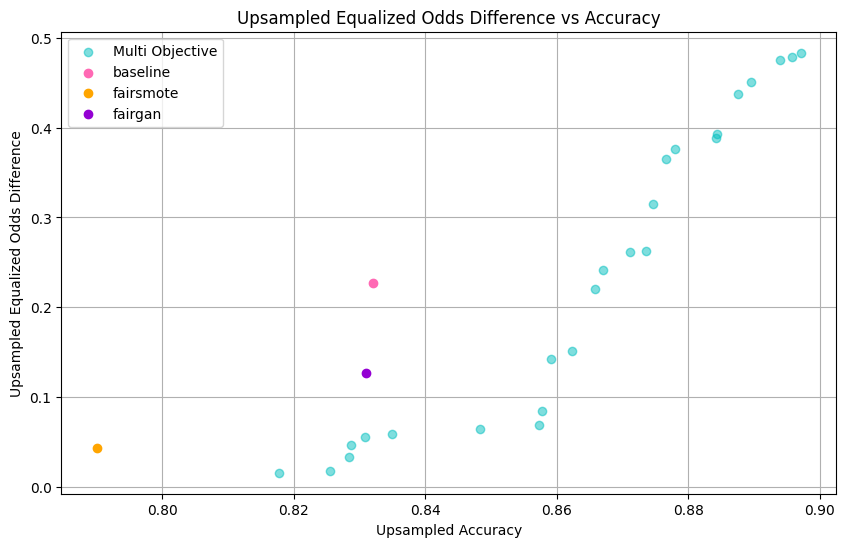

In [38]:
import matplotlib.pyplot as plt

# Plot upsampled_op_diff against upsampled_acc
plt.figure(figsize=(10, 6))
plt.scatter(acc_values_list,fairness_values_list, alpha=0.5,color = 'c', label = 'Multi Objective')

# Add the three additional points
plt.scatter(0.832, 0.227, color='hotpink', label='baseline')  # Baseline point
plt.scatter(0.790, 0.043, color='orange', label='fairsmote')  # Fairsmote point
plt.scatter(0.831, 0.127, color='darkviolet', label='fairgan')  # Fairgan point

plt.xlabel('Upsampled Accuracy')
plt.ylabel('Upsampled Equalized Odds Difference')
plt.title('Upsampled Equalized Odds Difference vs Accuracy')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()

conf matrix:
  [[991 184]
 [183 875]] 
accuracy:  0.8356471115091805 precision:  0.826251180358829 recall:  0.8270321361058601 fpr:  0.15659574468085105 tpr:  0.8270321361058601 fn+fp 367
conf matrix:
  [[975 167]
 [177 777]] 
accuracy:  0.8358778625954199 precision:  0.823093220338983 recall:  0.8144654088050315 fpr:  0.14623467600700527 tpr:  0.8144654088050315 fn+fp 344
conf matrix:
  [[16 17]
 [ 6 98]] 
accuracy:  0.8321167883211679 precision:  0.8521739130434782 recall:  0.9423076923076923 fpr:  0.5151515151515151 tpr:  0.9423076923076923 fn+fp 23
conf matrix:
  [[941 234]
 [163 895]] 
accuracy:  0.8222122704881325 precision:  0.7927369353410098 recall:  0.8459357277882797 fpr:  0.19914893617021276 tpr:  0.8459357277882797 fn+fp 397
conf matrix:
  [[919 222]
 [149 784]] 
accuracy:  0.8211186113789778 precision:  0.7793240556660039 recall:  0.8403001071811361 fpr:  0.19456617002629273 tpr:  0.8403001071811361 fn+fp 371
conf matrix:
  [[ 22  12]
 [ 14 111]] 
accuracy:  0.83647798742

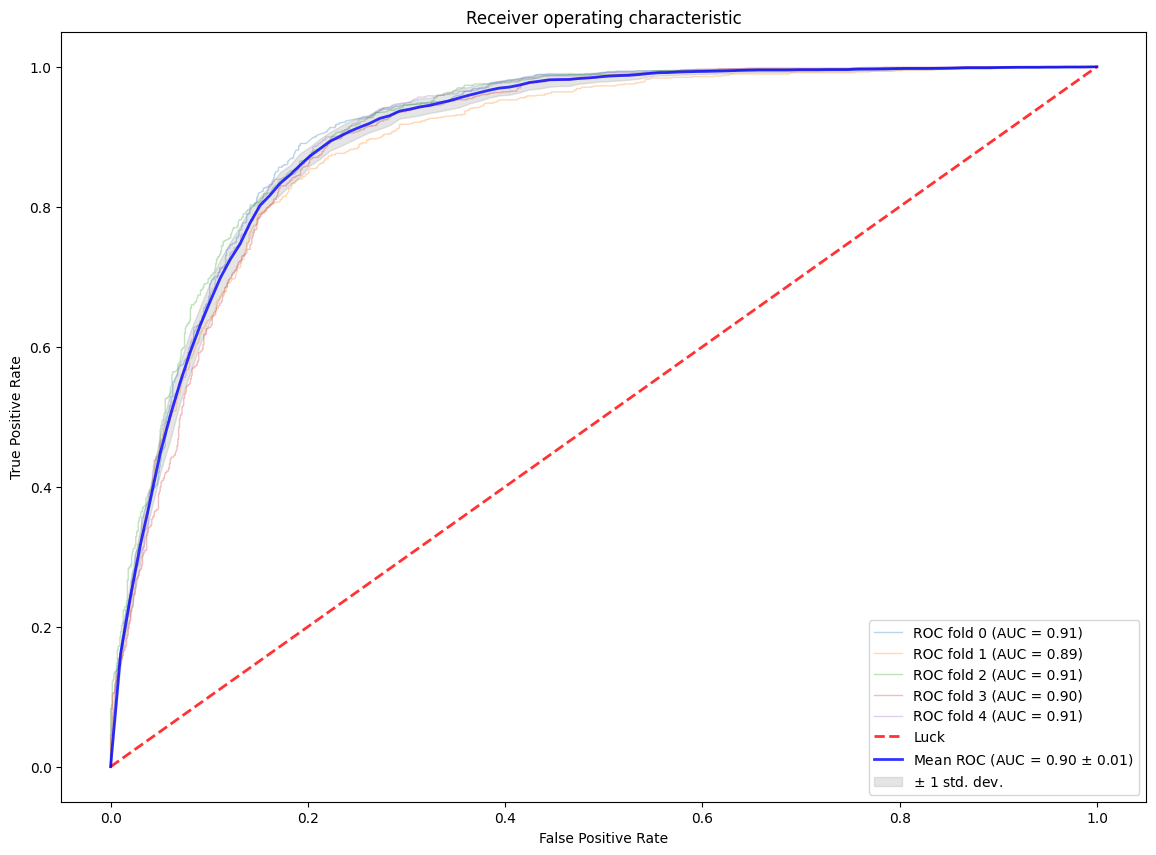

Accaracy list :  [0.8356471115091805, 0.8222122704881325, 0.8301971326164874, 0.828405017921147, 0.8324372759856631]
equal opportunity for tpr :  [0.1278422835026608, 0.04769989281886389, 0.07213010204081627, 0.021656271656271597, 0.10966381467430786]
equal opportunity for fpr :  [0.3689168391445099, 0.15837500644429553, 0.4236129723934602, 0.38288456743954125, 0.5297736220472441]
odds difference list :  [0.24837956132358535, 0.10303744963157971, 0.24787153721713823, 0.20227041954790642, 0.319718718360776]
The mean accuracy is  0.830 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.076 ± 0.039
The mean equal opportunity for fpr: (close to 0) 0.373 ± 0.121
The mean odds difference: (close to 0) 0.224 ± 0.071
The mean parity difference: (close to 0) 0.797 ± 0.018
The mean disperate impact: (close to 1) 1.000 ± 0.000


In [35]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

In [36]:
print('Running time is: ',elapsed_time_minutes)

Running time is:  7.473950576782227
